In [2]:
from scapy.all import rdpcap, PPI_DOT11COMMON, Packet, PacketList, IP
from scapy.layers.dot11 import Dot11
import pyshark
import matplotlib.pyplot as plt

network_file = "/Users/jonasjostan/Documents/itestra/connected-mobility-basics-group-7/part2_capture3.pcap"

In [3]:
def processing_file(file_path: str):  
        packets:PacketList = rdpcap(file_path)
        return packets

host_to_ipaddress=  {
        "iPad (2020)": "192.168.4.4",
        "MacBook Air M1 (2020)":"192.168.4.10",
        "Windows": "192.168.4.7",
        "Access Point": "192.168.4.1",
        "Broadcast": "192.168.4.255",
}

ipaddress_to_host = {v: k for k, v in host_to_ipaddress.items()}
print(host_to_ipaddress)
print(ipaddress_to_host)
processed_packets = processing_file(network_file)
print(f"Number of packets: {len(processed_packets)}")

{'iPad (2020)': '192.168.4.4', 'MacBook Air M1 (2020)': '192.168.4.10', 'Windows': '192.168.4.7', 'Access Point': '192.168.4.1', 'Broadcast': '192.168.4.255'}
{'192.168.4.4': 'iPad (2020)', '192.168.4.10': 'MacBook Air M1 (2020)', '192.168.4.7': 'Windows', '192.168.4.1': 'Access Point', '192.168.4.255': 'Broadcast'}
Number of packets: 27510


In [4]:
if processed_packets:
    start_time = float(processed_packets[0].time)
    end_time = float(processed_packets[-1].time)
    duration_seconds = end_time - start_time
    print(f"Duration from start to last packet: {duration_seconds:.2f} seconds")
else:
    print("No packets available.")

Duration from start to last packet: 118.96 seconds


In [5]:
packet_rate = len(processed_packets) / duration_seconds
print(f"Packet rate: {packet_rate:.2f} packets per second")

Packet rate: 231.25 packets per second


In [7]:
import nest_asyncio
nest_asyncio.apply()
pyshark_capture = pyshark.FileCapture(network_file, keep_packets=True)

# Analysis of layer for protocolls

## Layer 4

In [5]:
def sort_packets_by_protocol(packets: PacketList):
    sorted_packets = {
        'TCP': [],
        'UDP': [],
        'ICMP': [],
        'ARP': [],
        'Other': []
    }
    
    for packet in packets:
        if packet.haslayer('TCP'):
            sorted_packets['TCP'].append(packet)
        elif packet.haslayer('UDP'):
            sorted_packets['UDP'].append(packet)
        elif packet.haslayer('ICMP'):
            sorted_packets['ICMP'].append(packet)
        elif packet.haslayer('ARP'):
            sorted_packets['ARP'].append(packet)
        
        else:
            sorted_packets['Other'].append(packet)
    
    return sorted_packets

In [5]:
sorteded_packets = sort_packets_by_protocol(processed_packets)
print("Numper of packets by layer 3 and 4 protocol:")
for protocol, packets in sorteded_packets.items():
    print(f"{protocol}: {len(packets)} packets")

Numper of packets by layer 3 and 4 protocol:
TCP: 4688 packets
UDP: 22783 packets
ICMP: 2 packets
ARP: 24 packets
Other: 13 packets


## Layer 7 protocol:

In [6]:

# protocols = set()
# for i, pkt in enumerate(processed_packets):
#     if i == 0:
#         continue
#     try:
#         protocol.__add__(pyshark_capture[i].highest_layer)
#     except:
#         app_proto = "Unknown"
#     print(pyshark_capture[i])
#     #print(f"Packet {i+1}: {app_proto}, Scapy summary: {pkt.summary()}")
# print(protocols)

In [8]:
def calculate_distribution_by_protocol(protocols: dict):
    protocol_counts = {protocol: len(packets) for protocol, packets in protocols.items()}
    total_packets = sum(protocol_counts.values())
    
    distribution = {protocol: count / total_packets * 100 for protocol, count in protocol_counts.items()}
    
    return distribution

def get_protocol_counts(protocols_dict):
    protocol_counts = {protocol: len(packets) for protocol, packets in protocols_dict.items()}
    return protocol_counts


In [9]:
def get_layer7_protocol_packets(capture):
    layer7_packets = {}
    i = 0
    for packet in capture:
        i+=1
        highest_layer = packet.highest_layer
        
        if highest_layer not in layer7_packets:
            layer7_packets[highest_layer] = []
        layer7_packets[highest_layer].append(i)
        
    return layer7_packets



layer7_packets = get_layer7_protocol_packets(pyshark_capture)


print("Number of packets by highest layer protocol:")
for protocol, packets in layer7_packets.items():
    print(f"{protocol}: {len(packets)} packets")
    

Number of packets by highest layer protocol:
ICMPV6: 13 packets
ARP: 24 packets
QUIC: 22642 packets
DNS: 132 packets
TCP: 3064 packets
TLS: 1622 packets
MDNS: 8 packets
ICMP: 2 packets
DATA: 3 packets


In [10]:
def create_packetlist_by_protocol(packetlist: PacketList, highest_layer:dict):
    protocol_packets = {}
    for protocol, indexlist in highest_layer.items():
        if protocol not in protocol_packets:
            protocol_packets[protocol] = []
        for index in indexlist:
            if index < len(packetlist):
                protocol_packets[protocol].append(packetlist[index])


    
    
    
    return protocol_packets

packetlist_by_protocol = create_packetlist_by_protocol(processed_packets, layer7_packets)
print("Number of packets by Layer 7 protocol in Scapy PacketList:")
for protocol, packets in packetlist_by_protocol.items():
    print(f"{protocol}: {len(packets)} packets")

Number of packets by Layer 7 protocol in Scapy PacketList:
ICMPV6: 13 packets
ARP: 24 packets
QUIC: 22642 packets
DNS: 132 packets
TCP: 3063 packets
TLS: 1622 packets
MDNS: 8 packets
ICMP: 2 packets
DATA: 3 packets


In [10]:
protocol_counts = get_protocol_counts(layer7_packets)

# Prepare LaTeX table for double column
latex_table = []
latex_table.append("\\begin{table}[ht]")
latex_table.append("\\centering")
latex_table.append("\\caption{Number of packets per highest layer protocol}")
latex_table.append("\\begin{tabular}{lr}")
latex_table.append("\\toprule")
latex_table.append("Protocol & Number of Packets \\\\")
latex_table.append("\\midrule")
for proto, count in protocol_counts.items():
    latex_table.append(f"{proto} & {count} \\\\")
latex_table.append("\\bottomrule")
latex_table.append("\\end{tabular}")
latex_table.append("\\label{tab:packets_per_protocol}")
latex_table.append("\\end{table}")

# Print LaTeX table
print("\n".join(latex_table))

\begin{table}[ht]
\centering
\caption{Number of packets per highest layer protocol}
\begin{tabular}{lr}
\toprule
Protocol & Number of Packets \\
\midrule
ICMPV6 & 13 \\
ARP & 24 \\
QUIC & 22642 \\
DNS & 132 \\
TCP & 3064 \\
TLS & 1622 \\
MDNS & 8 \\
ICMP & 2 \\
DATA & 3 \\
\bottomrule
\end{tabular}
\label{tab:packets_per_protocol}
\end{table}


Create distribution per protocol:

In [11]:
distribution_layer_7 = calculate_distribution_by_protocol(layer7_packets)
for protocol, percentage in distribution_layer_7.items():
    print(f"{protocol}: {percentage:.2f}%")

ICMPV6: 0.05%
ARP: 0.09%
QUIC: 82.30%
DNS: 0.48%
TCP: 11.14%
TLS: 5.90%
MDNS: 0.03%
ICMP: 0.01%
DATA: 0.01%


In [12]:
protocol_counts = get_protocol_counts(layer7_packets)

# Prepare LaTeX table for double column, now with percentage and total packet size, sorted descending by number of packets
latex_table = []
latex_table.append("\\begin{table}[ht]")
latex_table.append("\\centering")
latex_table.append("\\caption{Number, percentage, and total size of packets per highest layer protocol}")
latex_table.append("\\begin{tabular}{lrrr}")
latex_table.append("\\toprule")
latex_table.append("Protocol & Number of Packets & Percentage & Total Size (Bytes) \\\\")
latex_table.append("\\midrule")
total_count = 0
total_percent = 0.0
total_size = 0
for proto, count in sorted(protocol_counts.items(), key=lambda x: x[1], reverse=True):
    percent = distribution_layer_7.get(proto, 0)
    size = sum(len(pkt) for pkt in packetlist_by_protocol.get(proto, []))
    latex_table.append(f"{proto} & {count} & {percent:.2f}\\% & {size} \\\\")
    total_count += count
    total_percent += percent
    total_size += size
latex_table.append("\\midrule")
latex_table.append(f"Total & {total_count} & {total_percent:.2f}\\% & {total_size} \\\\")
latex_table.append("\\bottomrule")
latex_table.append("\\end{tabular}")
latex_table.append("\\label{tab:packets_per_protocol}")
latex_table.append("\\end{table}")

# Print LaTeX table
print("\n".join(latex_table))


\begin{table}[ht]
\centering
\caption{Number, percentage, and total size of packets per highest layer protocol}
\begin{tabular}{lrrr}
\toprule
Protocol & Number of Packets & Percentage & Total Size (Bytes) \\
\midrule
QUIC & 22642 & 82.30\% & 18030492 \\
TCP & 3064 & 11.14\% & 1844451 \\
TLS & 1622 & 5.90\% & 885963 \\
DNS & 132 & 0.48\% & 37707 \\
ARP & 24 & 0.09\% & 5819 \\
ICMPV6 & 13 & 0.05\% & 1002 \\
MDNS & 8 & 0.03\% & 4488 \\
DATA & 3 & 0.01\% & 1694 \\
ICMP & 2 & 0.01\% & 144 \\
\midrule
Total & 27510 & 100.00\% & 20811760 \\
\bottomrule
\end{tabular}
\label{tab:packets_per_protocol}
\end{table}


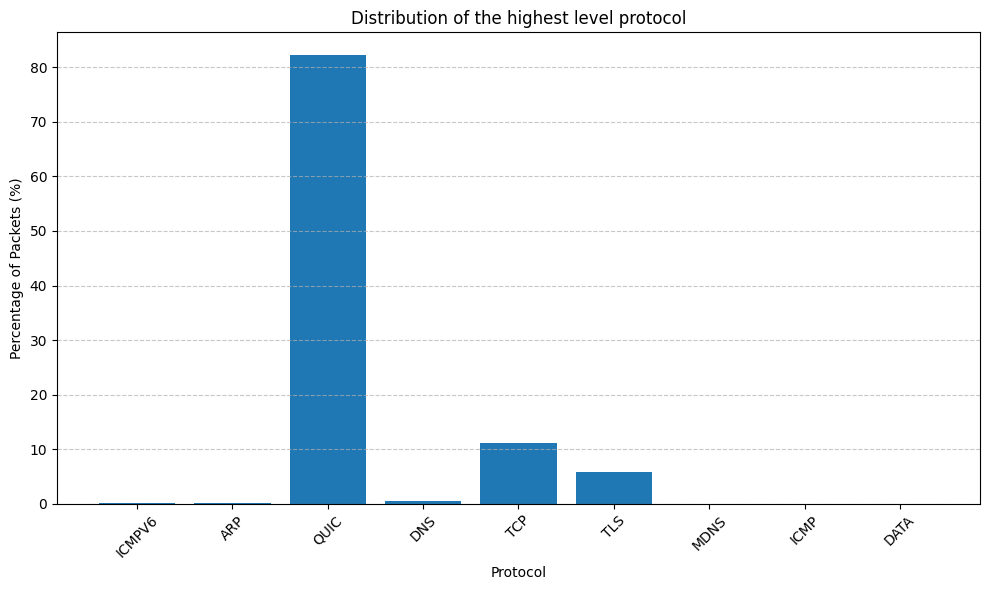

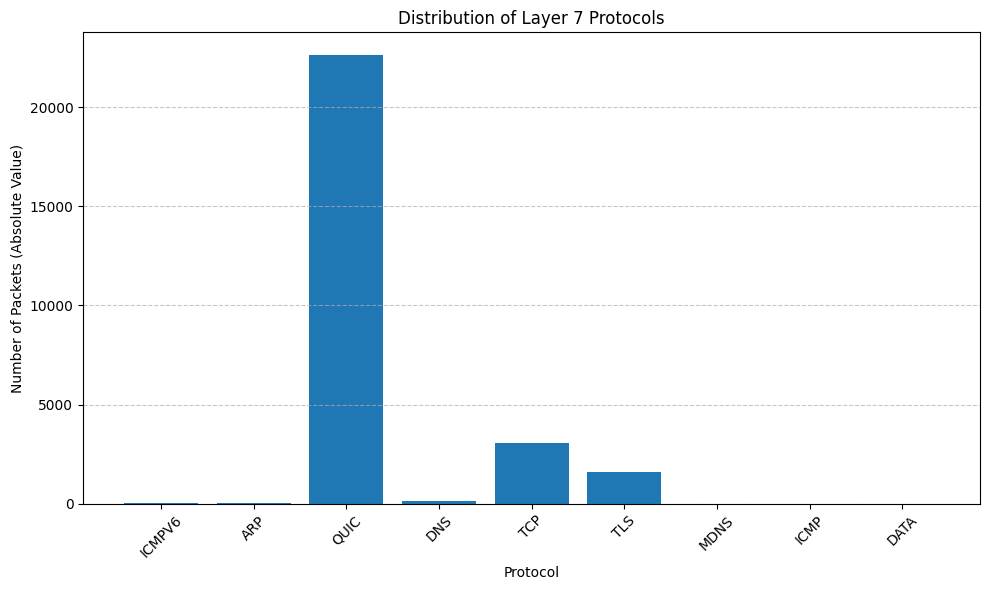

In [13]:
def protocol_distribution_bar_chart(distribution: dict, title: str = 'Distribution of Layer 7 Protocols'):
    protocols = list(distribution.keys())
    # Use absolute values for the y-axis
    values = list(distribution.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(protocols, values)
    plt.xlabel('Protocol')
    plt.ylabel('Percentage of Packets (%)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def protocol_distribution_bar_chart_absolute(distribution: dict, title: str = 'Distribution of Layer 7 Protocols'):
    protocols = list(distribution.keys())
    values = list(distribution.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(protocols, values)
    plt.xlabel('Protocol')
    plt.ylabel('Number of Packets (Absolute Value)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

protocol_distribution_bar_chart(distribution_layer_7, title='Distribution of the highest level protocol')
protocol_distribution_bar_chart_absolute(get_protocol_counts(layer7_packets), title='Distribution of Layer 7 Protocols')

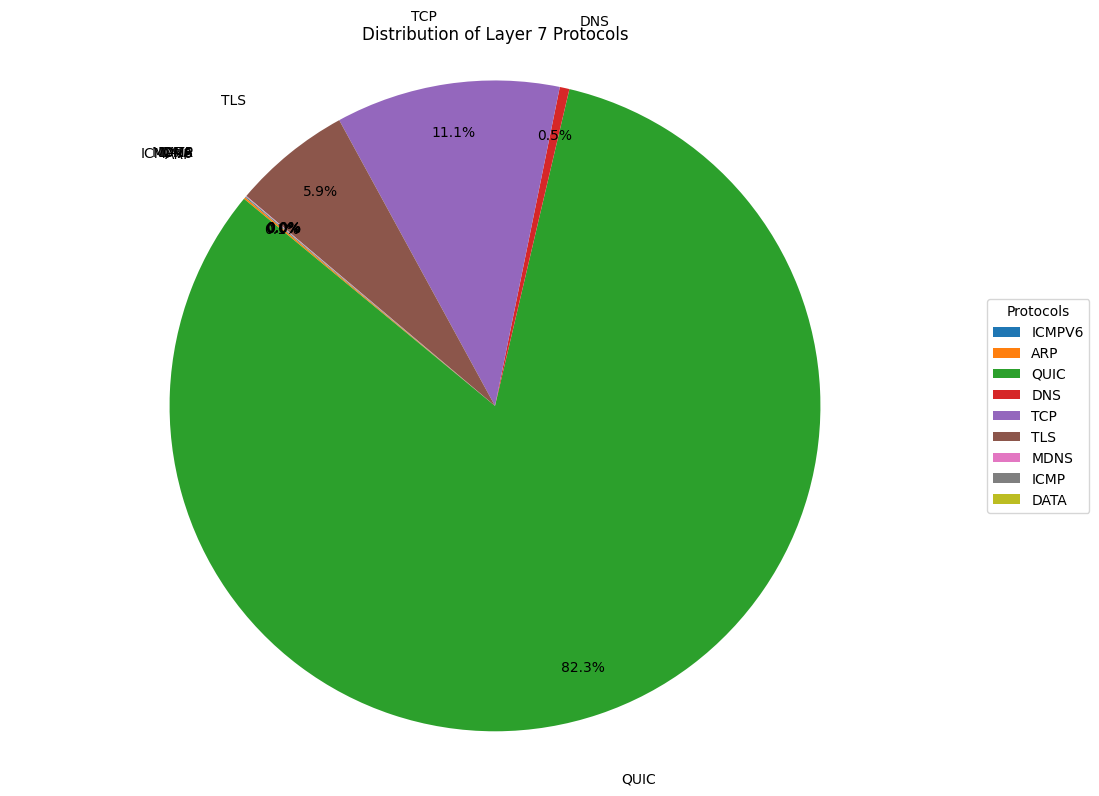

In [14]:
def protocol_distribution_py_chart(distribution: dict):
    protocols = list(distribution.keys())
    percentages = list(distribution.values())
    
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(
        percentages, labels=protocols, autopct='%1.1f%%', startangle=140, 
        textprops={'fontsize': 10},
        pctdistance=0.85  # Move percentage labels closer to the center
    )
    # Increase distance of labels from the center to reduce overlap
    for text in texts:
        text.set_fontsize(10)
        text.set_position((1.1 * text.get_position()[0], 1.1 * text.get_position()[1]))
    plt.title('Distribution of Layer 7 Protocols')
    plt.axis('equal')
    plt.tight_layout()
    plt.legend(wedges, protocols, title="Protocols", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

protocol_distribution_py_chart(get_protocol_counts(layer7_packets))

In [15]:
import plotly.graph_objects as go

def plotly_pie_chart(data: dict, title: str = 'Distribution of highest layer protocols'):
    
    fig = go.Figure(
        data=[
            go.Pie(
                labels=list(data.keys()),
                values=list(data.values())
            )
        ]
    )
    
    fig.update_layout(title_text=title)
    fig.show()
    fig.write_image('distributionofhighestlayerprotocols.png')  # Save the figure as an image
plotly_pie_chart(get_protocol_counts(layer7_packets))

In [16]:
def calculate_encryption_percentage(data:dict):
    total_packets = sum(data.values())
    encrypted_packets = data.get("QUIC",0) + data.get("TLS",0) + data.get("SSL",0) + data.get("HTTPS", 0) + data.get("SSH",0)
    
    if total_packets == 0:
        return 0.0
    
    encryption_percentage = (encrypted_packets / total_packets) * 100
    return encrypted_packets, encryption_percentage

total_encrypted, encryption_percentage = calculate_encryption_percentage(get_protocol_counts(layer7_packets))
print(f"Percentage of encrypted packets: {encryption_percentage:.2f}%")
print(f"Total encrypted packets: {total_encrypted}")

Percentage of encrypted packets: 88.20%
Total encrypted packets: 24264


In [17]:

# def calculate_encrypted_packets_after_protocol(capture, protocol: str):
#     encrypted_packets = 0
#     total_packets = 0
    
#     for packet in capture:
#         if packet.highest_layer == protocol:
#             total_packets += 1
#             if 'encrypted' in packet:
#                 encrypted_packets += 1
    
#     if total_packets == 0:
#         return 0.0
    
#     return (encrypted_packets / total_packets) * 100

# def calculate_encrypted_packets_by_protocol(capture):
#     encrypted_distribution = {}
    
#     for packet in capture:
#         protocol = packet.highest_layer
#         if protocol not in encrypted_distribution:
#             encrypted_distribution[protocol] = {
#                 'encrypted': 0,
#                 'total': 0
#             }
        
#         encrypted_distribution[protocol]['total'] += 1
#         if 'encrypted' in packet:
#             encrypted_distribution[protocol]['encrypted'] += 1
    
#     for protocol, counts in encrypted_distribution.items():
#         if counts['total'] > 0:
#             counts['percentage'] = (counts['encrypted'] / counts['total']) * 100
#         else:
#             counts['percentage'] = 0.0
    
#     return encrypted_distribution
# encrypted_distribution = calculate_encrypted_packets_by_protocol(pyshark_capture)
# print("Encrypted packets distribution by protocol:")
# for protocol, counts in encrypted_distribution.items():
#     print(f"{protocol}: {counts['encrypted']} encrypted packets out of {counts['total']} total packets ({counts['percentage']:.2f}%)")

Analysing Arp-Requests

Analys

Arrival rate per host:


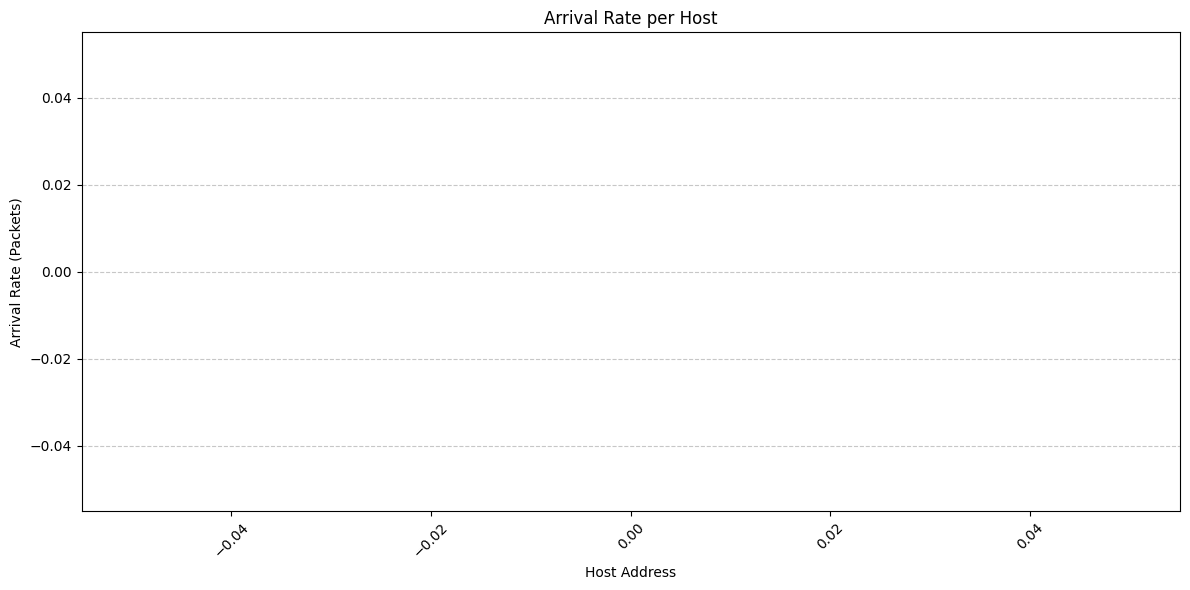

In [18]:
def arravial_rate_per_host(processed_packets:PacketList):
    host_arrival_rate = {}
    
    for packet in processed_packets:
        if packet.haslayer(Dot11):
            src = packet[Dot11].addr2
            if src not in host_arrival_rate:
                host_arrival_rate[src] = 0
            host_arrival_rate[src] += 1
    
    return host_arrival_rate

def plot_arrival_rate_per_host(arrival_rate: dict):
    hosts = list(arrival_rate.keys())
    rates = list(arrival_rate.values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(hosts, rates, color='skyblue')
    plt.xlabel('Host Address')
    plt.ylabel('Arrival Rate (Packets)')
    plt.title('Arrival Rate per Host')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

arrival_rate = arravial_rate_per_host(processed_packets)
print("Arrival rate per host:")
for host, rate in arrival_rate.items():
    print(f"{host}: {rate} packets")
plot_arrival_rate_per_host(arrival_rate)

Start time: 1751962809.229969634
End time: 1751962928.194464213


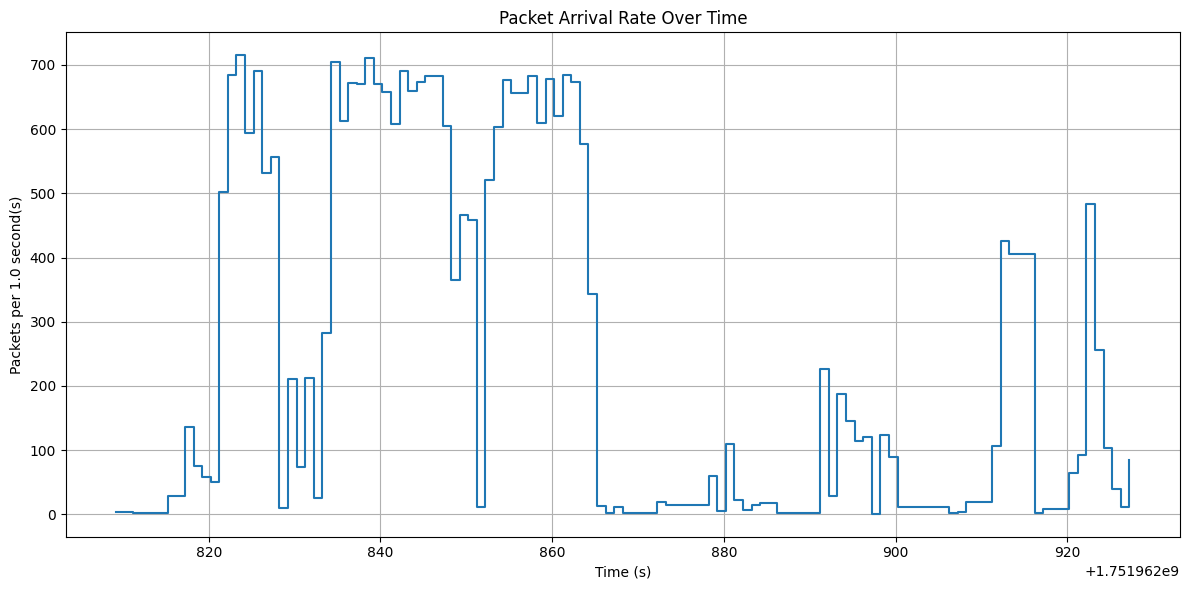

In [19]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_packet_arrival_rate(packets, interval=1.0):
    """
    Plot packet arrival rate over time.

    Parameters:
        packets (list): List of Scapy packets (e.g., from rdpcap()).
        interval (float): Bin size in seconds (default is 1.0).
    """
    if not packets:
        raise ValueError("No packets provided.")

    time_bins = defaultdict(int)
    start_time = packets[0].time
    print(f"Start time: {start_time}")
    end_time = packets[-1].time
    print(f"End time: {end_time}")
    for pkt in packets:
        bin_index = int((pkt.time - start_time) // interval)
        time_bins[bin_index] += 1

    times = [start_time + i * interval for i in sorted(time_bins)]
    counts = [time_bins[i] for i in sorted(time_bins)]

    plt.figure(figsize=(12, 6))
    plt.plot(times, counts, drawstyle='steps-post')
    plt.xlabel("Time (s)")
    plt.ylabel(f"Packets per {interval} second(s)")
    plt.title("Packet Arrival Rate Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_packet_arrival_rate(processed_packets, interval=1.0)

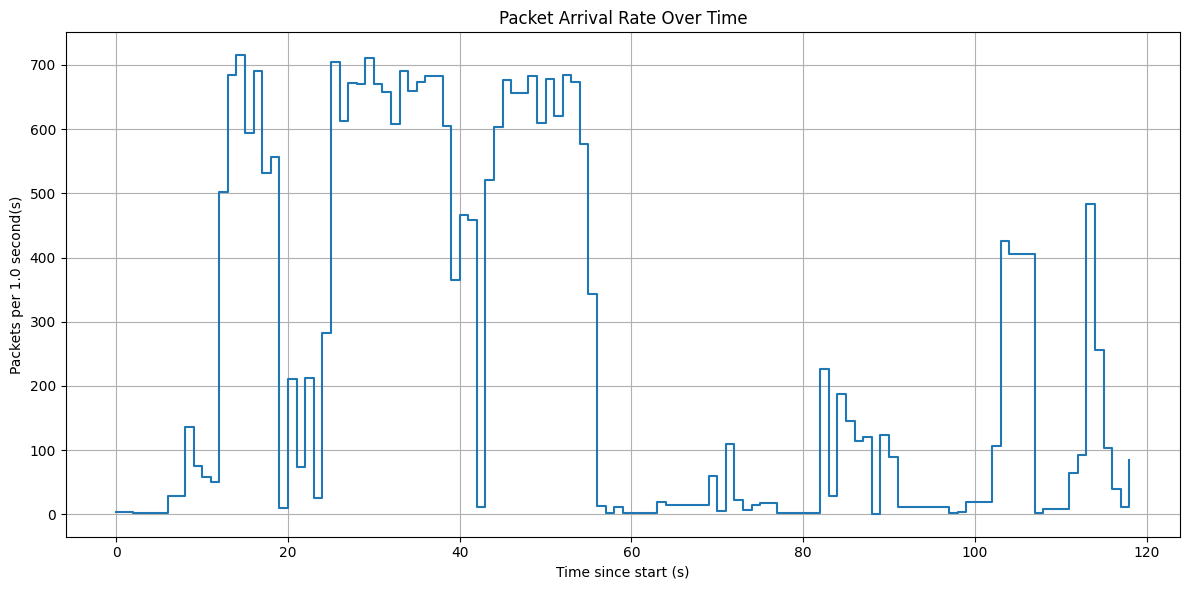

In [20]:
from scapy.all import rdpcap
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_packet_arrival_rate(packets, interval=1.0):
    """
    Plot packet arrival rate over time.

    Parameters:
        packets (list): List of Scapy packets (e.g., from rdpcap()).
        interval (float): Bin size in seconds.
    """
    if not packets:
        raise ValueError("No packets provided.")

    start_time = packets[0].time
    time_bins = defaultdict(int)

    for pkt in packets:
        bin_index = int((pkt.time - start_time) // interval)
        time_bins[bin_index] += 1

    # Shift times so the x-axis starts at 0
    times = [i * interval for i in sorted(time_bins)]
    counts = [time_bins[i] for i in sorted(time_bins)]

    plt.figure(figsize=(12, 6))
    plt.plot(times, counts, drawstyle='steps-post')
    plt.xlabel("Time since start (s)")
    plt.ylabel(f"Packets per {interval} second(s)")
    plt.title("Packet Arrival Rate Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_packet_arrival_rate(processed_packets, interval=1.0)


In [21]:
def packet_arrival_rate_per_protocol(packetlist: PacketList, interval: float = 1.0):
    """
    Calculate packet arrival rate per protocol over time.

    Parameters:
        packetlist (PacketList): List of Scapy packets.
        interval (float): Time interval in seconds for binning packets.

    Returns:
        dict: Dictionary with protocol names as keys and lists of packet counts as values.
    """
    protocol_bins = defaultdict(lambda: defaultdict(int))
    
    start_time = packetlist[0].time
    for pkt in packetlist:
        bin_index = int((pkt.time - start_time) // interval)
        protocol_name = pkt.highest_layer if hasattr(pkt, 'highest_layer') else 'Unknown'
        protocol_bins[protocol_name][bin_index] += 1
    
    return {proto: [protocol_bins[proto][i] for i in sorted(protocol_bins[proto])] for proto in protocol_bins}     
def plotly_packet_arrival_rate_per_protocol(packetlist: PacketList, interval: float = 1.0):
    """
    Plot packet arrival rate per protocol over time using Plotly.

    Parameters:
        packetlist (PacketList): List of Scapy packets.
        interval (float): Time interval in seconds for binning packets.
    """
    protocol_data = packet_arrival_rate_per_protocol(packetlist, interval)          
    fig = go.Figure()
    start_time = packetlist[0].time
    
    for protocol, counts in protocol_data.items():
        times = [start_time + i * interval for i in range(len(counts))]
        fig.add_trace(go.Scatter(
            x=times,
            y=counts,
            mode='lines+markers',
            name=protocol,
            line=dict(shape='hv')
        ))
            
    fig.update_layout(
        title="Packet Arrival Rate per Protocol",
        xaxis_title="Time (s)",
        yaxis_title="Packets per Interval",
        legend_title="Protocol",
        template="plotly_white"
    )       
    fig.update_xaxes(dtick=interval)
    fig.update_yaxes(title_text="Packets per Interval")
    fig.update_layout(legend=dict(title_text='Protocol'))
    fig.show()

plotly_packet_arrival_rate_per_protocol(processed_packets, interval=1.0)




In [22]:
from collections import defaultdict

import plotly.graph_objects as go
import plotly.express as px

def plotly_packet_arrival_rate_per_protocol(packets_by_protocol: dict, interval=1.0):
    """
    Plot packet arrival rate over time for each protocol using Plotly.

    Parameters:
        packets_by_protocol (dict): Dictionary mapping protocol names to lists of Scapy packets.
        interval (float): Bin size in seconds.
    """
    fig = go.Figure()
    color_map = px.colors.qualitative.Plotly  # Use Plotly's qualitative color set
    protocol_list = [p for p in packets_by_protocol if packets_by_protocol[p]]
    color_cycle = {protocol: color_map[i % len(color_map)] for i, protocol in enumerate(protocol_list)}

    max_bins = 0
    for protocol in protocol_list:
        packets = packets_by_protocol[protocol]
        packets_sorted = sorted(packets, key=lambda pkt: pkt.time)
        start_time = packets_sorted[0].time
        time_bins = {}
        for pkt in packets_sorted:
            bin_index = int((pkt.time - start_time) // interval)
            time_bins[bin_index] = time_bins.get(bin_index, 0) + 1
        if time_bins:
            max_bins = max(max_bins, max(time_bins.keys()))
        times = [i * interval for i in sorted(time_bins)]
        counts = [time_bins[i] for i in sorted(time_bins)]
        fig.add_trace(go.Scatter(
            x=times, y=counts, mode='lines+markers', name=protocol,
            line=dict(color=color_cycle[protocol]), marker=dict(size=6)
        ))

    # Extend all traces to the same length with zeros at the end
    for trace in fig.data:
        x_vals = list(trace.x)
        y_vals = list(trace.y)
        if x_vals:
            last_bin = int(x_vals[-1] // interval)
            if last_bin < max_bins:
                for i in range(last_bin + 1, max_bins + 1):
                    x_vals.append(i * interval)
                    y_vals.append(0)
            trace.x = x_vals
            trace.y = y_vals

    fig.update_layout(
        title="Packet Arrival Rate Over Time per Protocol (Plotly)",
        xaxis_title="Time since start (s)",
        yaxis_title=f"Packets per {interval} second(s)",
        legend_title="Protocol",
        template="plotly_white",
        font=dict(size=14),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    fig.show()

plotly_packet_arrival_rate_per_protocol(sorteded_packets, interval=1.0)
plotly_packet_arrival_rate_per_protocol(packetlist_by_protocol, interval=1.0)



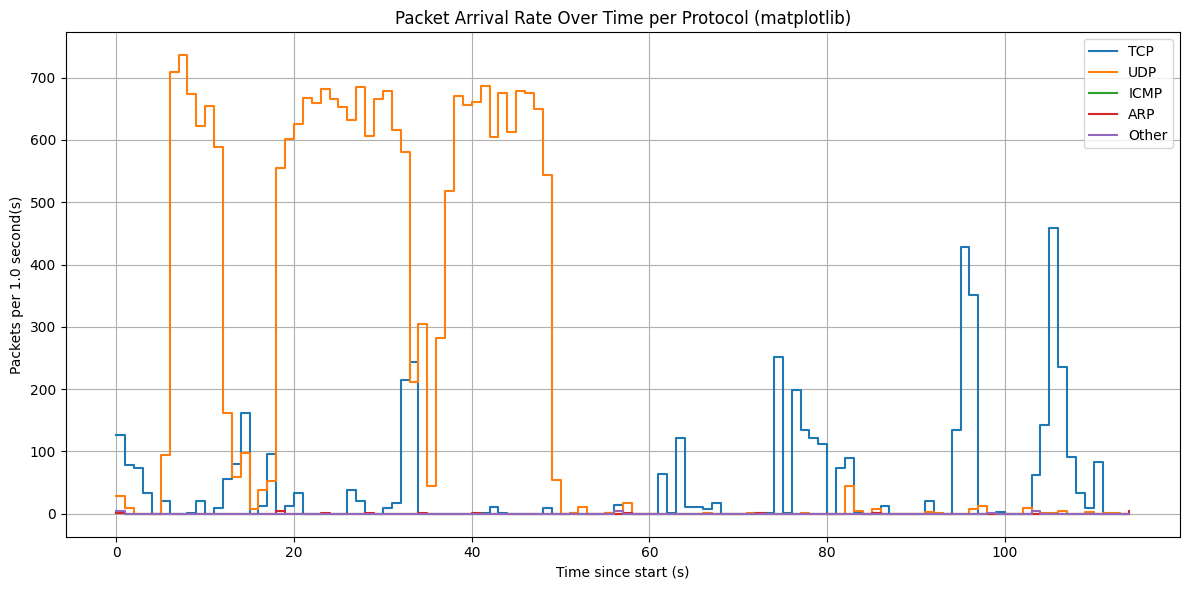

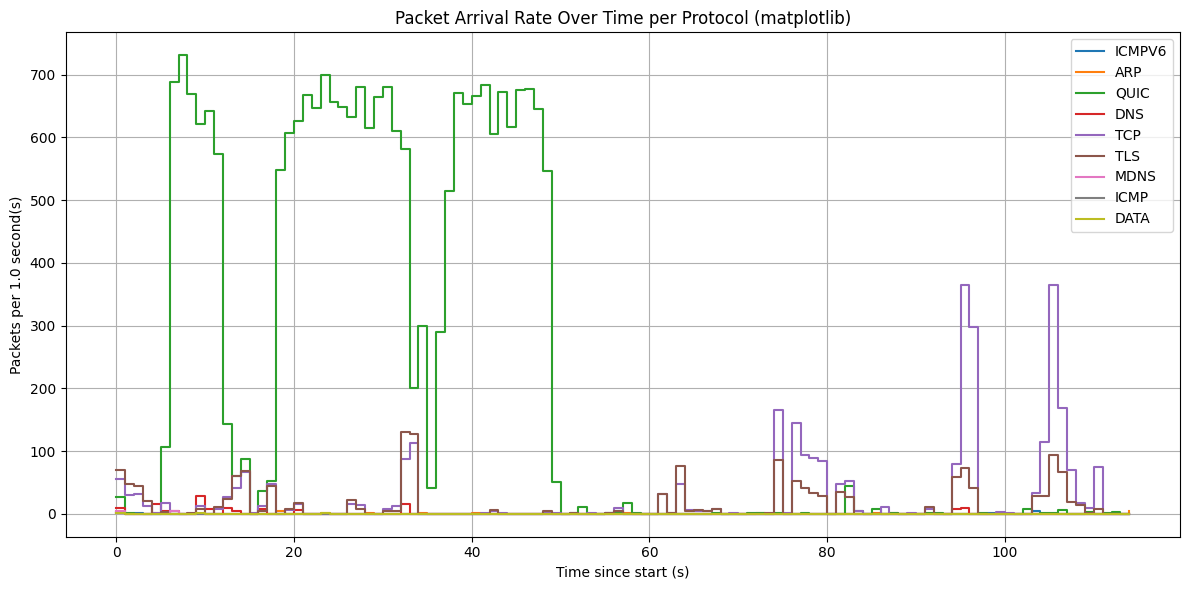

In [23]:
import matplotlib.pyplot as plt

def matplotlib_packet_arrival_rate_per_protocol(packets_by_protocol: dict, interval=1.0):
    """
    Plot packet arrival rate over time for each protocol using matplotlib.

    Parameters:
        packets_by_protocol (dict): Dictionary mapping protocol names to lists of Scapy packets.
        interval (float): Bin size in seconds.
    """
    plt.figure(figsize=(12, 6))
    max_time = 0
    # First, find the maximum time for all protocols
    for protocol, packets in packets_by_protocol.items():
        if not packets:
            continue
        packets_sorted = sorted(packets, key=lambda pkt: pkt.time)
        start_time = packets_sorted[0].time
        last_time = packets_sorted[-1].time
        max_time = max(max_time, last_time - start_time)
    # Now plot each protocol, extending with zeros if needed
    for protocol, packets in packets_by_protocol.items():
        if not packets:
            continue
        packets_sorted = sorted(packets, key=lambda pkt: pkt.time)
        start_time = packets_sorted[0].time
        time_bins = {}
        for pkt in packets_sorted:
            bin_index = int((pkt.time - start_time) // interval)
            time_bins[bin_index] = time_bins.get(bin_index, 0) + 1
        num_bins = int(max_time // interval) + 1
        times = [i * interval for i in range(num_bins)]
        counts = [time_bins.get(i, 0) for i in range(num_bins)]
        plt.step(times, counts, where='post', label=protocol)

    plt.xlabel("Time since start (s)")
    plt.ylabel(f"Packets per {interval} second(s)")
    plt.title("Packet Arrival Rate Over Time per Protocol (matplotlib)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

matplotlib_packet_arrival_rate_per_protocol(sorteded_packets, interval=1.0)
matplotlib_packet_arrival_rate_per_protocol(packetlist_by_protocol, interval=1.0)


In [24]:
import pandas as pd

import plotly.express as px

def plotly_packet_arrival_rate(packets, interval=1.0):
    """
    Plot packet arrival rate over time using Plotly.

    Parameters:
        packets (list): List of Scapy packets (e.g., from rdpcap()).
        interval (float): Bin size in seconds.
    """
    if not packets:
        raise ValueError("No packets provided.")

    start_time = packets[0].time
    time_bins = {}

    for pkt in packets:
        bin_index = int((pkt.time - start_time) // interval)
        time_bins[bin_index] = time_bins.get(bin_index, 0) + 1

    times = [start_time + i * interval for i in sorted(time_bins)]
    counts = [time_bins[i] for i in sorted(time_bins)]

    df = pd.DataFrame({'Time': times, 'Packets': counts})
    fig = px.line(df, x='Time', y='Packets', title='Packet Arrival Rate Over Time (Plotly)')
    fig.update_traces(mode='lines+markers')
    fig.update_layout(xaxis_title='Time (s)', yaxis_title=f'Packets per {interval} second(s)')
    fig.show()

plotly_packet_arrival_rate(processed_packets, interval=1.0)

#CDF


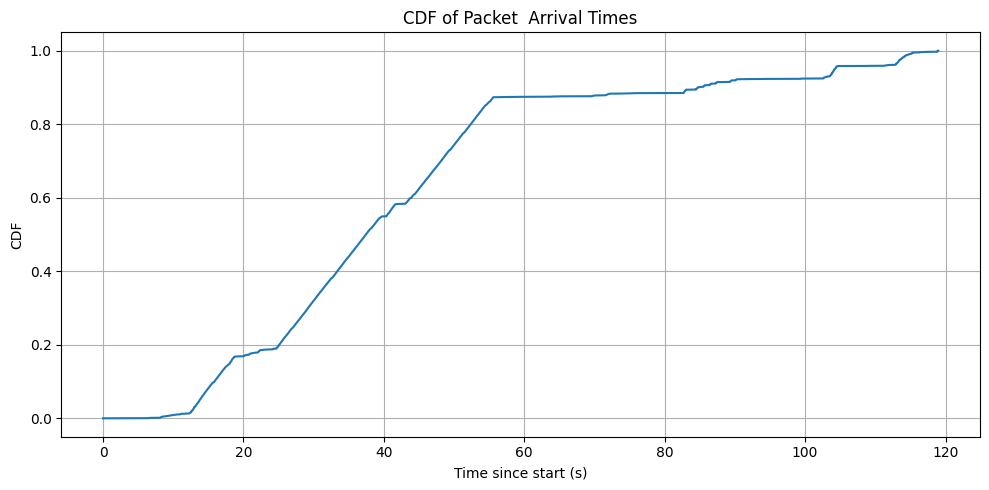

In [25]:
import numpy as np
def plot_packet_arrival_cdf(packets, protocol_name=""):
    times = [pkt.time for pkt in packets]
    times_sorted = np.sort(times)
    # Shift times so the first packet is at time 0
    times_sorted = times_sorted - times_sorted[0]
    cdf = np.arange(1, len(times_sorted)+1) / len(times_sorted)

    plt.figure(figsize=(10, 5))
    plt.plot(times_sorted, cdf)
    plt.xlabel("Time since start (s)")
    plt.ylabel("CDF")
    plt.title(f"CDF of Packet {protocol_name} Arrival Times")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_packet_arrival_cdf(processed_packets)

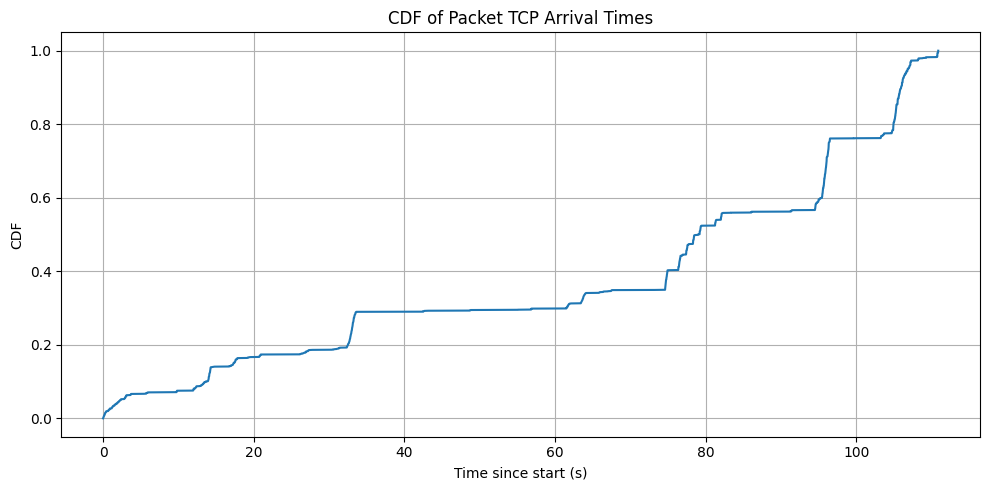

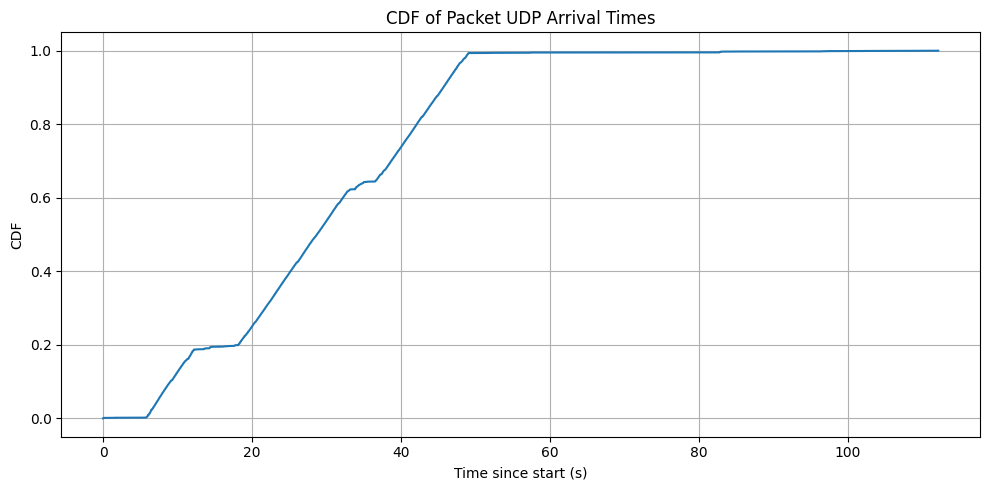

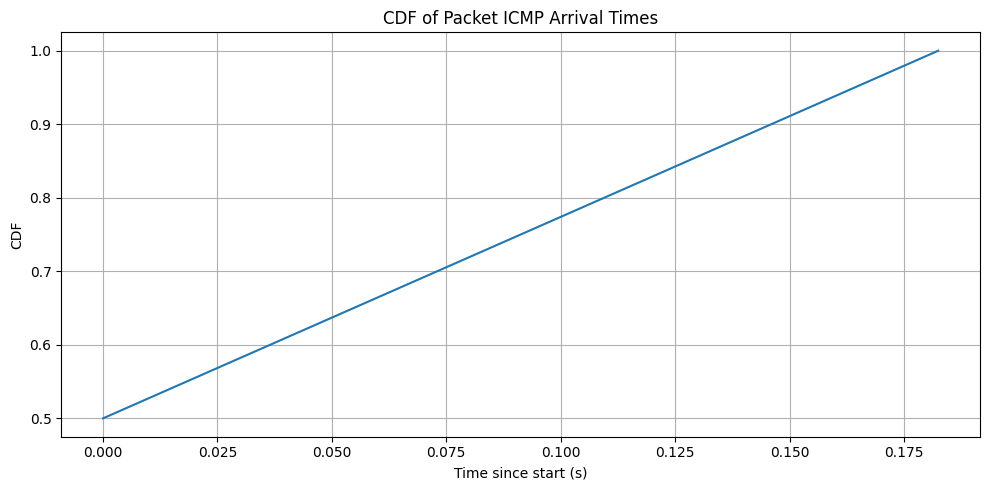

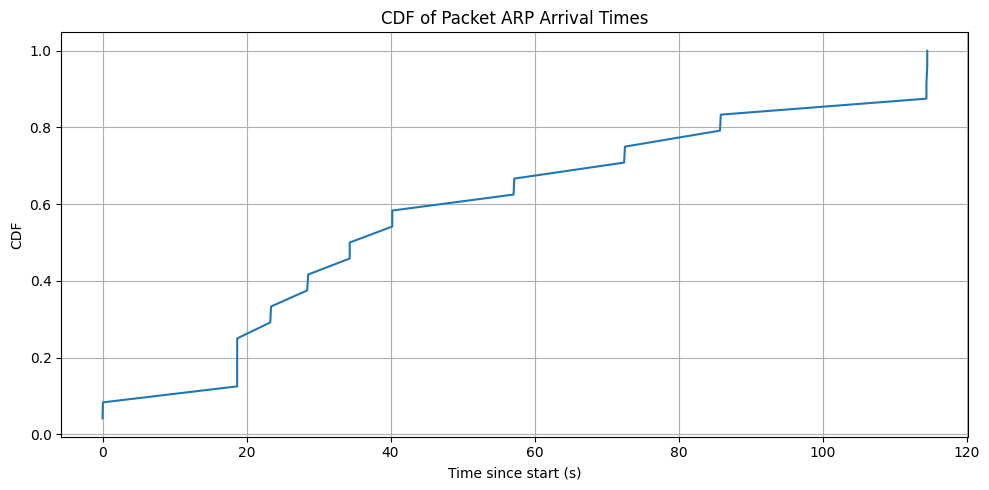

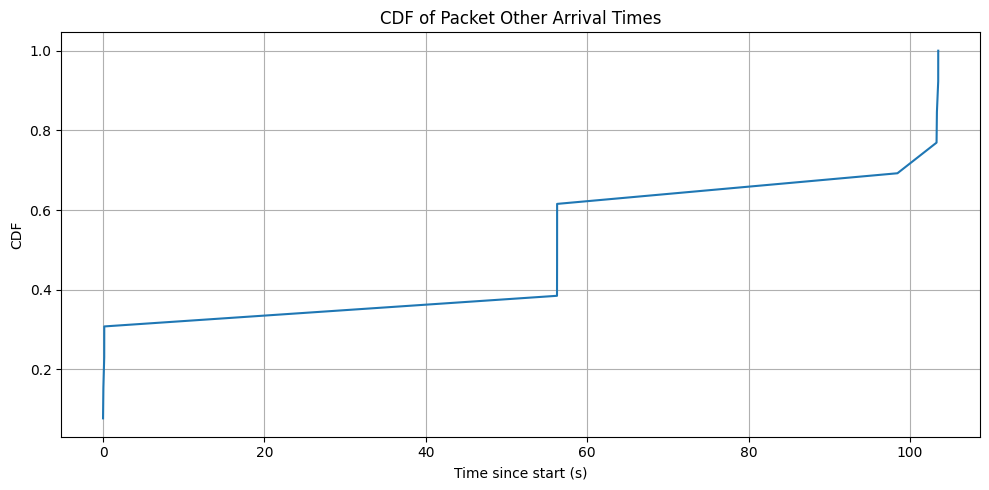

In [26]:
for protocol, packets in sorteded_packets.items():
    if packets:
        plot_packet_arrival_cdf(packets, protocol_name=protocol)
    else:
        print(f"No packets found for protocol: {protocol}")

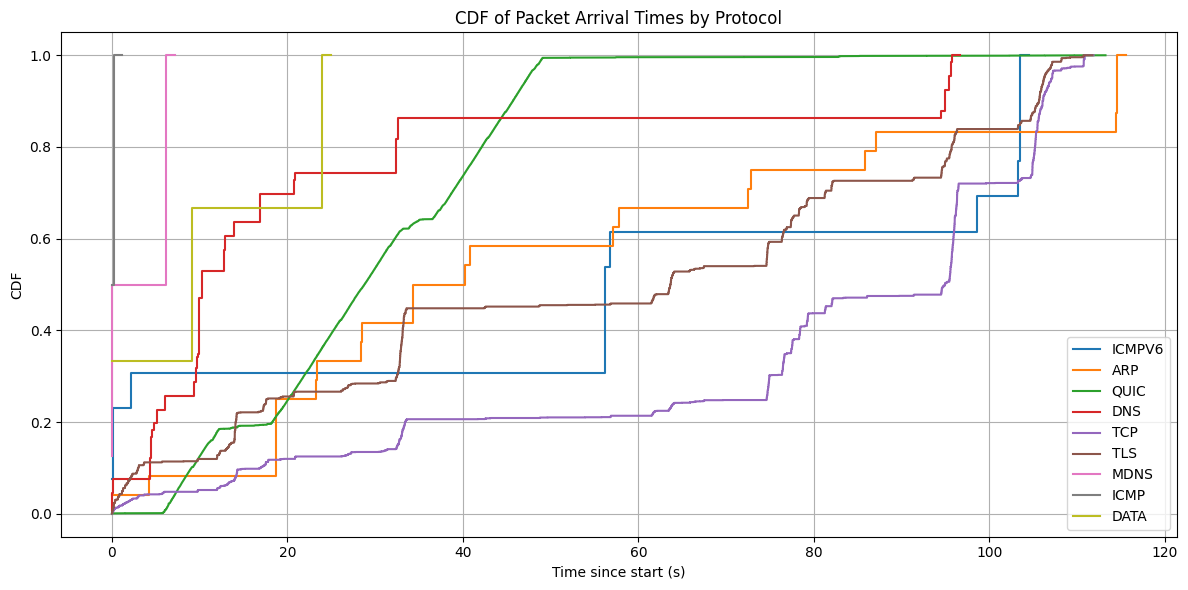

In [27]:
def plot_packet_arrival_protocol_cdf(packets_by_protocol: dict):
    """
    Plot CDF of packet arrival times for each protocol.

    Parameters:
        packets_by_protocol (dict): Dictionary mapping protocol names to lists of Scapy packets.
    """
    plt.figure(figsize=(12, 6))
    
    for protocol, packets in packets_by_protocol.items():
        if not packets:
            continue
        times = [pkt.time for pkt in packets]
        times_sorted = np.sort(times)
        # Shift times so the first packet is at time 0
        times_sorted = times_sorted - times_sorted[0]
        cdf = np.arange(1, len(times_sorted)+1) / len(times_sorted)
        # Extend CDF to remain at 1 after last packet
        times_extended = np.append(times_sorted, times_sorted[-1] + 1)
        cdf_extended = np.append(cdf, 1.0)
        plt.step(times_extended, cdf_extended, where='post', label=protocol)

    plt.xlabel("Time since start (s)")
    plt.ylabel("CDF")
    plt.title("CDF of Packet Arrival Times by Protocol")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



plot_packet_arrival_protocol_cdf(packetlist_by_protocol)


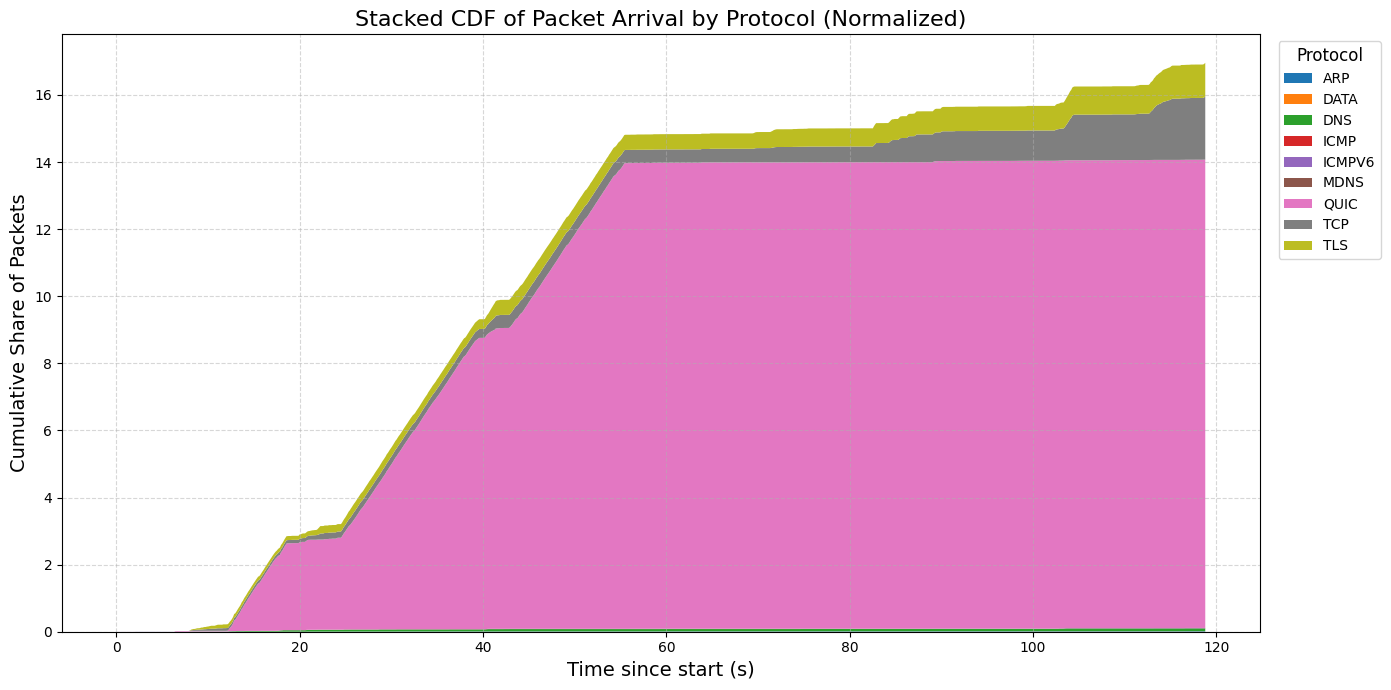

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_stacked_protocol_cdf(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked CDF area chart of packet arrival time contributions by protocol.

    Parameters:
        packets_by_protocol (dict): Mapping of protocol name -> list of Scapy packets
        bins (int): Number of time bins to use for normalization
    """
    all_times = []
    for pkt_list in packets_by_protocol.values():
        all_times.extend(pkt.time for pkt in pkt_list)
    if not all_times:
        raise ValueError("No packets found in input data.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)

    protocol_counts = {}
    for proto, pkts in packets_by_protocol.items():
        pkt_times = np.array([pkt.time for pkt in pkts])
        counts, _ = np.histogram(pkt_times, bins=bin_edges)
        protocol_counts[proto] = counts

    protocols = sorted(protocol_counts.keys())
    stacked_counts = np.vstack([protocol_counts[p] for p in protocols])
    cumulative = np.cumsum(stacked_counts, axis=1)
    total = cumulative[-1]
    normalized = cumulative / total[-1]  # Normalize to total count for stacked area

    x = bin_edges[:-1]

    plt.figure(figsize=(14, 7), dpi=100)
    plt.stackplot(x - x[0], *normalized, labels=protocols)
    plt.title("Stacked CDF of Packet Arrival by Protocol (Normalized)", fontsize=16)
    plt.xlabel("Time since start (s)", fontsize=14)
    plt.ylabel("Cumulative Share of Packets", fontsize=14)
    plt.legend(title="Protocol", loc='upper left', bbox_to_anchor=(1.01, 1.0), fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    plt.savefig('stacked_protocol_cdf.png',)

plot_stacked_protocol_cdf(packetlist_by_protocol, bins=1000)

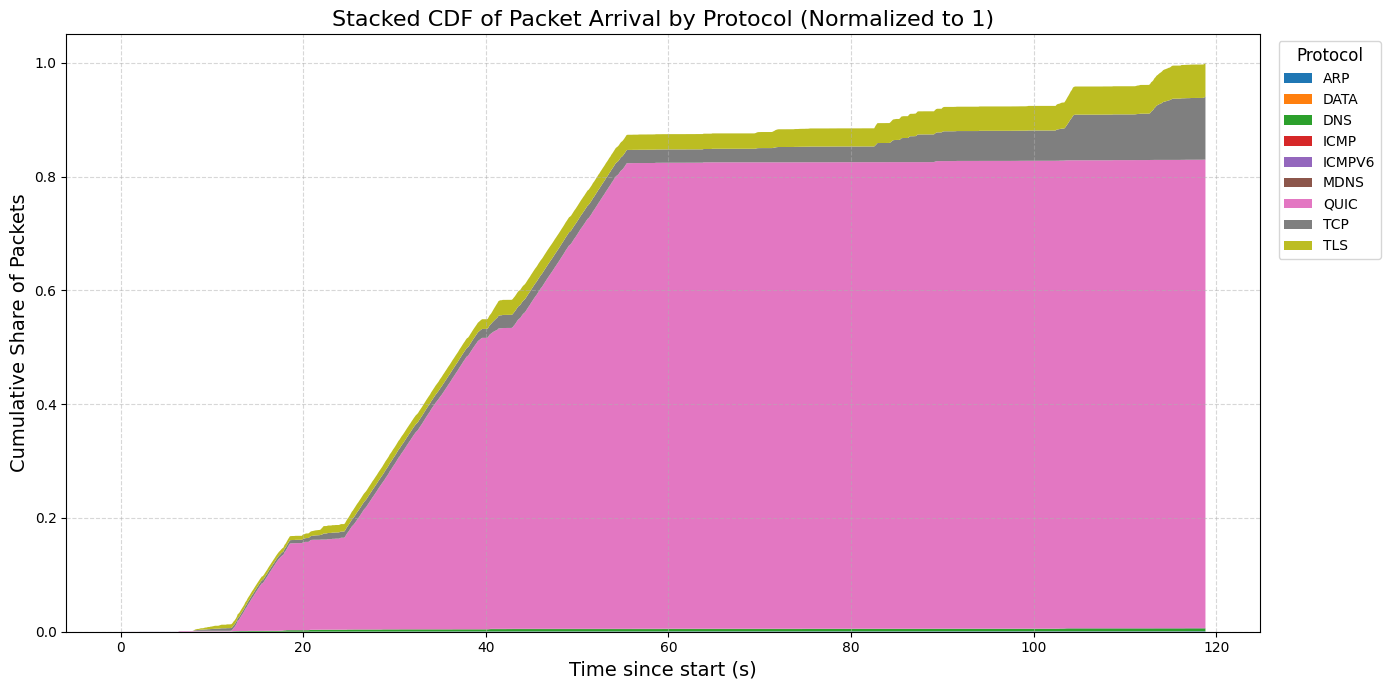

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_stacked_protocol_cdf(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked CDF area chart of packet arrival time contributions by protocol,
    scaled so the top always reaches y=1.
    """
    all_times = []
    for pkt_list in packets_by_protocol.values():
        all_times.extend(pkt.time for pkt in pkt_list)
    if not all_times:
        raise ValueError("No packets found in input data.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)

    protocol_counts = {}
    for proto, pkts in packets_by_protocol.items():
        pkt_times = np.array([pkt.time for pkt in pkts])
        counts, _ = np.histogram(pkt_times, bins=bin_edges)
        protocol_counts[proto] = counts

    protocols = sorted(protocol_counts.keys())
    stacked_counts = np.vstack([protocol_counts[p] for p in protocols])
    cumulative = np.cumsum(stacked_counts, axis=1)
    total_packets = sum(len(pkts) for pkts in packets_by_protocol.values())
    normalized = cumulative / total_packets  # Normalize to total number of packets

    x = bin_edges[:-1]

    plt.figure(figsize=(14, 7), dpi=100)
    plt.stackplot(x - x[0], *normalized, labels=protocols)
    plt.title("Stacked CDF of Packet Arrival by Protocol (Normalized to 1)", fontsize=16)
    plt.xlabel("Time since start (s)", fontsize=14)
    plt.ylabel("Cumulative Share of Packets", fontsize=14)
    plt.legend(title="Protocol", loc='upper left', bbox_to_anchor=(1.01, 1.0), fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('stacked_protocol_cdf_normalized_correctly.png')
    plt.show()

plot_stacked_protocol_cdf(packetlist_by_protocol, bins=1000)

In [30]:
import plotly.graph_objects as go
import numpy as np

def plotly_stacked_protocol_cdf(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked CDF area chart of packet arrival time contributions by protocol using Plotly,
    scaled so the top always reaches y=1.
    """
    all_times = []
    for pkt_list in packets_by_protocol.values():
        all_times.extend(pkt.time for pkt in pkt_list)
    if not all_times:
        raise ValueError("No packets found in input data.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)

    protocol_counts = {}
    for proto, pkts in packets_by_protocol.items():
        pkt_times = np.array([pkt.time for pkt in pkts])
        counts, _ = np.histogram(pkt_times, bins=bin_edges)
        protocol_counts[proto] = counts

    protocols = sorted(protocol_counts.keys())
    stacked_counts = np.vstack([protocol_counts[p] for p in protocols])
    cumulative = np.cumsum(stacked_counts, axis=1)
    total_packets = sum(len(pkts) for pkts in packets_by_protocol.values())
    normalized = cumulative / total_packets  # Normalize to total number of packets

    x = bin_edges[:-1] - bin_edges[0]

    fig = go.Figure()
    for i, proto in enumerate(protocols):
        y = normalized[i]
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='lines',
            stackgroup='one',
            name=proto
        ))

    fig.update_layout(
        title="Stacked CDF of Packet Arrival by Protocol (Normalized to 1)",
        xaxis_title="Time since start (s)",
        yaxis_title="Cumulative Share of Packets",
        legend_title="Protocol",
        template="plotly_white"
    )
    fig.show()

plotly_stacked_protocol_cdf(packetlist_by_protocol, bins=1000)

In [31]:
import plotly.graph_objects as go
import numpy as np

def plotly_stacked_protocol_cdf_absolute_log(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked CDF area chart of packet arrival time contributions by protocol using Plotly,
    with absolute counts and log y-axis.
    """
    all_times = []
    for pkt_list in packets_by_protocol.values():
        all_times.extend(pkt.time for pkt in pkt_list)
    if not all_times:
        raise ValueError("No packets found in input data.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)

    protocol_counts = {}
    for proto, pkts in packets_by_protocol.items():
        pkt_times = np.array([pkt.time for pkt in pkts])
        counts, _ = np.histogram(pkt_times, bins=bin_edges)
        protocol_counts[proto] = counts

    protocols = sorted(protocol_counts.keys())
    stacked_counts = np.vstack([protocol_counts[p] for p in protocols])
    cumulative = np.cumsum(stacked_counts, axis=1)

    x = bin_edges[:-1] - bin_edges[0]

    fig = go.Figure()
    for i, proto in enumerate(protocols):
        y = cumulative[i]
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='lines',
            stackgroup='one',
            name=proto
        ))

    fig.update_layout(
        title="Stacked CDF of Packet Arrival by Protocol (Absolute, Log Y)",
        xaxis_title="Time since start (s)",
        yaxis_title="Cumulative Packet Count",
        legend_title="Protocol",
        template="plotly_white",
        yaxis_type="log"
    )
    fig.show()

plotly_stacked_protocol_cdf_absolute_log(packetlist_by_protocol, bins=1000)


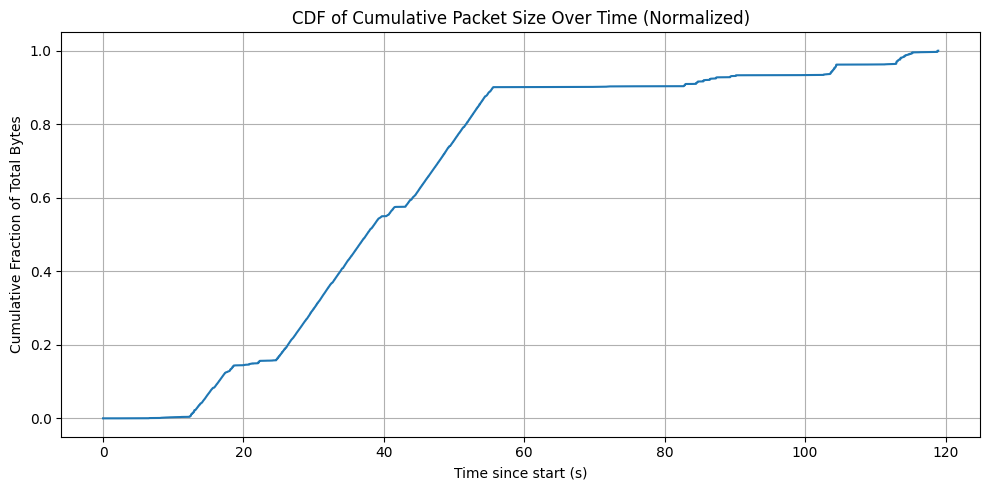

In [32]:
import numpy as np

import matplotlib.pyplot as plt

def plot_packet_size_cdf_over_time(packets):
    """
    Plot the CDF of cumulative packet size over time (normalized to 1).

    Parameters:
        packets (list or PacketList): List of Scapy packets.
    """
    if not packets:
        print("No packets provided.")
        return

    # Extract times and sizes
    times = np.array([pkt.time for pkt in packets])
    sizes = np.array([len(pkt) for pkt in packets])

    # Sort by time
    sort_idx = np.argsort(times)
    times_sorted = times[sort_idx]
    sizes_sorted = sizes[sort_idx]

    # Shift times so the first packet is at time 0
    times_sorted = times_sorted - times_sorted[0]

    # Cumulative sum of sizes, normalized to 1
    cum_sizes = np.cumsum(sizes_sorted)
    cum_sizes_norm = cum_sizes / cum_sizes[-1]

    plt.figure(figsize=(10, 5))
    plt.plot(times_sorted, cum_sizes_norm, label="CDF of Packet Size")
    plt.xlabel("Time since start (s)")
    plt.ylabel("Cumulative Fraction of Total Bytes")
    plt.title("CDF of Cumulative Packet Size Over Time (Normalized)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_packet_size_cdf_over_time(processed_packets)

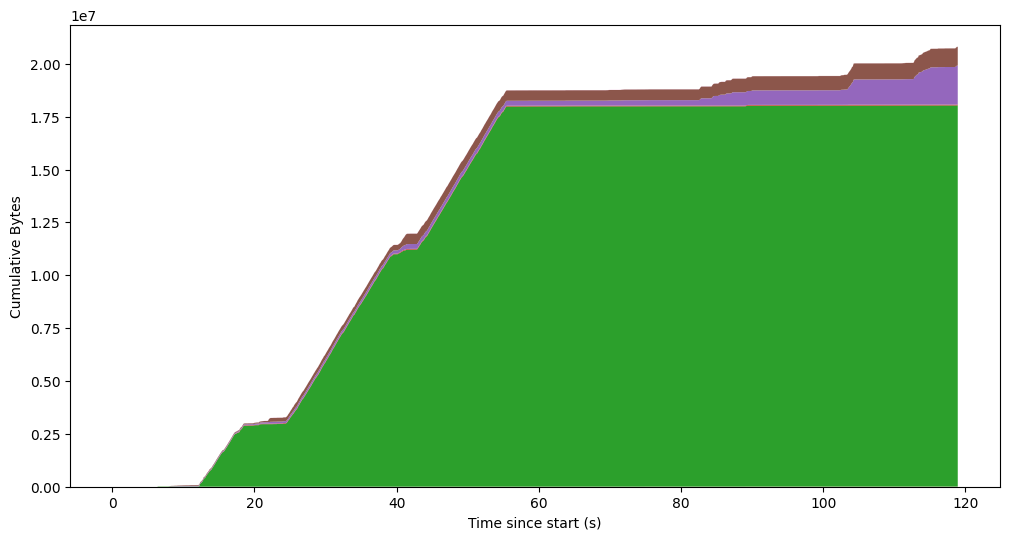

In [33]:
def plot_packet_size_cdf_over_time_per_protocol_stacked(packets_by_protocol):
    plt.figure(figsize=(12, 6))
    protocols = []
    all_times = []
    all_cum_sizes = []

    # Collect all times for global alignment
    for proto, packets in packets_by_protocol.items():
        if not packets:
            continue
        times = np.array([float(pkt.time) for pkt in packets])
        protocols.append(proto)
        all_times.append(times)
    if not all_times:
        print("No data to plot.")
        return

    # Define global time bins
    min_time = min(times.min() for times in all_times)
    max_time = max(times.max() for times in all_times)
    bins = np.linspace(min_time, max_time, 1000)

    # Compute cumulative size per protocol in global bins (absolute bytes)
    for proto, packets in packets_by_protocol.items():
        if not packets:
            continue
        times = np.array([pkt.time for pkt in packets])
        sizes = np.array([len(pkt) for pkt in packets])
        inds = np.digitize(times, bins) - 1
        size_per_bin = np.zeros(len(bins))
        for idx, sz in zip(inds, sizes):
            if 0 <= idx < len(size_per_bin):
                size_per_bin[idx] += sz
        cum_sizes = np.cumsum(size_per_bin)
        all_cum_sizes.append(cum_sizes)

    x = bins - bins[0]
    plt.stackplot(x, all_cum_sizes, labels=protocols)
    plt.xlabel("Time since start (s)")
    plt.ylabel("Cumulative Bytes")
    import plotly.graph_objects as go

    # Prepare data for plotly
    x = bins - bins[0]
    fig = go.Figure()
    for i, proto in enumerate(protocols):
        fig.add_trace(go.Scatter(
            x=x,
            y=all_cum_sizes[i],
            mode='lines',
            stackgroup='one',
            name=proto
        ))

    fig.update_layout(
        yaxis_type="log",
        title="Stacked CDF of Cumulative Packet Size Over Time per Protocol (Absolute Bytes, Log Y)",
        xaxis_title="Time since start (s)",
        yaxis_title="Cumulative Bytes (log scale)",
        legend_title="Protocol",
        template="plotly_white"
    )
    fig.show()

plot_packet_size_cdf_over_time_per_protocol_stacked(packetlist_by_protocol)

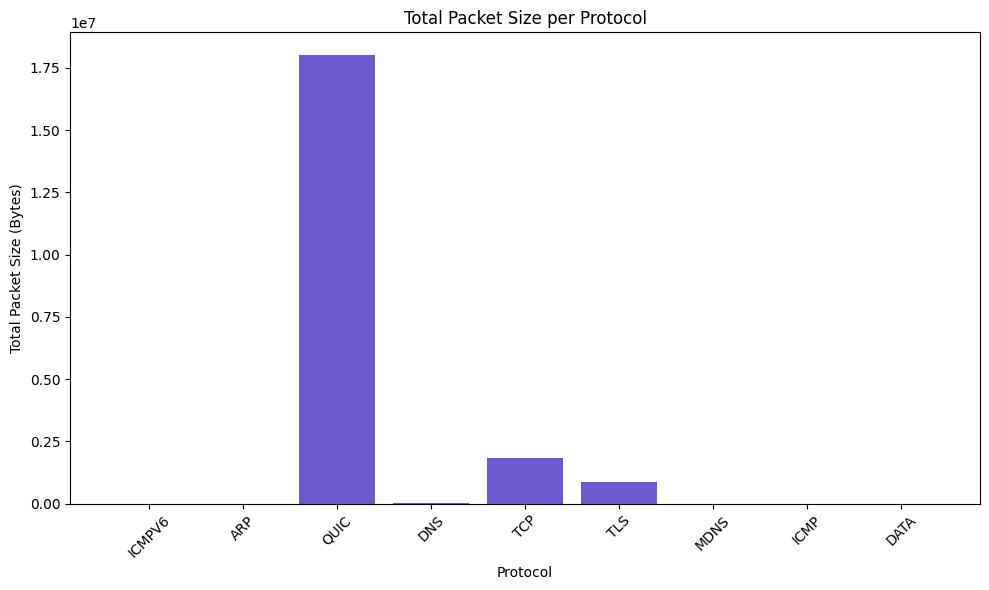

In [34]:
import numpy as np

import matplotlib.pyplot as plt

def plot_total_packet_size_per_protocol(packets_by_protocol):
    protocols = []
    total_sizes = []
    for proto, packets in packets_by_protocol.items():
        if not packets:
            continue
        total_size = sum(len(pkt) for pkt in packets)
        protocols.append(proto)
        total_sizes.append(total_size)
    plt.figure(figsize=(10, 6))
    plt.bar(protocols, total_sizes, color='slateblue')
    plt.xlabel("Protocol")
    plt.ylabel("Total Packet Size (Bytes)")
    plt.title("Total Packet Size per Protocol")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_total_packet_size_per_protocol(packetlist_by_protocol)

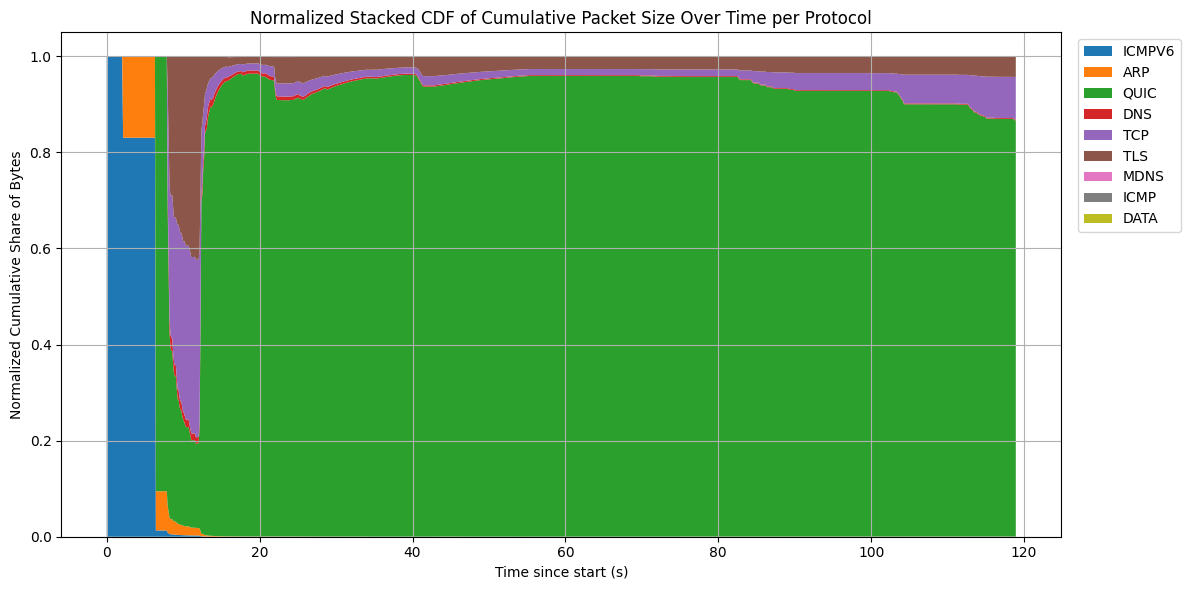

<Figure size 640x480 with 0 Axes>

In [35]:
def plot_packet_size_cdf_over_time_per_protocol_stacked_normalized(packets_by_protocol):
    plt.figure(figsize=(12, 6))
    protocols = []
    all_times = []
    all_cum_sizes = []

    # Collect all times for global alignment
    for proto, packets in packets_by_protocol.items():
        if not packets:
            continue
        times = np.array([float(pkt.time) for pkt in packets])
        protocols.append(proto)
        all_times.append(times)
    if not all_times:
        print("No data to plot.")
        return

    # Define global time bins
    min_time = min(times.min() for times in all_times)
    max_time = max(times.max() for times in all_times)
    bins = np.linspace(min_time, max_time, 1000)

    # Compute cumulative size per protocol in global bins
    for proto, packets in packets_by_protocol.items():
        if not packets:
            continue
        times = np.array([pkt.time for pkt in packets])
        sizes = np.array([len(pkt) for pkt in packets])
        inds = np.digitize(times, bins) - 1
        size_per_bin = np.zeros(len(bins))
        for idx, sz in zip(inds, sizes):
            if 0 <= idx < len(size_per_bin):
                size_per_bin[idx] += sz
        cum_sizes = np.cumsum(size_per_bin)
        all_cum_sizes.append(cum_sizes)

    # Stack and normalize so the top is always 1
    stacked = np.vstack(all_cum_sizes)
    total = stacked.sum(axis=0)
    total[total == 0] = 1  # avoid division by zero
    normalized = stacked / total

    x = bins - bins[0]
    plt.stackplot(x, normalized, labels=protocols)
    plt.xlabel("Time since start (s)")
    plt.ylabel("Normalized Cumulative Share of Bytes")
    plt.title("Normalized Stacked CDF of Cumulative Packet Size Over Time per Protocol")
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig('normalized_stacked_cdf_packet_size.png')

plot_packet_size_cdf_over_time_per_protocol_stacked_normalized(packetlist_by_protocol)


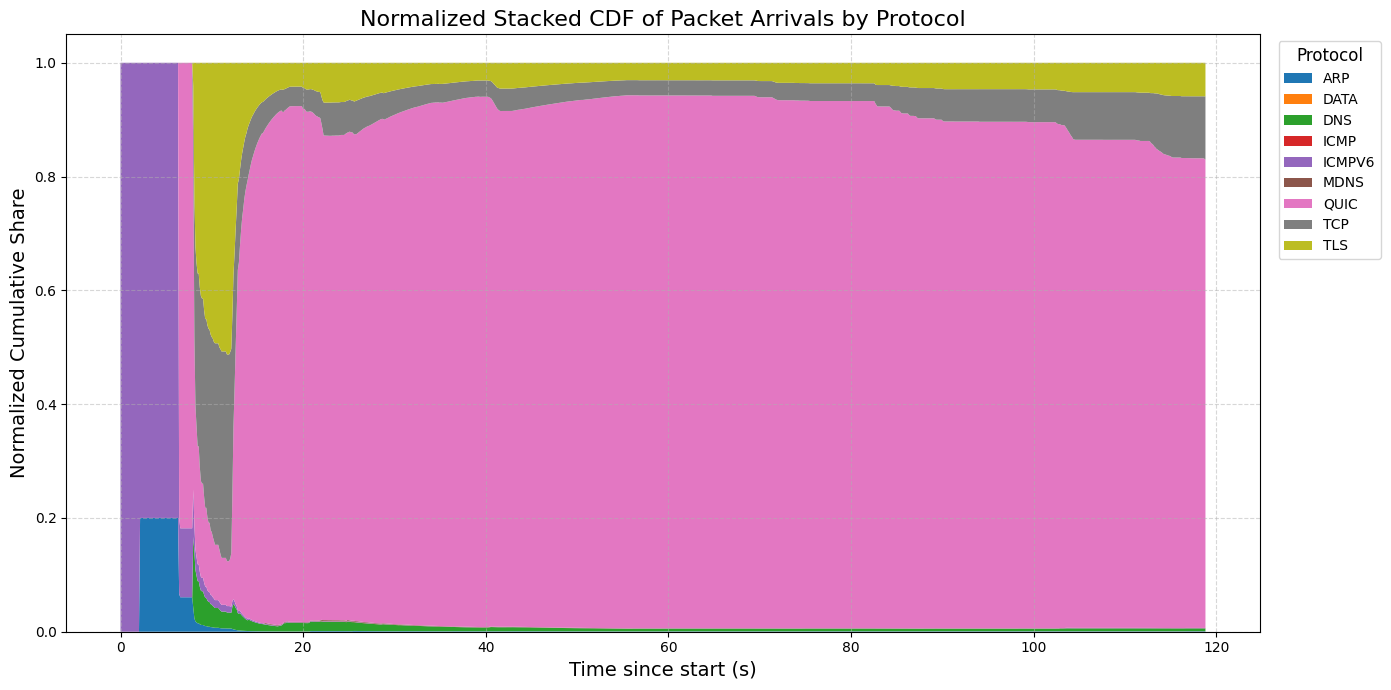

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_stacked_cdf(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked area chart showing the normalized cumulative distribution of packet arrivals
    across protocols. At each time bin, the total area sums to 1.0.

    Parameters:
        packets_by_protocol (dict): Mapping of protocol name -> list of Scapy packets
        bins (int): Number of time bins (resolution)
    """
    all_times = [pkt.time for pkts in packets_by_protocol.values() for pkt in pkts]
    if not all_times:
        raise ValueError("No packets found.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)
    protocols = sorted(packets_by_protocol.keys())

    # Histogram counts per bin per protocol
    per_protocol_counts = []
    for proto in protocols:
        times = [pkt.time for pkt in packets_by_protocol[proto]]
        counts, _ = np.histogram(times, bins=bin_edges)
        per_protocol_counts.append(counts)

    counts_matrix = np.vstack(per_protocol_counts)  # shape: (num_protocols, num_bins)
    cumulative_counts = np.cumsum(counts_matrix, axis=1)  # cumulative per protocol

    # Normalize at each time step: sum over protocols
    total_at_each_step = np.sum(cumulative_counts, axis=0)
    total_at_each_step[total_at_each_step == 0] = 1  # avoid division by zero
    normalized_cumulative = cumulative_counts / total_at_each_step

    x = bin_edges[:-1] - bin_edges[0]  # shift time to start at 0

    plt.figure(figsize=(14, 7), dpi=100)
    plt.stackplot(x, *normalized_cumulative, labels=protocols)
    plt.xlabel("Time since start (s)", fontsize=14)
    plt.ylabel("Normalized Cumulative Share", fontsize=14)
    plt.title("Normalized Stacked CDF of Packet Arrivals by Protocol", fontsize=16)
    plt.legend(title="Protocol", loc='upper left', bbox_to_anchor=(1.01, 1.0), fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('normalized_stacked_cdf_packet_arrival.png')
    plt.show()
    

plot_normalized_stacked_cdf(packetlist_by_protocol, bins=1000)

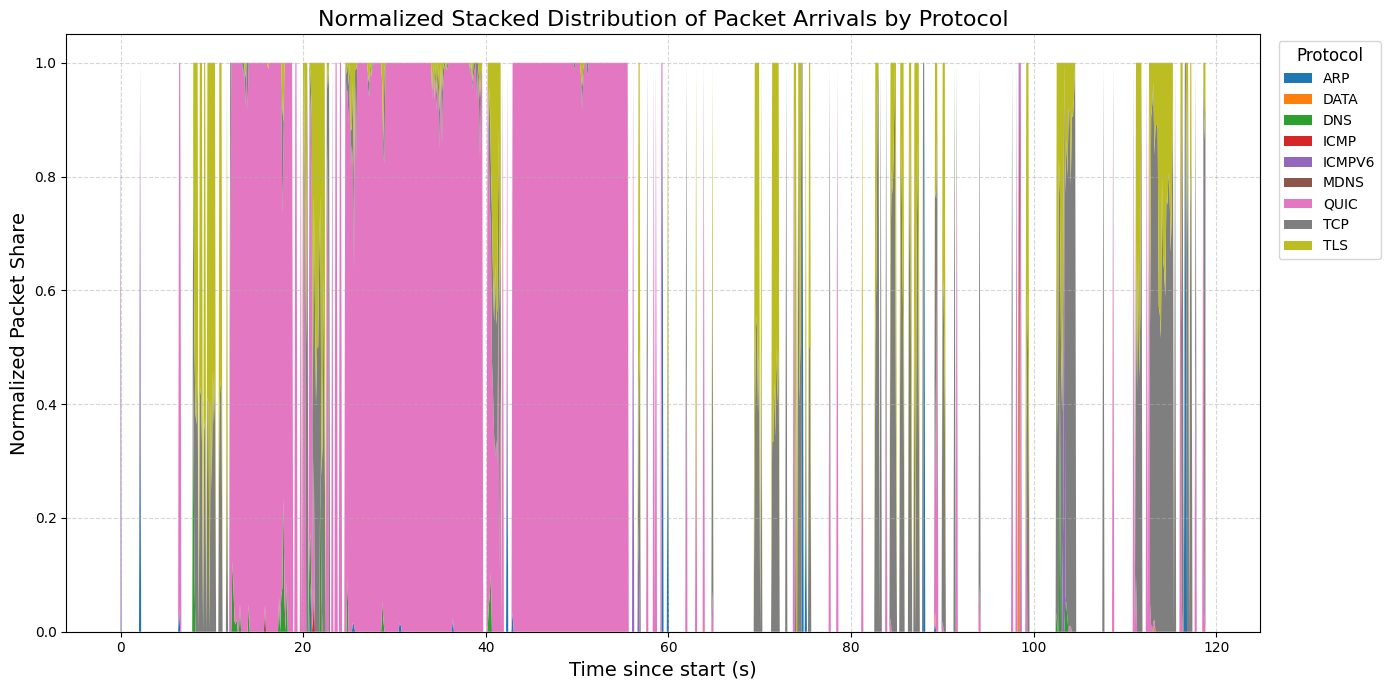

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_stacked_arrival_distribution(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked area chart showing the normalized per-bin distribution of packet arrivals
    across protocols. At each time bin, the total area sums to 1.0 (not cumulative).

    Parameters:
        packets_by_protocol (dict): Mapping of protocol name -> list of Scapy packets
        bins (int): Number of time bins (resolution)
    """
    all_times = [pkt.time for pkts in packets_by_protocol.values() for pkt in pkts]
    if not all_times:
        raise ValueError("No packets found.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)
    protocols = sorted(packets_by_protocol.keys())

    # Histogram counts per bin per protocol
    per_protocol_counts = []
    for proto in protocols:
        times = [pkt.time for pkt in packets_by_protocol[proto]]
        counts, _ = np.histogram(times, bins=bin_edges)
        per_protocol_counts.append(counts)

    counts_matrix = np.vstack(per_protocol_counts)  # shape: (num_protocols, num_bins)

    # Normalize per time bin (axis=0: per protocol, axis=1: per bin)
    total_counts_per_bin = np.sum(counts_matrix, axis=0)
    total_counts_per_bin[total_counts_per_bin == 0] = 1  # to avoid division by zero
    normalized_counts = counts_matrix / total_counts_per_bin

    x = bin_edges[:-1] - bin_edges[0]  # time axis starting from 0

    # Plot
    plt.figure(figsize=(14, 7), dpi=100)
    plt.stackplot(x, *normalized_counts, labels=protocols)
    plt.xlabel("Time since start (s)", fontsize=14)
    plt.ylabel("Normalized Packet Share", fontsize=14)
    plt.title("Normalized Stacked Distribution of Packet Arrivals by Protocol", fontsize=16)
    plt.legend(title="Protocol", loc='upper left', bbox_to_anchor=(1.01, 1.0), fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('normalized_stacked_arrival_distribution.png')
    plt.show()
plot_normalized_stacked_arrival_distribution(packetlist_by_protocol, bins=1000)

In [37]:
import plotly.graph_objects as go
import numpy as np

def plotly_normalized_stacked_cdf(packets_by_protocol: dict, bins=1000):
    """
    Plot a stacked area chart showing the normalized cumulative distribution of packet arrivals
    across protocols using Plotly. At each time bin, the total area sums to 1.0.
    """
    all_times = [pkt.time for pkts in packets_by_protocol.values() for pkt in pkts]
    if not all_times:
        raise ValueError("No packets found.")

    start = min(all_times)
    end = max(all_times)
    bin_edges = np.linspace(start, end, bins + 1)
    protocols = sorted(packets_by_protocol.keys())

    # Histogram counts per bin per protocol
    per_protocol_counts = []
    for proto in protocols:
        times = [pkt.time for pkt in packets_by_protocol[proto]]
        counts, _ = np.histogram(times, bins=bin_edges)
        per_protocol_counts.append(counts)

    counts_matrix = np.vstack(per_protocol_counts)
    cumulative_counts = np.cumsum(counts_matrix, axis=1)

    # Normalize at each time step: sum over protocols
    total_at_each_step = np.sum(cumulative_counts, axis=0)
    total_at_each_step[total_at_each_step == 0] = 1  # avoid division by zero
    normalized_cumulative = cumulative_counts / total_at_each_step

    x = bin_edges[:-1] - bin_edges[0]  # shift time to start at 0

    fig = go.Figure()
    for i, proto in enumerate(protocols):
        fig.add_trace(go.Scatter(
            x=x,
            y=normalized_cumulative[i],
            mode='lines',
            stackgroup='one',
            name=proto
        ))

    fig.update_layout(
        title="Temporal evolution of protocols in Packet Arraival (CDF)",
        xaxis_title="Time since start (s)",
        yaxis_title="Normalized Cumulative Share",
        legend_title="Protocol",
        template="plotly_white"
    )
    fig.show()
    
    fig.write_image("normalized_stacked_cdf.png")

plotly_normalized_stacked_cdf(packetlist_by_protocol, bins=1000)

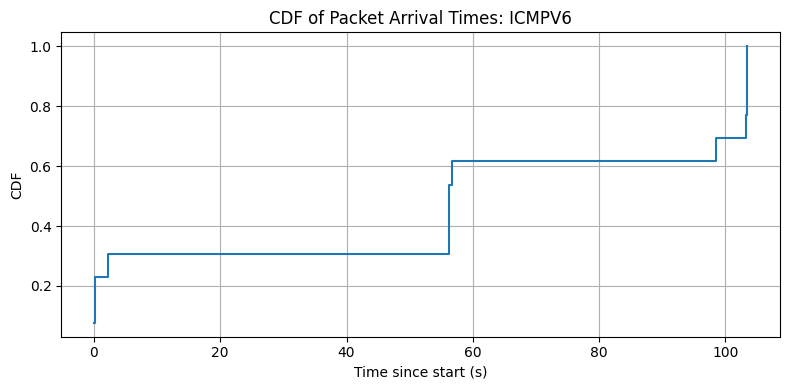

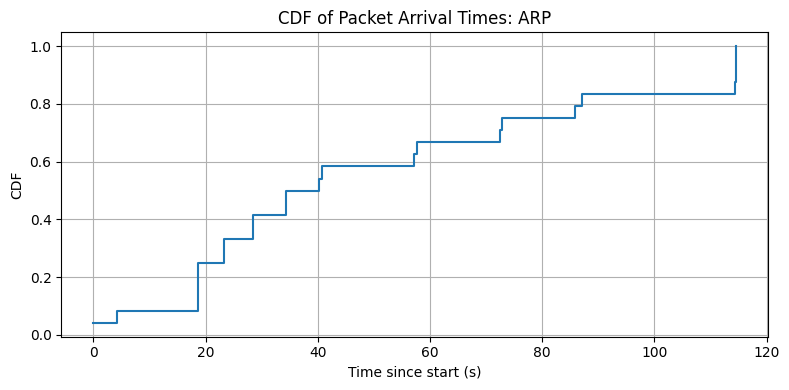

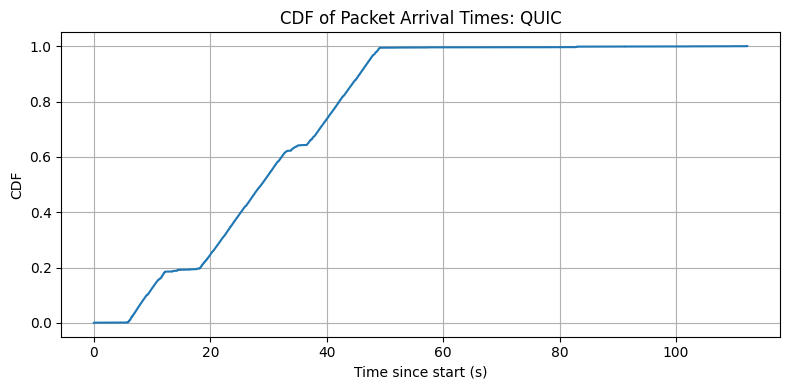

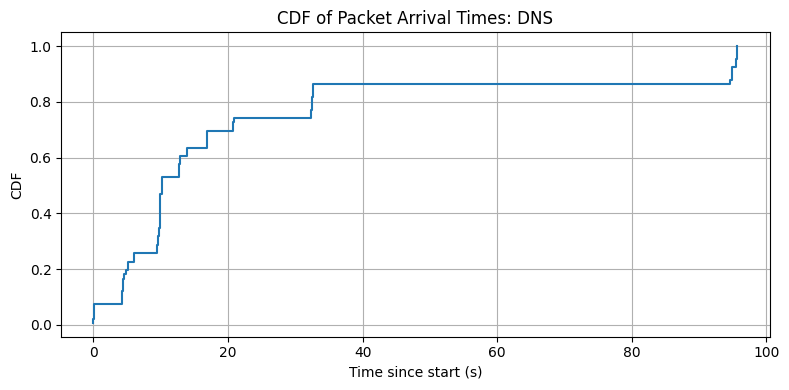

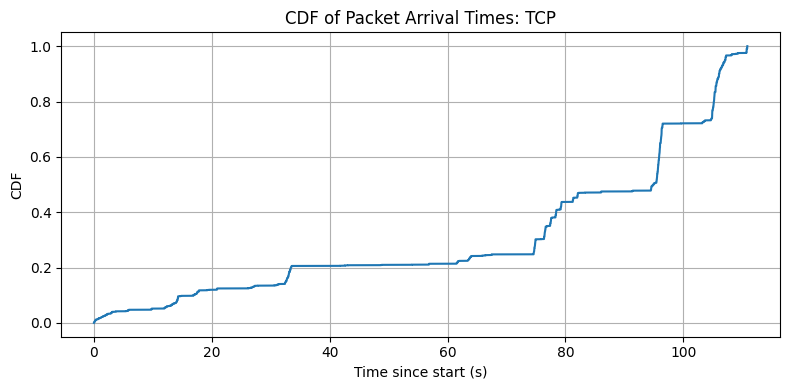

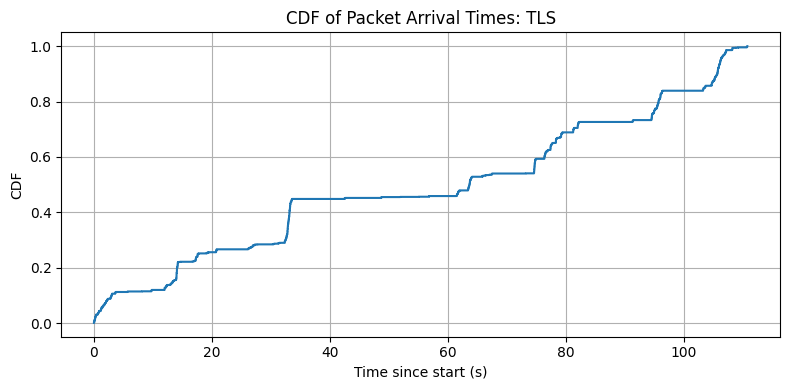

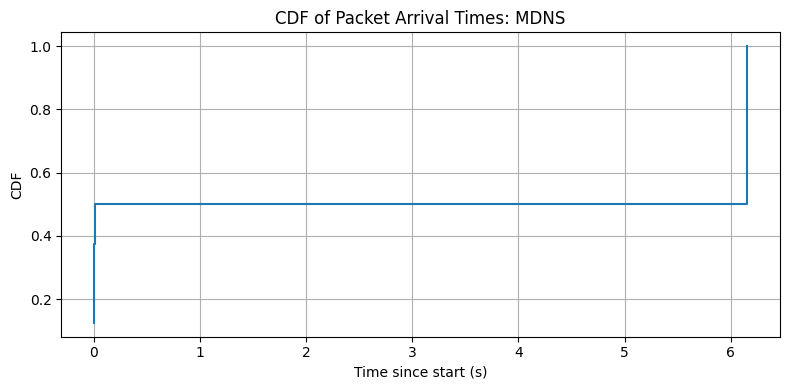

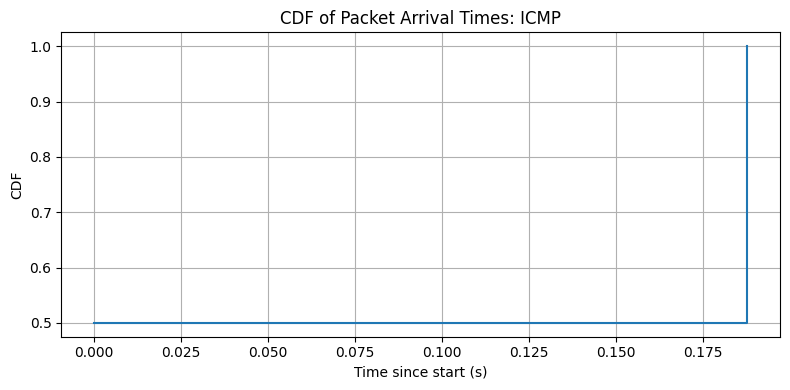

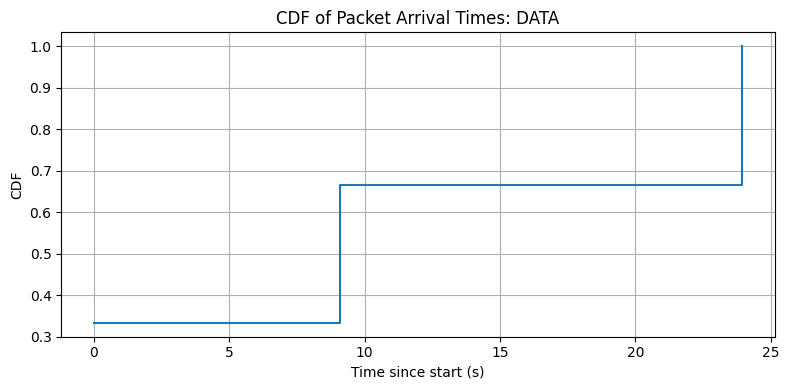

In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt

def plot_cdf_per_layer7_protocol_separate(packets_by_protocol, save_dir="cdf_layer7_protocols"):
    os.makedirs(save_dir, exist_ok=True)
    for proto, pkts in packets_by_protocol.items():
        if not pkts:
            continue
        times = np.array([pkt.time for pkt in pkts])
        times_sorted = np.sort(times)
        times_sorted = times_sorted - times_sorted[0]
        cdf = np.arange(1, len(times_sorted) + 1) / len(times_sorted)
        plt.figure(figsize=(8, 4))
        plt.step(times_sorted, cdf, where='post')
        plt.xlabel("Time since start (s)")
        plt.ylabel("CDF")
        plt.title(f"CDF of Packet Arrival Times: {proto}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"CDF_{proto}.png"))
        plt.show()

plot_cdf_per_layer7_protocol_separate(packetlist_by_protocol)


# Analyse the peers in general

In [39]:
from scapy.all import rdpcap, IP
from collections import defaultdict

def extract_peer_stats(packets):
    peer_stats = defaultdict(lambda: {'packets': 0, 'bytes': 0})

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            length = len(pkt)
            key = (src, dst)
            peer_stats[key]['packets'] += 1
            peer_stats[key]['bytes'] += length

    return peer_stats

def summarize_stats(peer_stats, top_n=20):
    sorted_peers = sorted(peer_stats.items(), key=lambda x: x[1]['bytes'], reverse=True)

    print(f"\nTop {top_n} Kommunikationspaare nach übertragenem Volumen:\n")
    print(f"{'Quelle':<20} {'Ziel':<20} {'Pakete':>8} {'Bytes':>12}")
    print("-" * 65)
    for (src, dst), stats in sorted_peers[:top_n]:
        print(f"{src:<20} {dst:<20} {stats['packets']:>8} {stats['bytes']:>12}")




In [40]:
stats = extract_peer_stats(processed_packets)
summarize_stats(stats)


Top 20 Kommunikationspaare nach übertragenem Volumen:

Quelle               Ziel                   Pakete        Bytes
-----------------------------------------------------------------
173.194.182.201      192.168.4.10             8993     11141522
142.250.186.110      192.168.4.10             2798      3315008
216.58.206.68        192.168.4.10             2070      2312289
129.187.254.73       192.168.4.10              896       991127
141.84.69.233        192.168.4.10              497       540870
192.168.4.10         173.194.182.201          4541       365128
142.250.186.86       192.168.4.10              229       300235
192.168.4.10         216.58.206.68            1404       169481
192.168.4.10         142.250.186.110          1544       147376
13.107.253.45        192.168.4.10              102       136066
17.248.248.101       192.168.4.10              317       134578
142.250.74.206       192.168.4.10              104       133395
142.250.186.163      192.168.4.10             

## mit internet traffic

In [41]:
from scapy.all import rdpcap, IP
from collections import defaultdict
import ipaddress

def is_in_subnet(ip, subnet="192.168.4.0/24"):
    try:
        return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
    except ValueError:
        return False  # z. B. bei fehlerhaften IPs

def analyze_subnet_traffic(packets, subnet="192.168.4.0/24"):
    host_stats = defaultdict(lambda: {'packets_sent': 0, 'packets_received': 0,
                                      'bytes_sent': 0, 'bytes_received': 0})

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            size = len(pkt)

            if is_in_subnet(src, subnet):
                host_stats[src]['packets_sent'] += 1
                host_stats[src]['bytes_sent'] += size

            if is_in_subnet(dst, subnet):
                host_stats[dst]['packets_received'] += 1
                host_stats[dst]['bytes_received'] += size

    return host_stats

def print_subnet_summary(stats, discription=""):
    print(f"\n {discription} \n")
    print(f"{'Host':<15} {'Pkt_Sent':>9} {'Pkt_Recv':>9} {'Bytes_Sent':>12} {'Bytes_Recv':>12}")
    print("-" * 65)
    for host, data in sorted(stats.items()):
        print(f"{host:<15} {data['packets_sent']:>9} {data['packets_received']:>9} "
              f"{data['bytes_sent']:>12} {data['bytes_received']:>12}")


stats = analyze_subnet_traffic(processed_packets, subnet="192.168.4.0/24")
print_subnet_summary(stats, discription="Communication statistic for Hosts with internet:")



 Communication statistic for Hosts with internet: 

Host             Pkt_Sent  Pkt_Recv   Bytes_Sent   Bytes_Recv
-----------------------------------------------------------------
192.168.4.1            66        66        10238         5400
192.168.4.10        10166     16987      1152902     19562711
192.168.4.4           173       140        49651        43068


In [42]:
def analyze_internal_traffic(packets, subnet="192.168.4.0/24"):
    host_stats = defaultdict(lambda: {'packets_sent': 0, 'packets_received': 0,
                                      'bytes_sent': 0, 'bytes_received': 0})

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            size = len(pkt)

            if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                host_stats[src]['packets_sent'] += 1
                host_stats[src]['bytes_sent'] += size

                host_stats[dst]['packets_received'] += 1
                host_stats[dst]['bytes_received'] += size

    return host_stats

stats_internal = analyze_internal_traffic(processed_packets)
print_subnet_summary(stats_internal, discription="Communication statistic for Hosts in the internal network:")


 Communication statistic for Hosts in the internal network: 

Host             Pkt_Sent  Pkt_Recv   Bytes_Sent   Bytes_Recv
-----------------------------------------------------------------
192.168.4.1            66        66        10238         5400
192.168.4.10           64        64         5244         9869
192.168.4.4             2         2          156          369


## vergleich intern vs extern

In [43]:
from scapy.all import rdpcap, IP
from collections import defaultdict
import ipaddress
import csv

def is_in_subnet(ip, subnet="192.168.4.0/24"):
    try:
        return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
    except ValueError:
        return False

def analyze_internal_external_traffic(packets, subnet="192.168.4.0/24"):
    host_stats = defaultdict(lambda: {
        'internal_sent': 0,
        'internal_received': 0,
        'external_sent': 0,
        'external_received': 0,
        'internal_packets_sent': 0,
        'internal_packets_received': 0,
        'external_packets_sent': 0,
        'external_packets_received': 0
    })

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            size = len(pkt)

            src_in = is_in_subnet(src, subnet)
            dst_in = is_in_subnet(dst, subnet)

            # Nur Hosts im Subnetz werden berücksichtigt
            if src_in:
                if dst_in:
                    host_stats[src]['internal_sent'] += size
                    host_stats[src]['internal_packets_sent'] += 1
                else:
                    host_stats[src]['external_sent'] += size
                    host_stats[src]['external_packets_sent'] += 1

            if dst_in:
                if src_in:
                    host_stats[dst]['internal_received'] += size
                    host_stats[dst]['internal_packets_received'] += 1
                else:
                    host_stats[dst]['external_received'] += size
                    host_stats[dst]['external_packets_received'] += 1

    return host_stats

def print_summary(stats):
    print(f"\nKommunikation pro Host (intern vs. extern):\n")
    print(f"{'Host':<15} {'Int_Sent':>10} {'Int_Recv':>10} {'Ext_Sent':>10} {'Ext_Recv':>10}")
    print("-" * 65)
    for host, data in sorted(stats.items()):
        print(f"{host:<15} {data['internal_sent']:>10} {data['internal_received']:>10} "
              f"{data['external_sent']:>10} {data['external_received']:>10}")

def export_to_csv(stats, output_file):
    with open(output_file, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Host",
            "Internal_Packets_Sent", "Internal_Packets_Received",
            "External_Packets_Sent", "External_Packets_Received",
            "Internal_Bytes_Sent", "Internal_Bytes_Received",
            "External_Bytes_Sent", "External_Bytes_Received"
        ])
        for host, d in sorted(stats.items()):
            writer.writerow([
                host,
                d['internal_packets_sent'], d['internal_packets_received'],
                d['external_packets_sent'], d['external_packets_received'],
                d['internal_sent'], d['internal_received'],
                d['external_sent'], d['external_received']
            ])
    print(f"\n→ CSV gespeichert als: {output_file}")


stats = analyze_internal_external_traffic(processed_packets, subnet="192.168.4.0/24")
print_summary(stats)
export_to_csv(stats, "subnet_comm_split.csv")



Kommunikation pro Host (intern vs. extern):

Host              Int_Sent   Int_Recv   Ext_Sent   Ext_Recv
-----------------------------------------------------------------
192.168.4.1          10238       5400          0          0
192.168.4.10          5244       9869    1147658   19552842
192.168.4.4            156        369      49495      42699

→ CSV gespeichert als: subnet_comm_split.csv


# Analyse the timing and the frequency 

In [44]:
from scapy.all import IP
from collections import defaultdict
from datetime import datetime
import statistics
import ipaddress

def is_in_subnet(ip, subnet="192.168.4.0/24"):
    try:
        return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
    except ValueError:
        return False

def analyze_peer_connection_timing(packets, subnet="192.168.4.0/24"):
    peer_times = defaultdict(list)

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                ts = float(pkt.time)
                peer = (src, dst)
                peer_times[peer].append(ts)

    peer_stats = {}

    for peer, times in peer_times.items():
        times.sort()
        deltas = [t2 - t1 for t1, t2 in zip(times, times[1:])]
        peer_stats[peer] = {
            'packet_count': len(times),
            'first_seen': datetime.fromtimestamp(times[0]),
            'last_seen': datetime.fromtimestamp(times[-1]),
            'duration': times[-1] - times[0] if len(times) > 1 else 0,
            'mean_interval': statistics.mean(deltas) if len(deltas) > 0 else None,
            'min_interval': min(deltas) if len(deltas) > 0 else None,
            'max_interval': max(deltas) if len(deltas) > 0 else None
        }

    return peer_stats


In [45]:

peer_stats = analyze_peer_connection_timing(processed_packets)

# Print a summary for top peers
for peer, stats in sorted(peer_stats.items(), key=lambda x: x[1]['packet_count'], reverse=True)[:10]:
    src, dst = peer
    print(f"{src} → {dst}")
    for k, v in stats.items():
        print(f"  {k}: {v}")
    print()


192.168.4.10 → 192.168.4.1
  packet_count: 64
  first_seen: 2025-07-08 10:20:17.300841
  last_seen: 2025-07-08 10:21:53.003381
  duration: 95.70254015922546
  mean_interval: 1.519087939035325
  min_interval: 0.0006663799285888672
  max_interval: 61.883655071258545

192.168.4.1 → 192.168.4.10
  packet_count: 64
  first_seen: 2025-07-08 10:20:17.302263
  last_seen: 2025-07-08 10:21:53.004636
  duration: 95.70237326622009
  mean_interval: 1.5190852899400016
  min_interval: 0.000362396240234375
  max_interval: 61.8838472366333

192.168.4.4 → 192.168.4.1
  packet_count: 2
  first_seen: 2025-07-08 10:20:30.147952
  last_seen: 2025-07-08 10:20:30.148722
  duration: 0.0007698535919189453
  mean_interval: 0.0007698535919189453
  min_interval: 0.0007698535919189453
  max_interval: 0.0007698535919189453

192.168.4.1 → 192.168.4.4
  packet_count: 2
  first_seen: 2025-07-08 10:20:30.148932
  last_seen: 2025-07-08 10:20:30.149453
  duration: 0.0005216598510742188
  mean_interval: 0.00052165985107421

In [46]:
import ipaddress

def is_in_subnet(ip, subnet="192.168.4.0/24"):
    try:
        return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
    except ValueError:
        return False

def filter_internal_peers(peer_stats, subnet="192.168.4.0/24"):
    return {
        peer: stats
        for peer, stats in peer_stats.items()
        if is_in_subnet(peer[0], subnet) and is_in_subnet(peer[1], subnet)
    }


In [47]:
import matplotlib.pyplot as plt

def plot_internal_traffic(peer_stats, top_n=10):
    internal_stats = filter_internal_peers(peer_stats, subnet="192.168.4.0/24")
    print(f"Found {len(internal_stats)} internal connections")
    top_peers = sorted(internal_stats.items(), key=lambda x: x[1]['packet_count'], reverse=True)[:top_n]

    # Use ipaddress_to_host if available, else fallback to IP
    def map_name(ip):
        return ipaddress_to_host[ip] if ip in ipaddress_to_host else ip

    labels = [f"{map_name(src)}→{map_name(dst)}" for (src, dst), _ in top_peers]
    counts = [stats['packet_count'] for _, stats in top_peers]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, counts, color='steelblue')
    plt.xlabel("Packet Count")
    plt.title(f"Top {top_n} Internal Connections in 192.168.4.0/24")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('internal_traffic_top_peers_idle.png')
    plt.show()


Found 4 internal connections


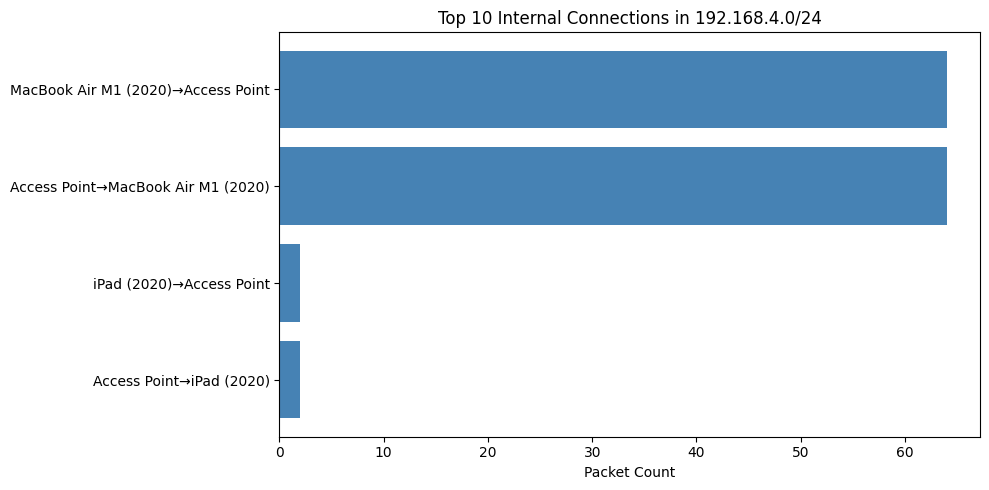

In [48]:
all_peer_stats = analyze_peer_connection_timing(processed_packets)
plot_internal_traffic(all_peer_stats, top_n=10)

In [49]:
def plot_intervals_for_internal_peers(packets, subnet="192.168.4.0/24", top_n=5):
    from collections import defaultdict
    from scapy.all import IP
    import numpy as np

    peer_times = defaultdict(list)

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                ts = pkt.time
                peer_times[(src, dst)].append(ts)

    plt.figure(figsize=(10, 6))
    for i, (peer, timestamps) in enumerate(sorted(peer_times.items(), key=lambda x: len(x[1]), reverse=True)[:top_n]):
        timestamps.sort()
        if len(timestamps) < 2:
            continue
        start_time = timestamps[0]
        normalized = [t - start_time for t in timestamps]
        deltas = np.diff(normalized)
        plt.plot(normalized[1:], deltas, label=f"{peer[0]}→{peer[1]}", alpha=0.7)

    plt.xlabel("Time Since First Packet (s)")
    plt.ylabel("Inter-packet Interval (s)")
    plt.title(f"Inter-arrival Times for Top {top_n} Internal Peers")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [50]:
def plot_peer_activity_over_time(packets, subnet="192.168.4.0/24", top_n=3, bin_size=10):
    from collections import defaultdict
    from scapy.all import IP
    import numpy as np

    peer_times = defaultdict(list)

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                ts = pkt.time
                peer_times[(src, dst)].append(ts)

    plt.figure(figsize=(10, 6))
    for peer, times in sorted(peer_times.items(), key=lambda x: len(x[1]), reverse=True)[:top_n]:
        times.sort()
        if len(times) < 2:
            continue
        start_time = times[0]
        normalized = [t - start_time for t in times]
        end = int(max(normalized))
        bins = list(range(0, end + bin_size, bin_size))
        counts, _ = np.histogram(normalized, bins=bins)
        midpoints = [(bins[i] + bins[i+1])/2 for i in range(len(counts))]
        plt.plot(midpoints, counts, label=f"{peer[0]}→{peer[1]}", marker='o')

    plt.xlabel(f"Time Since Start (s)")
    plt.ylabel(f"Packets per {bin_size}s")
    plt.title(f"Peer Communication Over Time (Normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


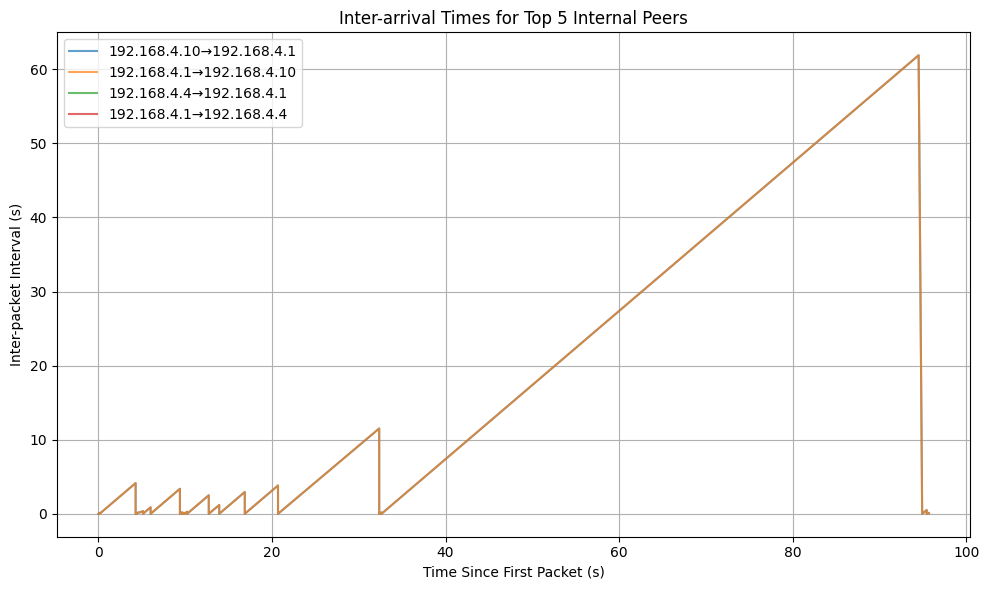

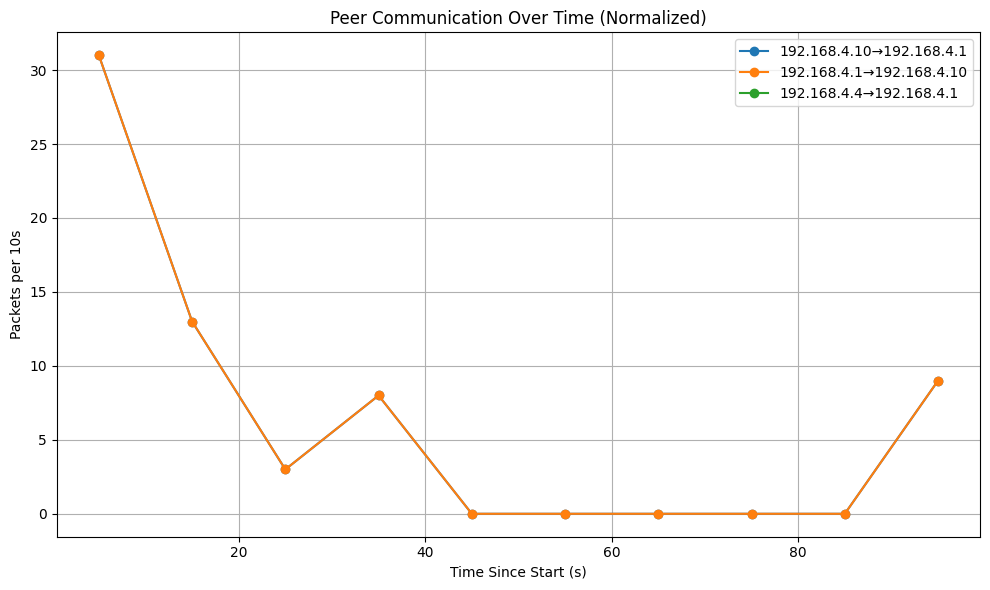

In [51]:
plot_intervals_for_internal_peers(processed_packets)
plot_peer_activity_over_time(processed_packets)

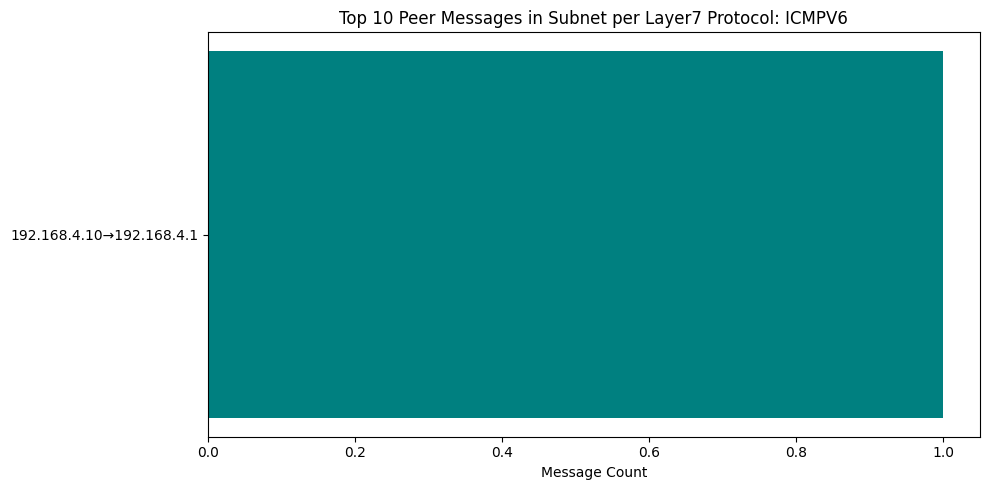

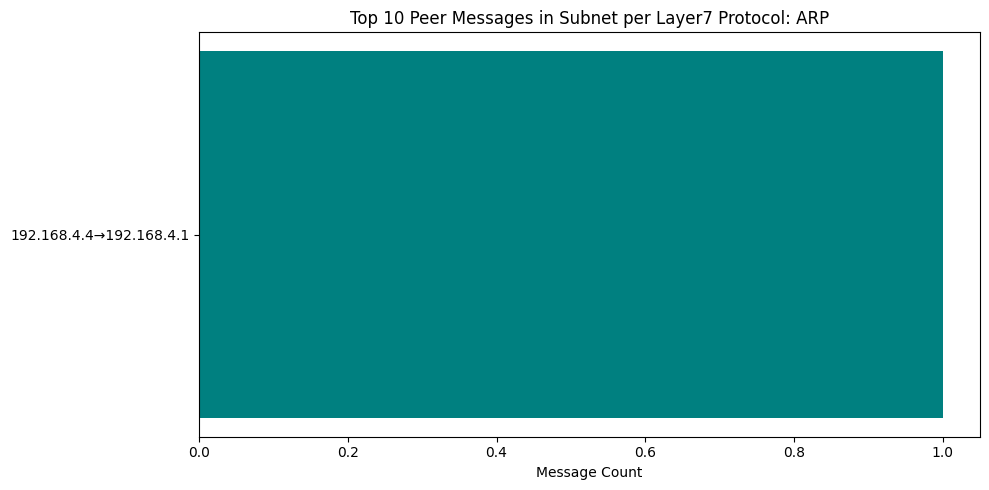

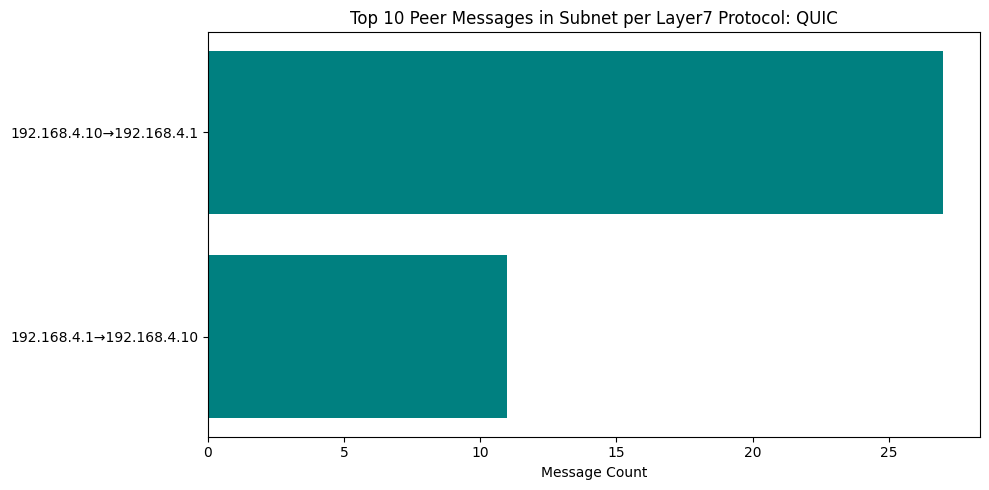

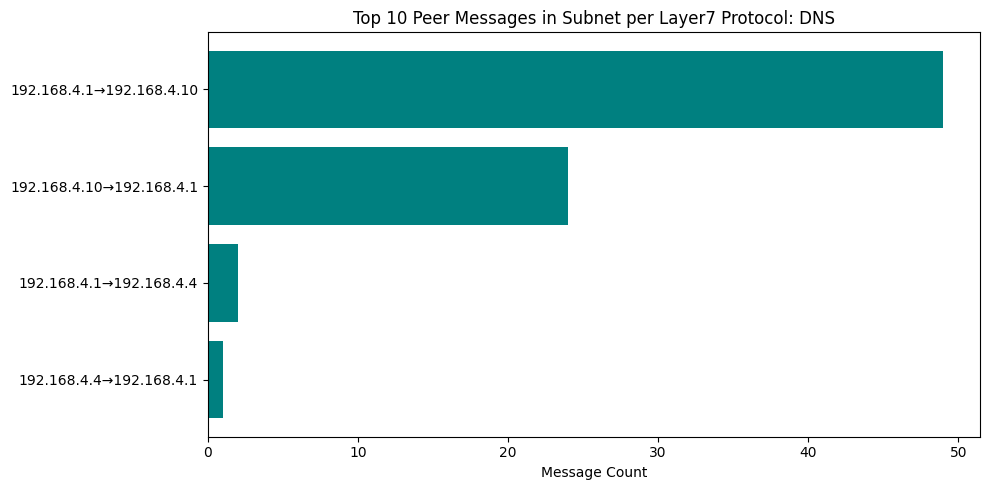

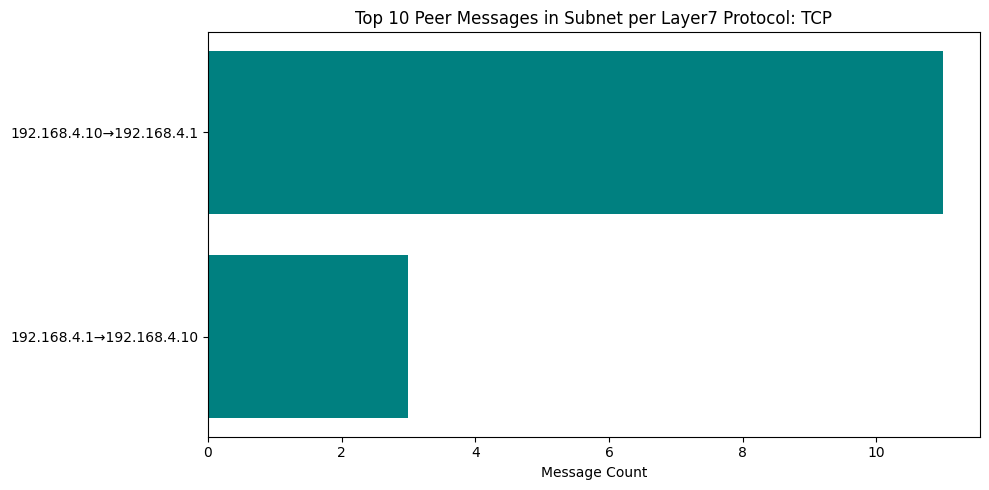

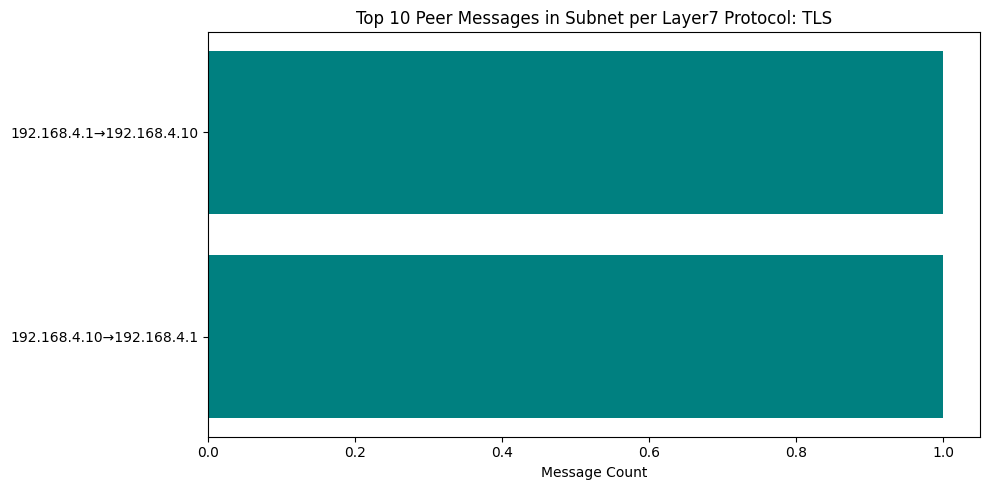

In [52]:
import ipaddress
from scapy.all import IP
from collections import Counter

import matplotlib.pyplot as plt

def plot_peer_messages_by_layer7_protocol(packetlist_by_protocol, subnet="192.168.4.0/24", top_n=10):

    def is_in_subnet(ip, subnet):
        try:
            return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
        except Exception:
            return False

    protocol_peer_counts = {}

    for proto, packets in packetlist_by_protocol.items():
        peer_counter = Counter()
        for pkt in packets:
            if IP in pkt:
                src = pkt[IP].src
                dst = pkt[IP].dst
                if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                    peer_counter[(src, dst)] += 1
        if peer_counter:
            protocol_peer_counts[proto] = peer_counter

    # Plot for each protocol
    for proto, peer_counter in protocol_peer_counts.items():
        top_peers = peer_counter.most_common(top_n)
        if not top_peers:
            continue
        labels = [f"{src}→{dst}" for (src, dst), _ in top_peers]
        counts = [count for _, count in top_peers]
        plt.figure(figsize=(10, 5))
        plt.barh(labels, counts, color='teal')
        plt.xlabel("Message Count")
        plt.title(f"Top {top_n} Peer Messages in Subnet per Layer7 Protocol: {proto}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

plot_peer_messages_by_layer7_protocol(packetlist_by_protocol, subnet="192.168.4.0/24", top_n=10)

In [53]:
from scapy.all import IP
from collections import defaultdict
import ipaddress
import numpy as np

def is_in_subnet(ip, subnet="192.168.4.0/24"):
    try:
        return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
    except ValueError:
        return False

def detect_periodic_internal_patterns(packets, subnet="192.168.4.0/24",
                                      min_samples=5, stddev_threshold=0.5):
    peer_times = defaultdict(list)

    for pkt in packets:
        if IP in pkt:
            src = pkt[IP].src
            dst = pkt[IP].dst
            if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                peer = (src, dst)
                peer_times[peer].append(float(pkt.time))  # ← FIXED HERE

    periodic_peers = []

    for peer, times in peer_times.items():
        if len(times) < min_samples:
            continue
        times.sort()
        deltas = np.diff(times)
        std = np.std(deltas)
        mean = np.mean(deltas)

        if std < stddev_threshold and mean > 1.0:
            periodic_peers.append({
                'peer': peer,
                'count': int(len(times)),
                'mean_interval': float(round(mean, 2)),
                'stddev': float(round(std, 3)),
            })

    return periodic_peers



periodic = detect_periodic_internal_patterns(
    packets,
    subnet="192.168.4.0/24",
    min_samples=3,
    stddev_threshold=5.0  # ← much looser
)


print("\n🕒 Periodic Internal Communication Detected:")
for p in periodic:
    src, dst = p['peer']
    print(f"{src} → {dst} | {p['count']} packets | every ~{p['mean_interval']}s | stddev: {p['stddev']}")


🕒 Periodic Internal Communication Detected:


# analyse encryption fraction

In [54]:
from scapy.all import rdpcap, TCP, UDP
from collections import Counter

# Define ports by traffic type
ENCRYPTED_PORTS = {
    443,     # HTTPS (TCP), QUIC (UDP)
    853      # DNS-over-TLS
}

UNENCRYPTED_PORTS = {
    80,      # HTTP
    53,      # DNS
    123,     # NTP
    67, 68   # DHCP
}


def classify_packet(pkt):
    if TCP in pkt:
        sport = pkt[TCP].sport
        dport = pkt[TCP].dport
        if sport in ENCRYPTED_PORTS or dport in ENCRYPTED_PORTS:
            return "encrypted"
        elif sport in UNENCRYPTED_PORTS or dport in UNENCRYPTED_PORTS:
            return "unencrypted"
        else:
            return "unknown_tcp"
    elif UDP in pkt:
        sport = pkt[UDP].sport
        dport = pkt[UDP].dport
        if sport in ENCRYPTED_PORTS or dport in ENCRYPTED_PORTS:
            return "encrypted"
        elif sport in UNENCRYPTED_PORTS or dport in UNENCRYPTED_PORTS:
            return "unencrypted"
        else:
            return "unknown_udp"
    else:
        return "non_tcp_udp"

def analyze_encryption_proportion(packets):
    
    counter = Counter()

    for pkt in packets:
        category = classify_packet(pkt)
        counter[category] += 1

    total_classified = counter["encrypted"] + counter["unencrypted"]
    total = sum(counter.values())

    print("\n📊 Traffic Classification Summary:")
    for k in ["encrypted", "unencrypted", "unknown_tcp", "unknown_udp", "non_tcp_udp"]:
        print(f"{k:<15}: {counter[k]} packets")

    if total_classified > 0:
        encrypted_ratio = counter["encrypted"] / total_classified * 100
        print(f"\n🔒 Proportion of Encrypted Traffic (classified only): {encrypted_ratio:.2f}%")
    else:
        print("\n⚠️ No classified encrypted/unencrypted traffic found.")

    print(f"\n📦 Total packets analyzed: {total}")


analyze_encryption_proportion(processed_packets)



📊 Traffic Classification Summary:
encrypted      : 27257 packets
unencrypted    : 132 packets
unknown_tcp    : 73 packets
unknown_udp    : 9 packets
non_tcp_udp    : 39 packets

🔒 Proportion of Encrypted Traffic (classified only): 99.52%

📦 Total packets analyzed: 27510


In [55]:
protocol_encryption_stats = {}

for proto, pkts in packetlist_by_protocol.items():
    encrypted = 0
    unencrypted = 0
    unknown_tcp = 0
    unknown_udp = 0
    non_tcp_udp = 0
    for pkt in pkts:
        category = classify_packet(pkt)
        if category == "encrypted":
            encrypted += 1
        elif category == "unencrypted":
            unencrypted += 1
        elif category == "unknown_tcp":
            unknown_tcp += 1
        elif category == "unknown_udp":
            unknown_udp += 1
        elif category == "non_tcp_udp":
            non_tcp_udp += 1
    total_classified = encrypted + unencrypted
    percent_encrypted = (encrypted / total_classified * 100) if total_classified > 0 else None
    protocol_encryption_stats[proto] = {
        "encrypted": encrypted,
        "unencrypted": unencrypted,
        "unknown_tcp": unknown_tcp,
        "unknown_udp": unknown_udp,
        "non_tcp_udp": non_tcp_udp,
        "percent_encrypted": percent_encrypted
    }

for proto, stats in protocol_encryption_stats.items():
    if stats['percent_encrypted'] is not None:
        print(f"{proto}: {stats['encrypted']} encrypted, {stats['unencrypted']} unencrypted, "
              f"{stats['percent_encrypted']:.2f}% encrypted")
    else:
        print(f"{proto}: No classified encrypted/unencrypted packets "
              f"(unknown_tcp={stats['unknown_tcp']}, unknown_udp={stats['unknown_udp']}, non_tcp_udp={stats['non_tcp_udp']})")


ICMPV6: 2 encrypted, 1 unencrypted, 66.67% encrypted
ARP: 11 encrypted, 1 unencrypted, 91.67% encrypted
QUIC: 22569 encrypted, 38 unencrypted, 99.83% encrypted
DNS: 56 encrypted, 76 unencrypted, 42.42% encrypted
TCP: 3016 encrypted, 14 unencrypted, 99.54% encrypted
TLS: 1596 encrypted, 2 unencrypted, 99.87% encrypted
MDNS: 3 encrypted, 0 unencrypted, 100.00% encrypted
ICMP: 2 encrypted, 0 unencrypted, 100.00% encrypted
DATA: 2 encrypted, 0 unencrypted, 100.00% encrypted


In [56]:
from math import sqrt
from scapy.all import rdpcap, Raw
from string import printable

def has_printable_strings(raw_bytes, min_length=4):
    return encrypted(raw_bytes) 
    # try:
    #     decoded = raw_bytes.decode('ascii', errors='ignore')
    #     substrings = [s for s in decoded.split() if all(c in printable for c in s)]
    #     return any(len(s) >= min_length for s in substrings)
    # except:
    #     return False
def encrypted(text):
    scores = defaultdict(lambda: 0)
    for letter in text: scores[letter] += 1
    largest = max(scores.values())
    average = len(text) / 256.0
    return largest < average + 5 * sqrt(average)

def analyze_payload_readability(packets):
    from collections import Counter
    results = Counter()

    for pkt in packets:
        if Raw in pkt:
            payload = bytes(pkt[Raw].load)
            if has_printable_strings(payload):
                results["readable"] += 1
            else:
                results["non_readable"] += 1
        else:
            results["no_payload"] += 1

    total_with_payload = results["readable"] + results["non_readable"]
    print("\n🧾 Payload Readability Analysis:")
    print(f"Packets with readable strings (likely unencrypted): {results['readable']}")
    print(f"Packets with unreadable payloads (likely encrypted): {results['non_readable']}")
    print(f"Packets with no payload: {results['no_payload']}")
    if total_with_payload > 0:
        ratio = results["readable"] / total_with_payload * 100
        print(f"→ Estimated Unencrypted Payload Ratio: {ratio:.2f}%")

analyze_payload_readability(processed_packets)


🧾 Payload Readability Analysis:
Packets with readable strings (likely unencrypted): 17799
Packets with unreadable payloads (likely encrypted): 7519
Packets with no payload: 2192
→ Estimated Unencrypted Payload Ratio: 70.30%


{'dns': {'dst_ips': {'192.168.4.10', '192.168.4.4', '192.168.4.1'},
         'queries': 66,
         'query_names': Counter({'mask.apple-dns.net.': 3,
                                 'clients1.google.com.': 2,
                                 'clients.l.google.com.': 2,
                                 'smoot-api-safari-aeun1a.v.aaplimg.com.': 2,
                                 'lh3.google.com.': 2,
                                 'lh3.googleusercontent.com.': 2,
                                 'ogads-pa.clients6.google.com.': 2,
                                 'play.google.com.': 2,
                                 'www.youtube.com.': 2,
                                 'static.doubleclick.net.': 2,
                                 'i.ytimg.com.': 2,
                                 'jnn-pa.googleapis.com.': 2,
                                 'accounts.google.com.': 2,
                                 'ogs.google.com.': 2,
                                 'www.gstatic.com.': 2,


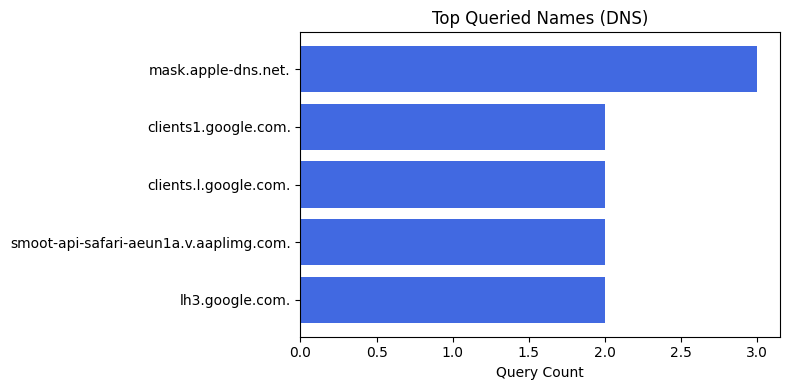

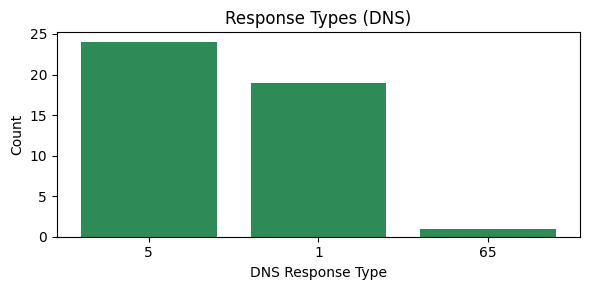


🔎 MDNS Traffic:
Queries     : 8
Responses   : 0
Unique Src IPs: 2
Unique Dst IPs: 1
Multicast Packets: 4

Top Queried Names:
  lb._dns-sd._udp.local. — 4x
  _companion-link._tcp.local. — 4x

Response Types:


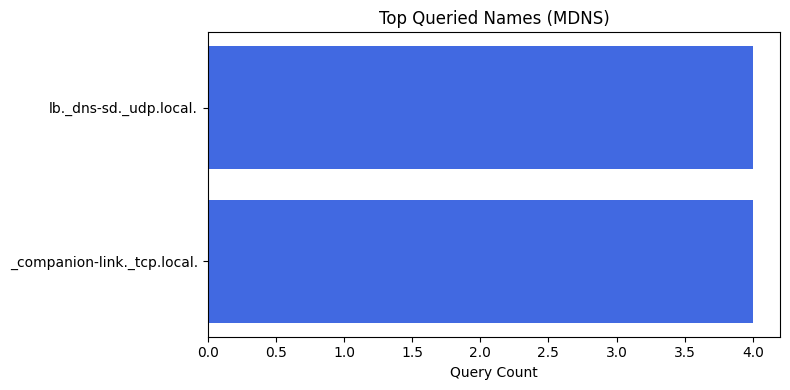

In [57]:
from scapy.all import DNS, IP, UDP
from collections import Counter
import pprint
from collections import Counter, defaultdict
def analyze_dns_mdns(packets):
    """
    Analyze DNS and mDNS traffic in the given packets.
    Returns a dict with stats for 'dns' and 'mdns'.
    """

    stats = {
        'dns': {
            'queries': 0,
            'responses': 0,
            'src_ips': set(),
            'dst_ips': set(),
            'query_names': Counter(),
            'response_types': Counter(),
        },
        'mdns': {
            'queries': 0,
            'responses': 0,
            'src_ips': set(),
            'dst_ips': set(),
            'query_names': Counter(),
            'response_types': Counter(),
            'multicast': 0,
        }
    }

    for pkt in packets:
        if DNS in pkt and UDP in pkt:
            dport = pkt[UDP].dport
            sport = pkt[UDP].sport
            proto = None
            # mDNS uses port 5353, DNS uses 53
            if dport == 5353 or sport == 5353:
                proto = 'mdns'
            elif dport == 53 or sport == 53:
                proto = 'dns'
            if proto:
                # Source/dest IPs
                if IP in pkt:
                    stats[proto]['src_ips'].add(pkt[IP].src)
                    stats[proto]['dst_ips'].add(pkt[IP].dst)
                    # mDNS multicast detection
                    if proto == 'mdns' and (pkt[IP].dst.startswith('224.') or pkt[IP].dst.startswith('ff02')):
                        stats['mdns']['multicast'] += 1
                # Query/response
                dns = pkt[DNS]
                if dns.qr == 0:
                    stats[proto]['queries'] += 1
                    # Query name(s)
                    if hasattr(dns, 'qd') and dns.qd is not None:
                        try:
                            qname = dns.qd.qname.decode(errors='ignore') if hasattr(dns.qd, 'qname') else str(dns.qd)
                            stats[proto]['query_names'][qname] += 1
                        except Exception:
                            pass
                else:
                    stats[proto]['responses'] += 1
                    # Response type(s)
                    if hasattr(dns, 'an') and dns.ancount > 0:
                        ans = dns.an
                        # There may be multiple answers
                        for i in range(dns.ancount):
                            try:
                                rtype = ans.type if hasattr(ans, 'type') else None
                                if rtype is not None:
                                    stats[proto]['response_types'][rtype] += 1
                                ans = ans.payload
                            except Exception:
                                break

    return stats

import matplotlib.pyplot as plt

# Analyze DNS/mDNS stats
dns_mdns_stats = analyze_dns_mdns(processed_packets)

# Pretty print the raw stats
pprint.pprint(dns_mdns_stats)

# Detailed print and plots (as in cell 71)
for proto in ['dns', 'mdns']:
    print(f"\n🔎 {proto.upper()} Traffic:")
    print(f"Queries     : {dns_mdns_stats[proto]['queries']}")
    print(f"Responses   : {dns_mdns_stats[proto]['responses']}")
    print(f"Unique Src IPs: {len(dns_mdns_stats[proto]['src_ips'])}")
    print(f"Unique Dst IPs: {len(dns_mdns_stats[proto]['dst_ips'])}")

    if proto == 'mdns':
        print(f"Multicast Packets: {dns_mdns_stats['mdns']['multicast']}")

    print("\nTop Queried Names:")
    for name, count in dns_mdns_stats[proto]['query_names'].most_common(5):
        print(f"  {name} — {count}x")

    print("\nResponse Types:")
    for rtype, count in dns_mdns_stats[proto]['response_types'].most_common():
        print(f"  Type {rtype} — {count}x")

    # Plot top queried names
    top_queries = dns_mdns_stats[proto]['query_names'].most_common(5)
    if top_queries:
        labels, counts = zip(*top_queries)
        plt.figure(figsize=(8, 4))
        plt.barh(labels, counts, color='royalblue')
        plt.xlabel("Query Count")
        plt.title(f"Top Queried Names ({proto.upper()})")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"top_queried_names_{proto}.png")
        plt.show()

    # Plot response types
    top_types = dns_mdns_stats[proto]['response_types'].most_common()
    if top_types:
        type_labels = [str(t[0]) for t in top_types]
        type_counts = [t[1] for t in top_types]
        plt.figure(figsize=(6, 3))
        plt.bar(type_labels, type_counts, color='seagreen')
        plt.xlabel("DNS Response Type")
        plt.ylabel("Count")
        plt.title(f"Response Types ({proto.upper()})")
        plt.tight_layout()
        plt.savefig(f"response_types_{proto}.png")
        plt.show()



🔎 DNS Traffic:
Queries     : 66
Responses   : 66
Unique Src IPs: 3
Unique Dst IPs: 3

Top Queried Names:
  mask.apple-dns.net. — 3x
  clients1.google.com. — 2x
  clients.l.google.com. — 2x
  smoot-api-safari-aeun1a.v.aaplimg.com. — 2x
  lh3.google.com. — 2x

Response Types:
  Type 1 — 91x
  Type 5 — 34x
  Type 65 — 5x


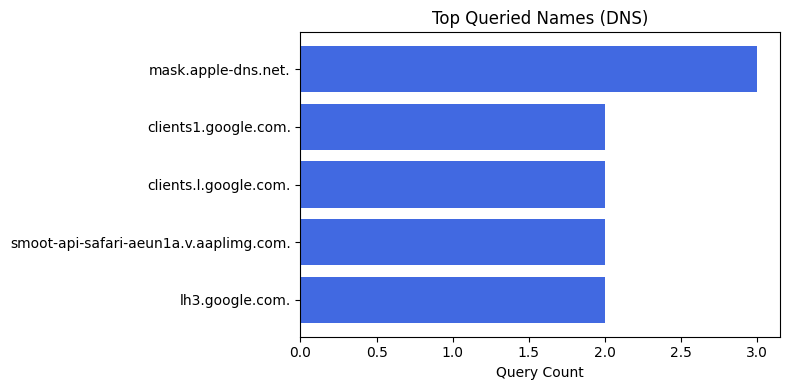

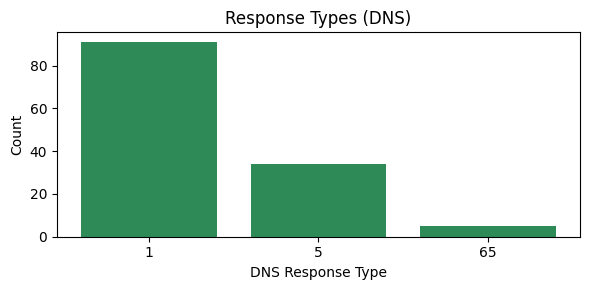


🔎 MDNS Traffic:
Queries     : 8
Responses   : 0
Unique Src IPs: 2
Unique Dst IPs: 1
Multicast Packets: 4

Top Queried Names:
  lb._dns-sd._udp.local. — 4x
  _companion-link._tcp.local. — 4x

Response Types:


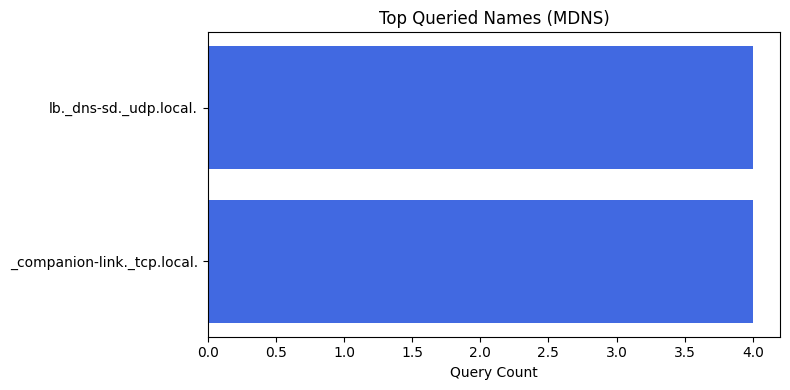

In [58]:
from scapy.all import DNS, DNSQR, DNSRR, IP, UDP
from collections import defaultdict, Counter

def analyze_dns_mdns(packets):
    dns_stats = {
        'dns': {
            'queries': 0,
            'responses': 0,
            'query_names': Counter(),
            'response_types': Counter(),
            'src_ips': set(),
            'dst_ips': set(),
        },
        'mdns': {
            'queries': 0,
            'responses': 0,
            'query_names': Counter(),
            'response_types': Counter(),
            'multicast': 0,
            'src_ips': set(),
            'dst_ips': set(),
        }
    }

    for pkt in packets:
        if not pkt.haslayer(DNS):
            continue
        dns_layer = pkt[DNS]
        ip_layer = pkt[IP] if IP in pkt else None

        is_mdns = False
        if pkt.haslayer(UDP):
            dport = pkt[UDP].dport
            sport = pkt[UDP].sport
            if 5353 in (dport, sport):
                is_mdns = True

        category = 'mdns' if is_mdns else 'dns'
        stats = dns_stats[category]

        # Direction
        if dns_layer.qr == 0:
            stats['queries'] += 1
            if dns_layer.qdcount > 0 and dns_layer.qd:
                stats['query_names'][dns_layer.qd.qname.decode(errors="ignore")] += 1
        else:
            stats['responses'] += 1
            for i in range(dns_layer.ancount):
                try:
                    ans = dns_layer.an[i]
                    stats['response_types'][ans.type] += 1
                except IndexError:
                    pass

        # IPs
        if ip_layer:
            stats['src_ips'].add(ip_layer.src)
            stats['dst_ips'].add(ip_layer.dst)

        # mDNS-specific: multicast destination check
        if is_mdns and ip_layer:
            if ip_layer.dst.startswith("224.") or ip_layer.dst.lower().startswith("ff02::"):
                stats['multicast'] += 1

    return dns_stats




dns_stats = analyze_dns_mdns(processed_packets)

import matplotlib.pyplot as plt

for proto in ['dns', 'mdns']:
    print(f"\n🔎 {proto.upper()} Traffic:")
    print(f"Queries     : {dns_stats[proto]['queries']}")
    print(f"Responses   : {dns_stats[proto]['responses']}")
    print(f"Unique Src IPs: {len(dns_stats[proto]['src_ips'])}")
    print(f"Unique Dst IPs: {len(dns_stats[proto]['dst_ips'])}")

    if proto == 'mdns':
        print(f"Multicast Packets: {dns_stats['mdns']['multicast']}")

    print("\nTop Queried Names:")
    for name, count in dns_stats[proto]['query_names'].most_common(5):
        print(f"  {name} — {count}x")

    print("\nResponse Types:")
    for rtype, count in dns_stats[proto]['response_types'].most_common():
        print(f"  Type {rtype} — {count}x")

    # Plot top queried names
    top_queries = dns_stats[proto]['query_names'].most_common(5)
    if top_queries:
        labels, counts = zip(*top_queries)
        plt.figure(figsize=(8, 4))
        plt.barh(labels, counts, color='royalblue')
        plt.xlabel("Query Count")
        plt.title(f"Top Queried Names ({proto.upper()})")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"top_queried_names_{proto}.png")
        plt.show()

    # Plot response types
    top_types = dns_stats[proto]['response_types'].most_common()
    if top_types:
        type_labels = [str(t[0]) for t in top_types]
        type_counts = [t[1] for t in top_types]
        plt.figure(figsize=(6, 3))
        plt.bar(type_labels, type_counts, color='seagreen')
        plt.xlabel("DNS Response Type")
        plt.ylabel("Count")
        plt.title(f"Response Types ({proto.upper()})")
        plt.tight_layout()
        plt.savefig(f"response_types_{proto}.png")
        plt.show()


In [59]:
from scapy.all import ARP
from collections import defaultdict, Counter

def analyze_arp(packets):
    stats = {
        'total': 0,
        'requests': 0,
        'replies': 0,
        'request_pairs': Counter(),      # who is asking for whom
        'target_ips': Counter(),         # requested IPs
        'mac_ip_mapping': defaultdict(set),  # passive mapping: MAC → IPs
        'ip_mac_mapping': defaultdict(set),  # reverse: IP → MACs
    }

    for pkt in packets:
        if not pkt.haslayer(ARP):
            continue
        arp = pkt[ARP]
        stats['total'] += 1

        if arp.op == 1:  # who-has (request)
            stats['requests'] += 1
            stats['request_pairs'][(arp.psrc, arp.pdst)] += 1
            stats['target_ips'][arp.pdst] += 1
        elif arp.op == 2:  # is-at (reply)
            stats['replies'] += 1
            stats['mac_ip_mapping'][arp.hwsrc].add(arp.psrc)
            stats['ip_mac_mapping'][arp.psrc].add(arp.hwsrc)

    return stats

arp_stats = analyze_arp(processed_packets)

print("\n📡 ARP Analysis:")
print(f"Total ARP Packets : {arp_stats['total']}")
print(f"Requests          : {arp_stats['requests']}")
print(f"Replies           : {arp_stats['replies']}")

print("\n🔍 Top ARP Requests:")
for (src, dst), count in arp_stats['request_pairs'].most_common(5):
    print(f"  {src} → {dst} : {count}x")

print("\n🎯 Most Queried IPs:")
for ip, count in arp_stats['target_ips'].most_common(5):
    print(f"  {ip} : {count}x")

print("\n🧭 Observed MAC ↔ IP Mappings:")
for mac, ips in arp_stats['mac_ip_mapping'].items():
    ip_list = ", ".join(ips)
    print(f"  {mac} → {ip_list}")


📡 ARP Analysis:
Total ARP Packets : 24
Requests          : 12
Replies           : 12

🔍 Top ARP Requests:
  192.168.4.1 → 192.168.4.10 : 5x
  192.168.4.4 → 192.168.4.1 : 3x
  192.168.4.1 → 192.168.4.4 : 3x
  192.168.4.10 → 192.168.4.1 : 1x

🎯 Most Queried IPs:
  192.168.4.10 : 5x
  192.168.4.1 : 4x
  192.168.4.4 : 3x

🧭 Observed MAC ↔ IP Mappings:
  ea:3a:f4:12:0b:9c → 192.168.4.10
  24:05:0f:e5:88:f5 → 192.168.4.1
  6e:a3:36:08:e0:1c → 192.168.4.4


In [60]:
from scapy.all import rdpcap, IPv6
from scapy.layers.inet6 import (
    ICMPv6ND_NS, ICMPv6ND_NA, ICMPv6ND_RA, ICMPv6ND_RS,
    ICMPv6EchoRequest, ICMPv6EchoReply,
    ICMPv6Unknown
)
from collections import Counter, defaultdict
from datetime import datetime



icmpv6_type_counter = Counter()
icmpv6_code_counter = Counter()
address_pairs = defaultdict(list)
timestamps = []

print("Parsing ICMPv6 packets...")

for pkt in processed_packets:
    if not IPv6 in pkt:
        continue

    ipv6_layer = pkt[IPv6]
    src = ipv6_layer.src
    dst = ipv6_layer.dst

    # Detect ICMPv6 layer
    icmpv6_layer = None
    for layer in [ICMPv6ND_NS, ICMPv6ND_NA, ICMPv6ND_RA, ICMPv6ND_RS,
                  ICMPv6EchoRequest, ICMPv6EchoReply, ICMPv6Unknown]:
        if pkt.haslayer(layer):
            icmpv6_layer = pkt[layer]
            break

    if icmpv6_layer:
        icmp_type = icmpv6_layer.type
        icmp_code = icmpv6_layer.code

        icmpv6_type_counter[icmp_type] += 1
        icmpv6_code_counter[(icmp_type, icmp_code)] += 1
        address_pairs[(icmp_type, icmp_code)].append((src, dst))

        timestamps.append(pkt.time)

# === Type names ===
icmpv6_type_names = {
    133: 'Router Solicitation',
    134: 'Router Advertisement',
    135: 'Neighbor Solicitation',
    136: 'Neighbor Advertisement',
    137: 'Redirect Message',
    143: 'Multicast Listener Report',
    128: 'Echo Request',
    129: 'Echo Reply',
}

# === Time summary ===
if timestamps:
    timestamps = [float(t) for t in timestamps]  # ← Convert to float
    t_start = datetime.fromtimestamp(min(timestamps))
    t_end = datetime.fromtimestamp(max(timestamps))
    duration = max(timestamps) - min(timestamps)
else:
    t_start = t_end = duration = None


# === Output ===
print(f"\nTotal ICMPv6 packets: {sum(icmpv6_type_counter.values())}")

if duration is not None:
    print(f"Capture start: {t_start}, end: {t_end}, duration: {duration:.2f}s")
else:
    print("No ICMPv6 packets found or timestamps missing.")

print("\nICMPv6 Types Summary:")
for t, count in icmpv6_type_counter.items():
    meaning = icmpv6_type_names.get(t, 'Unknown')
    print(f"  Type {t} ({meaning}): {count} packets")

print("\nICMPv6 Type/Code Breakdown with Addresses:")
for (t, c), pairs in address_pairs.items():
    print(f"\n  Type {t}, Code {c} — {len(pairs)} packets")
    for src, dst in pairs:
        print(f"    {src} → {dst}")


Parsing ICMPv6 packets...

Total ICMPv6 packets: 12
Capture start: 2025-07-08 10:20:09.229970, end: 2025-07-08 10:21:52.734360, duration: 103.50s

ICMPv6 Types Summary:
  Type 135 (Neighbor Solicitation): 6 packets
  Type 136 (Neighbor Advertisement): 6 packets

ICMPv6 Type/Code Breakdown with Addresses:

  Type 135, Code 0 — 6 packets
    fe80::188a:c5ce:6932:4274 → fe80::1c7c:d692:38b9:8d48
    fe80::1c7c:d692:38b9:8d48 → fe80::188a:c5ce:6932:4274
    fe80::1c7c:d692:38b9:8d48 → fe80::188a:c5ce:6932:4274
    fe80::188a:c5ce:6932:4274 → fe80::1c7c:d692:38b9:8d48
    fe80::188a:c5ce:6932:4274 → fe80::1c7c:d692:38b9:8d48
    fe80::1c7c:d692:38b9:8d48 → fe80::188a:c5ce:6932:4274

  Type 136, Code 0 — 6 packets
    fe80::1c7c:d692:38b9:8d48 → fe80::188a:c5ce:6932:4274
    fe80::188a:c5ce:6932:4274 → fe80::1c7c:d692:38b9:8d48
    fe80::1c7c:d692:38b9:8d48 → fe80::188a:c5ce:6932:4274
    fe80::188a:c5ce:6932:4274 → fe80::1c7c:d692:38b9:8d48
    fe80::1c7c:d692:38b9:8d48 → fe80::188a:c5ce:69

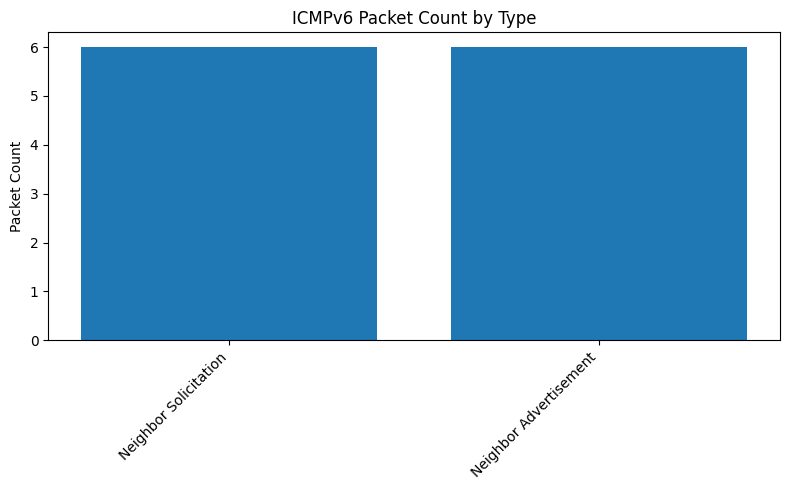

/var/folders/b8/1lh09w5s5z5crdjgpl31j47w0000gn/T/ipykernel_39864/2855389598.py:67: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.



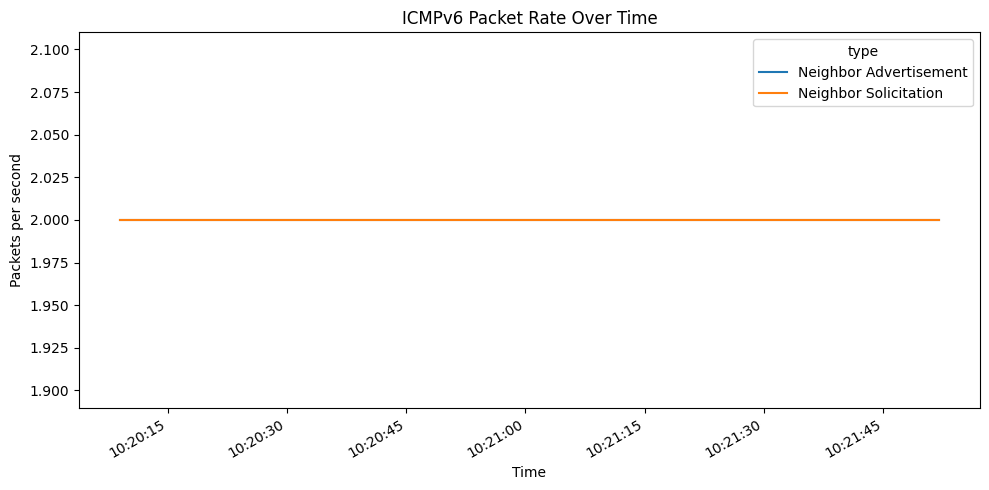


Top ICMPv6 Source → Destination Pairs:
                   Source               Destination  Count
fe80::188a:c5ce:6932:4274 fe80::1c7c:d692:38b9:8d48      6
fe80::1c7c:d692:38b9:8d48 fe80::188a:c5ce:6932:4274      6


In [61]:
from scapy.all import rdpcap, IPv6
from scapy.layers.inet6 import (
    ICMPv6ND_NS, ICMPv6ND_NA, ICMPv6ND_RA, ICMPv6ND_RS,
    ICMPv6EchoRequest, ICMPv6EchoReply, ICMPv6Unknown
)
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime



# === Setup ===
type_counter = Counter()
time_series = []
address_table = defaultdict(int)

icmpv6_type_names = {
    133: 'Router Solicitation',
    134: 'Router Advertisement',
    135: 'Neighbor Solicitation',
    136: 'Neighbor Advertisement',
    137: 'Redirect',
    143: 'MLDv2 Report',
    128: 'Echo Request',
    129: 'Echo Reply'
}

# === Extract ICMPv6 packets ===
for pkt in processed_packets:
    if not IPv6 in pkt:
        continue

    ipv6 = pkt[IPv6]
    src = ipv6.src
    dst = ipv6.dst

    icmp_layer = None
    for layer in [ICMPv6ND_NS, ICMPv6ND_NA, ICMPv6ND_RA, ICMPv6ND_RS,
                  ICMPv6EchoRequest, ICMPv6EchoReply, ICMPv6Unknown]:
        if pkt.haslayer(layer):
            icmp_layer = pkt[layer]
            break

    if icmp_layer:
        t = float(pkt.time)
        icmp_type = icmp_layer.type
        label = icmpv6_type_names.get(icmp_type, f"Type {icmp_type}")

        type_counter[label] += 1
        time_series.append((datetime.fromtimestamp(t), label))
        address_table[(src, dst)] += 1

# === Plot 1: Count by Type ===
plt.figure(figsize=(8, 5))
types, counts = zip(*type_counter.items())
plt.bar(types, counts)
plt.xticks(rotation=45, ha='right')
plt.title("ICMPv6 Packet Count by Type")
plt.ylabel("Packet Count")
plt.tight_layout()
plt.show()

# === Plot 2: Time Series ===
if time_series:
    df_time = pd.DataFrame(time_series, columns=["time", "type"])
    df_grouped = df_time.groupby([pd.Grouper(key='time', freq='1S'), 'type']).size().unstack(fill_value=0)
    
    df_grouped.plot(figsize=(10, 5))
    plt.title("ICMPv6 Packet Rate Over Time")
    plt.ylabel("Packets per second")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

# === Table: Source → Destination matrix ===
df_addr = pd.DataFrame([
    {'Source': src, 'Destination': dst, 'Count': count}
    for (src, dst), count in address_table.items()
])
print("\nTop ICMPv6 Source → Destination Pairs:")
print(df_addr.sort_values(by='Count', ascending=False).head(10).to_string(index=False))


Parsing QUIC traffic...

Total QUIC connections: 48
Total QUIC packets: 22642

Top 5 connections by packet count:
  173.194.182.201:443 → 192.168.4.10:53551 : 8993 packets
  192.168.4.10:53551 → 173.194.182.201:443 : 4541 packets
  142.250.186.110:443 → 192.168.4.10:55963 : 2759 packets
  216.58.206.68:443 → 192.168.4.10:62093 : 2051 packets
  192.168.4.10:55963 → 142.250.186.110:443 : 1505 packets

Session durations (top 5):
  17.248.248.101:443 → 192.168.4.10:53054 : 105.64s
  192.168.4.10:53054 → 17.248.248.101:443 : 105.62s
  142.250.186.110:443 → 192.168.4.10:55963 : 84.66s
  192.168.4.10:55963 → 142.250.186.110:443 : 84.66s
  192.168.4.10:55133 → 172.224.55.6:443 : 60.19s

QUIC Frame Types:
  ACK: 38 packets
  CRYPTO: 37 packets


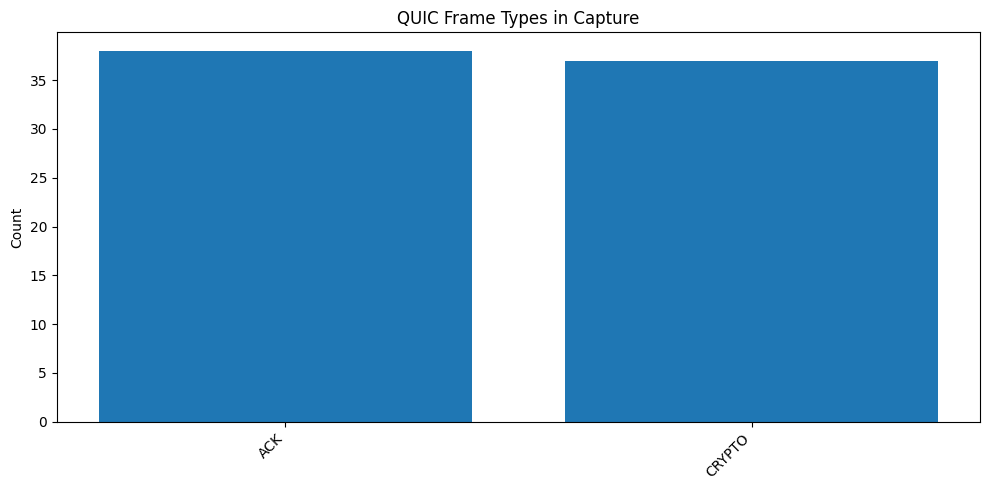

In [62]:
import pyshark
from collections import Counter, defaultdict
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt



# === Load capture ===
cap = pyshark.FileCapture(network_file, display_filter='quic')

connections = defaultdict(list)
frame_counter = Counter()
session_times = {}

print("Parsing QUIC traffic...")

for pkt in cap:
    try:
        ip_src = pkt.ip.src
        ip_dst = pkt.ip.dst
        udp_srcport = pkt.udp.srcport
        udp_dstport = pkt.udp.dstport
        timestamp = float(pkt.sniff_timestamp)
        time_dt = datetime.fromtimestamp(timestamp)

        conn_id = (ip_src, udp_srcport, ip_dst, udp_dstport)
        connections[conn_id].append(timestamp)

        # QUIC frame types may be comma-separated
        if hasattr(pkt.quic, 'frame_type'):
            frames = pkt.quic.frame_type.showname_value.split(',')
            for frame in frames:
                frame_clean = frame.strip().split(' ')[0]
                frame_counter[frame_clean] += 1

        # Track session time (earliest and latest seen)
        if conn_id not in session_times:
            session_times[conn_id] = [timestamp, timestamp]
        else:
            session_times[conn_id][1] = timestamp

    except AttributeError:
        continue

cap.close()

# === Print connection summary ===
print(f"\nTotal QUIC connections: {len(connections)}")
print(f"Total QUIC packets: {sum(len(p) for p in connections.values())}")

print("\nTop 5 connections by packet count:")
for conn, pkts in sorted(connections.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
    print(f"  {conn[0]}:{conn[1]} → {conn[2]}:{conn[3]} : {len(pkts)} packets")

# === Print session durations ===
print("\nSession durations (top 5):")
for conn, (start, end) in sorted(session_times.items(), key=lambda x: x[1][1]-x[1][0], reverse=True)[:5]:
    duration = end - start
    print(f"  {conn[0]}:{conn[1]} → {conn[2]}:{conn[3]} : {duration:.2f}s")

# === Print frame types ===
print("\nQUIC Frame Types:")
for f, count in frame_counter.most_common():
    print(f"  {f}: {count} packets")

# === Plot frame type frequency ===
frame_df = pd.DataFrame(frame_counter.items(), columns=['Frame Type', 'Count'])
frame_df = frame_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(frame_df['Frame Type'], frame_df['Count'])
plt.xticks(rotation=45, ha='right')
plt.title("QUIC Frame Types in Capture")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Parsing QUIC packets...


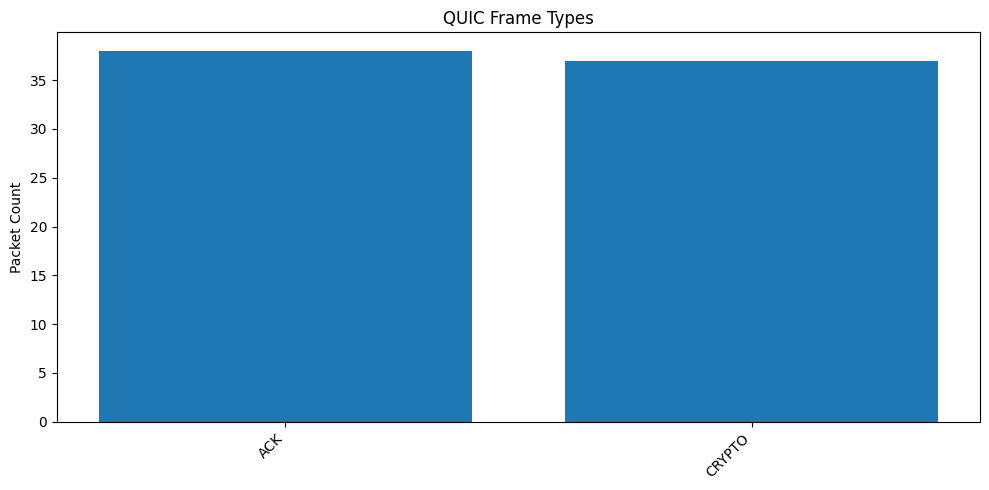

/var/folders/b8/1lh09w5s5z5crdjgpl31j47w0000gn/T/ipykernel_39864/3431856009.py:79: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.



<Figure size 1000x500 with 0 Axes>

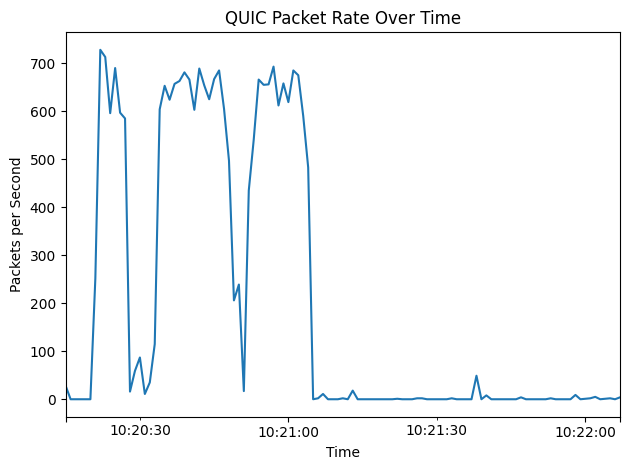

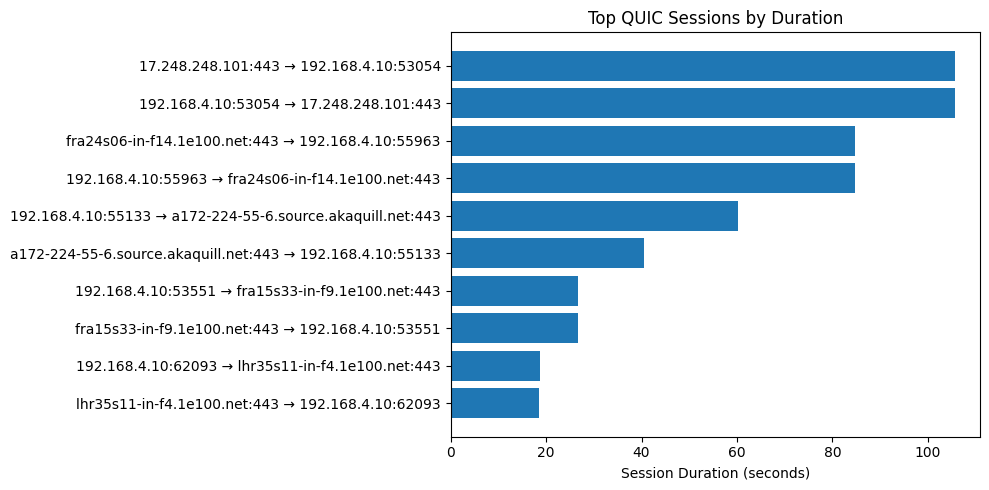

In [63]:
import pyshark
from collections import Counter, defaultdict
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

import socket

# Cache to avoid repeated lookups
rdns_cache = {}

def reverse_dns(ip):
    if ip in rdns_cache:
        return rdns_cache[ip]
    try:
        hostname = socket.gethostbyaddr(ip)[0]
    except Exception:
        hostname = ip  # Fallback to IP if lookup fails
    rdns_cache[ip] = hostname
    return hostname


cap = pyshark.FileCapture(network_file, display_filter='quic')

# === Data containers ===
connections = defaultdict(list)
frame_counter = Counter()
session_times = {}
packet_timestamps = []

print("Parsing QUIC packets...")

for pkt in cap:
    try:
        ip_src = pkt.ip.src
        ip_dst = pkt.ip.dst
        udp_srcport = pkt.udp.srcport
        udp_dstport = pkt.udp.dstport
        timestamp = float(pkt.sniff_timestamp)
        time_dt = datetime.fromtimestamp(timestamp)

        conn_id = (ip_src, udp_srcport, ip_dst, udp_dstport)
        connections[conn_id].append(time_dt)
        packet_timestamps.append(time_dt)

        if hasattr(pkt.quic, 'frame_type'):
            frames = pkt.quic.frame_type.showname_value.split(',')
            for frame in frames:
                frame_clean = frame.strip().split(' ')[0]
                frame_counter[frame_clean] += 1

        # Session timing
        if conn_id not in session_times:
            session_times[conn_id] = [timestamp, timestamp]
        else:
            session_times[conn_id][1] = timestamp

    except AttributeError:
        continue

cap.close()

# === Plot 1: Frame type bar chart ===
frame_df = pd.DataFrame(frame_counter.items(), columns=['Frame Type', 'Count'])
frame_df = frame_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(frame_df['Frame Type'], frame_df['Count'])
plt.xticks(rotation=45, ha='right')
plt.title("QUIC Frame Types")
plt.ylabel("Packet Count")
plt.tight_layout()
plt.show()

# === Plot 2: Packet rate over time ===
if packet_timestamps:
    df_time = pd.DataFrame(packet_timestamps, columns=["time"])
    df_time['count'] = 1
    df_time = df_time.set_index('time').resample('1S').count()

    plt.figure(figsize=(10, 5))
    df_time.plot(legend=False)
    plt.title("QUIC Packet Rate Over Time")
    plt.ylabel("Packets per Second")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

# === Plot 3: Top session durations ===
durations = []
for conn, (start, end) in session_times.items():
    src_host = reverse_dns(conn[0])
    dst_host = reverse_dns(conn[2])
    durations.append({
        'Connection': f'{src_host}:{conn[1]} → {dst_host}:{conn[3]}',
        'Duration (s)': end - start
    })

df_sessions = pd.DataFrame(durations)
df_sessions = df_sessions.sort_values(by='Duration (s)', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(df_sessions['Connection'], df_sessions['Duration (s)'])
plt.xlabel("Session Duration (seconds)")
plt.title("Top QUIC Sessions by Duration")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [65]:
import ipaddress
from scapy.all import IP

def get_layer7_packets_in_subnet(packetlist_by_protocol, subnet="192.168.4.0/24"):
    def is_in_subnet(ip, subnet):
        try:
            return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
        except Exception:
            return False

    packets_in_subnet = {}
    for proto, packets in packetlist_by_protocol.items():
        filtered = []
        for pkt in packets:
            if IP in pkt:
                src = pkt[IP].src
                dst = pkt[IP].dst
                if is_in_subnet(src, subnet) and is_in_subnet(dst, subnet):
                    filtered.append(pkt)
        if filtered:
            packets_in_subnet[proto] = filtered

    return packets_in_subnet

# Example usage:
packets_in_subnet = get_layer7_packets_in_subnet(packetlist_by_protocol, subnet="192.168.4.0/24")
for proto, pkts in packets_in_subnet.items():
    print(f"{proto}: {len(pkts)} packets")

ICMPV6: 1 packets
ARP: 1 packets
QUIC: 38 packets
DNS: 76 packets
TCP: 14 packets
TLS: 2 packets


In [66]:
import numpy as np

def analyze_tcp_payload_sizes(packetlist_by_protocol):
    """
    Analyze payload sizes for packets with TCP as the highest layer protocol.

    Args:
        packetlist_by_protocol (dict): Dictionary mapping protocol names to lists of Scapy packets.

    Returns:
        dict: Statistics including count, min, max, mean, and median payload size for TCP packets.
        list: List of all TCP payload sizes.
    """

    tcp_packets = packetlist_by_protocol.get('TCP', [])
    payload_sizes = []
    for pkt in tcp_packets:
        # Only count payload, not headers
        if hasattr(pkt, 'payload'):
            # Scapy's .payload may include headers of upper layers, so check for Raw
            if pkt.haslayer('Raw'):
                raw_layer = pkt.getlayer('Raw')
                payload_sizes.append(len(raw_layer.load))
            else:
                # If no Raw, payload is likely empty
                payload_sizes.append(0)
        else:
            payload_sizes.append(0)

    stats = {
        'count': len(payload_sizes),
        'min': int(np.min(payload_sizes)) if payload_sizes else 0,
        'max': int(np.max(payload_sizes)) if payload_sizes else 0,
        'mean': float(np.mean(payload_sizes)) if payload_sizes else 0.0,
        'median': float(np.median(payload_sizes)) if payload_sizes else 0.0
    }
    return stats, payload_sizes

# Example usage:
tcp_stats, tcp_payload_sizes = analyze_tcp_payload_sizes(packetlist_by_protocol)
print("TCP Payload Size Statistics:")
for k, v in tcp_stats.items():
    print(f"{k}: {v}")

TCP Payload Size Statistics:
count: 3063
min: 0
max: 1448
mean: 537.4296441397323
median: 39.0


Port Unreachable message
Sent from 17.248.209.68 to 192.168.4.4
Failed to parse embedded IP/UDP header: name 'struct' is not defined
Port Unreachable message
Sent from 17.248.209.71 to 192.168.4.4
Failed to parse embedded IP/UDP header: name 'struct' is not defined

Total ICMP packets: 2

ICMP Types:
  Type 3 (Destination Unreachable): 2 packets

ICMP Type/Code Details:
  Type 3 (Destination Unreachable), Code 3 (Port Unreachable): 2 packets

Top Source → Destination Pairs:
  17.248.209.68 → 192.168.4.4: 1 packets
  17.248.209.71 → 192.168.4.4: 1 packets


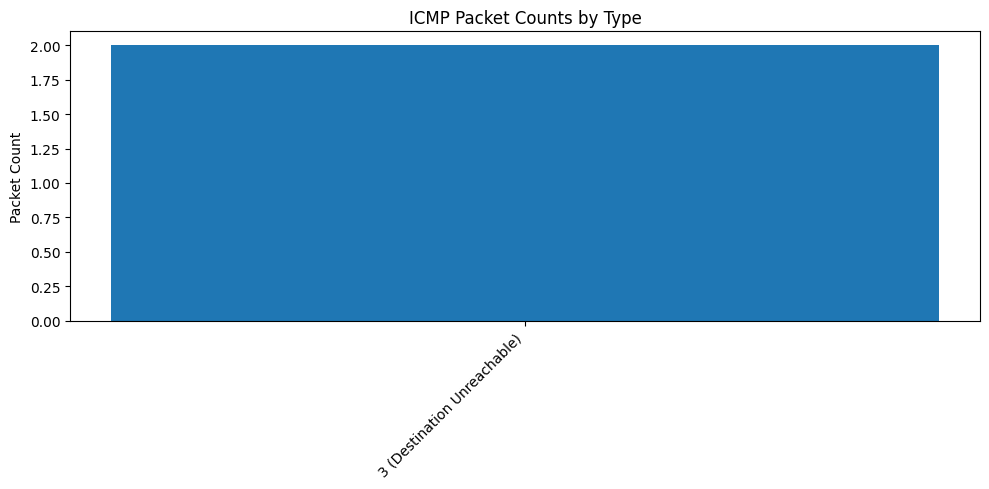

/var/folders/b8/1lh09w5s5z5crdjgpl31j47w0000gn/T/ipykernel_39864/3422946625.py:119: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

/Users/jonasjostan/Documents/itestra/connected-mobility-basics-group-7/.venv/lib/python3.13/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.



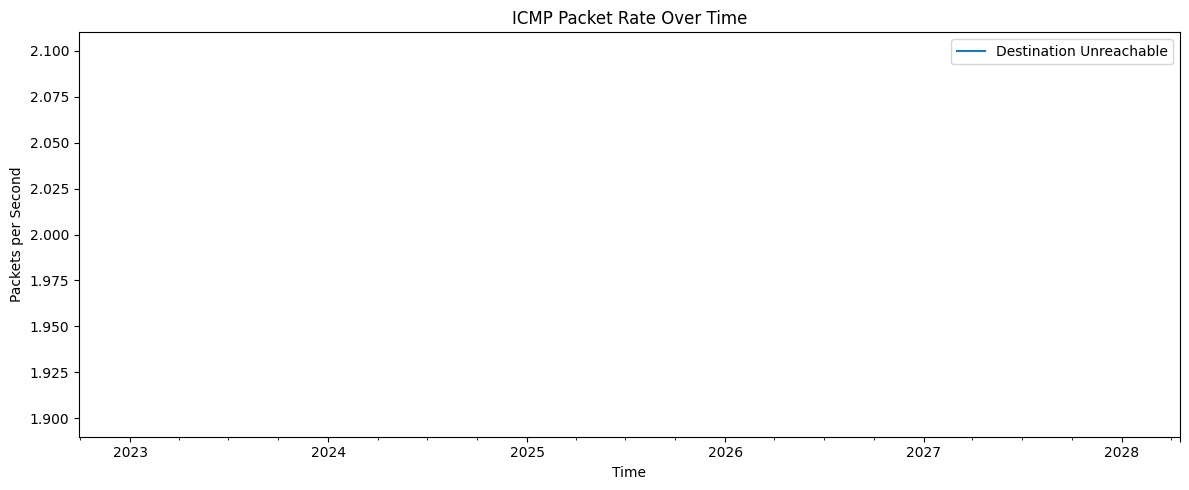

In [67]:
from scapy.all import rdpcap, IP, ICMP
from collections import Counter, defaultdict
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# === ICMP Type/Code Descriptions ===
icmp_type_map = {
    0: 'Echo Reply',
    3: 'Destination Unreachable',
    4: 'Source Quench (Deprecated)',
    5: 'Redirect Message',
    8: 'Echo Request',
    9: 'Router Advertisement',
    10: 'Router Solicitation',
    11: 'Time Exceeded',
    12: 'Parameter Problem',
    13: 'Timestamp Request',
    14: 'Timestamp Reply',
    15: 'Information Request (Deprecated)',
    16: 'Information Reply (Deprecated)',
    17: 'Address Mask Request',
    18: 'Address Mask Reply'
}

icmp_code_map = {
    (3, 0): "Net Unreachable",
    (3, 1): "Host Unreachable",
    (3, 2): "Protocol Unreachable",
    (3, 3): "Port Unreachable",
    (5, 0): "Redirect for Network",
    (5, 1): "Redirect for Host",
    (11, 0): "TTL Expired",
    (11, 1): "Fragment Reassembly Timeout"
}

# === Load packets ===


# === Counters and Data ===
icmp_type_counter = Counter()
icmp_code_counter = Counter()
src_dst_counter = defaultdict(int)
timestamps = []

for pkt in processed_packets:
    if IP in pkt and ICMP in pkt:
        ip = pkt[IP]
        icmp = pkt[ICMP]
        t = datetime.fromtimestamp(float(pkt.time))

        icmp_type = icmp.type
        icmp_code = icmp.code
        if icmp_type == 3 and icmp_code == 3:
            print("Port Unreachable message")
            
            if pkt.haslayer(IP):
                # This is the ICMP envelope's IP header
                icmp_ip = pkt[IP]
                print(f"Sent from {icmp_ip.src} to {icmp_ip.dst}")

                # Try to extract embedded IP header (original offending packet)
                if Raw in pkt:
                    raw_bytes = bytes(pkt[Raw].load)
                    
                    try:
                        embedded_ip = IP(raw_bytes)
                        ip_header_len = embedded_ip.ihl * 4
                        
                        # Only proceed if there's enough payload for port extraction
                        if len(raw_bytes) >= ip_header_len + 4:
                            # Extract bytes for UDP source/dest ports
                            udp_segment = raw_bytes[ip_header_len:ip_header_len+4]
                            sport, dport = struct.unpack('!HH', udp_segment)
                            print(f"Original UDP Source Port: {sport}, Destination Port: {dport}")
                        else:
                            print("Not enough payload to extract ports")

                    except Exception as e:
                        print(f"Failed to parse embedded IP/UDP header: {e}")
        icmp_type_counter[icmp_type] += 1
        icmp_code_counter[(icmp_type, icmp_code)] += 1
        src_dst_counter[(ip.src, ip.dst)] += 1
        timestamps.append((t, icmp_type))

# === Summary ===
print(f"\nTotal ICMP packets: {sum(icmp_type_counter.values())}")

print("\nICMP Types:")
for t, c in icmp_type_counter.items():
    desc = icmp_type_map.get(t, "Unknown")
    print(f"  Type {t} ({desc}): {c} packets")

print("\nICMP Type/Code Details:")
for (t, code), count in icmp_code_counter.items():
    type_desc = icmp_type_map.get(t, "Unknown")
    code_desc = icmp_code_map.get((t, code), "Unspecified")
    print(f"  Type {t} ({type_desc}), Code {code} ({code_desc}): {count} packets")

print("\nTop Source → Destination Pairs:")
for (src, dst), count in sorted(src_dst_counter.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {src} → {dst}: {count} packets")



# === Plot 1: ICMP Types ===
plt.figure(figsize=(10, 5))
labels = [f"{t} ({icmp_type_map.get(t, 'Unknown')})" for t in icmp_type_counter]
counts = list(icmp_type_counter.values())
plt.bar(labels, counts)
plt.title("ICMP Packet Counts by Type")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Packet Count")
plt.tight_layout()
plt.show()

# === Plot 2: Time Series ===
df_time = pd.DataFrame(timestamps, columns=["time", "type"])
df_time_grouped = df_time.groupby([pd.Grouper(key='time', freq='1S'), 'type']).size().unstack(fill_value=0)
df_time_grouped.columns = [icmp_type_map.get(t, f'Type {t}') for t in df_time_grouped.columns]

df_time_grouped.plot(figsize=(12, 5))
plt.title("ICMP Packet Rate Over Time")
plt.ylabel("Packets per Second")
plt.xlabel("Time")
plt.tight_layout()
plt.show()



=== Communication Summary ===
Protocol Classification  Packet Count  Upload (bytes)  Download (bytes)  Total Bytes                 First Seen                  Last Seen
    QUIC      Encrypted         22642          843585          17162202     18030492 2025-07-08 10:20:15.753428 2025-07-08 10:22:07.984869
     TCP    Unencrypted          3063          195969           1605691      1844451 2025-07-08 10:20:17.323488 2025-07-08 10:22:08.194464
     TLS      Encrypted          1622           98149            764412       885963 2025-07-08 10:20:17.343338 2025-07-08 10:22:08.086365
     DNS    Unencrypted           132           10070             25948        37707 2025-07-08 10:20:17.301796 2025-07-08 10:21:53.005013
     ARP    Unencrypted            24            5405                84         5819 2025-07-08 10:20:11.496328 2025-07-08 10:22:06.046087
    MDNS    Unencrypted             8             798              3164         4488 2025-07-08 10:20:25.130577 2025-07-08 10:20:31.287

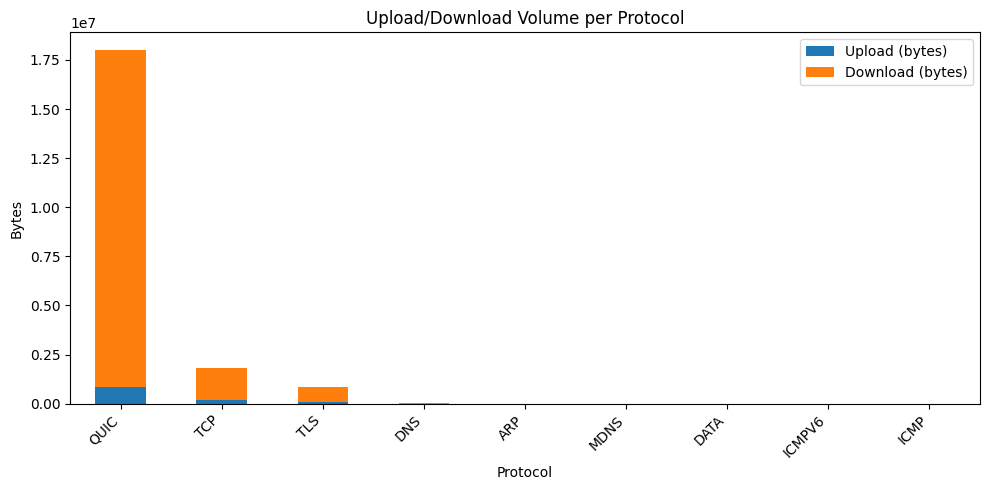

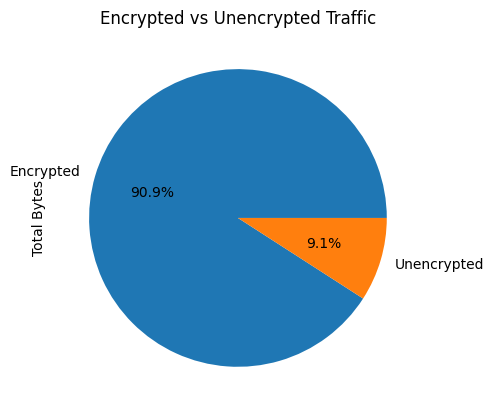

In [ ]:
from scapy.layers.inet import IP
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

# === INPUTS ===
# Example:
# protocol_packets = {
#     'HTTPS': [pkt1, pkt2, ...],
#     'HTTP': [...],
#     'DNS': [...],
# }
protocol_packets:dict = packetlist_by_protocol
device_mac_address = 'ea:3a:f4:12:0b:9c'  # Replace with your device's MAC address
print(protocol_packets)
# === Classification ===
encrypted_protocols = {
    'HTTPS', 'QUIC', 'SSH', 'TLS', 'FTPS', 'IMAPS'
}

def classify_protocol(proto_name: str) -> str:
    return 'Encrypted' if proto_name.upper() in encrypted_protocols else 'Unencrypted'

# === Analysis ===
summary = []

for protocol, packets in protocol_packets.items():
    upload = 0
    download = 0
    times = []
    total_bytes = 0

    for pkt in packets:
        if not Et in pkt:
            continue
        ip = pkt[IP]
        length = len(pkt)
        total_bytes += length
        times.append(datetime.fromtimestamp(float(pkt.time)))

        if ip.src == device_ip:
            upload += length
        elif ip.dst == device_ip:
            download += length

    classification = classify_protocol(protocol)

    summary.append({
        'Protocol': protocol,
        'Classification': classification,
        'Packet Count': len(packets),
        'Upload (bytes)': upload,
        'Download (bytes)': download,
        'Total Bytes': total_bytes,
        'First Seen': min(times) if times else None,
        'Last Seen': max(times) if times else None
    })

# === Output Table ===
df = pd.DataFrame(summary)
df = df.sort_values(by='Total Bytes', ascending=False)
print("\n=== Communication Summary ===")
print(df.to_string(index=False))

# === Total Volume Summary ===
total_upload = df['Upload (bytes)'].sum()
total_download = df['Download (bytes)'].sum()
total_all = df['Total Bytes'].sum()

print("\n=== Total Traffic Volume ===")
print(f"  Upload:   {total_upload:,} bytes")
print(f"  Download: {total_download:,} bytes")
print(f"  Total:    {total_all:,} bytes")


# === Plot 1: Upload/Download Volume ===
df.plot(x='Protocol', y=['Upload (bytes)', 'Download (bytes)'],
        kind='bar', stacked=True, figsize=(10, 5))
plt.title("Upload/Download Volume per Protocol")
plt.ylabel("Bytes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === Plot 2: Encrypted vs Unencrypted Bytes ===
traffic_split = df.groupby('Classification')['Total Bytes'].sum()
traffic_split.plot.pie(autopct='%1.1f%%', figsize=(5, 5),
                       title="Encrypted vs Unencrypted Traffic")
plt.tight_layout()
plt.show()x



=== Communication Summary ===
Protocol Classification  Packet Count  Upload (bytes)  Download (bytes)  Total Bytes                 First Seen                  Last Seen
     TCP    Unencrypted          3063           23151             19514        42665 2025-07-08 10:20:29.590856 2025-07-08 10:22:06.605082
    QUIC      Encrypted         22642           13218             11361        24579 2025-07-08 10:20:30.170237 2025-07-08 10:22:05.490845
     TLS      Encrypted          1622           11644             11758        23402 2025-07-08 10:20:29.591210 2025-07-08 10:22:06.558356
     DNS    Unencrypted           132            1320               369         1689 2025-07-08 10:20:30.148722 2025-07-08 10:20:30.168487
    MDNS    Unencrypted             8             162                 0          162 2025-07-08 10:20:31.283643 2025-07-08 10:20:31.283643
    ICMP    Unencrypted             2              78                 0           78 2025-07-08 10:20:30.491482 2025-07-08 10:20:30.491

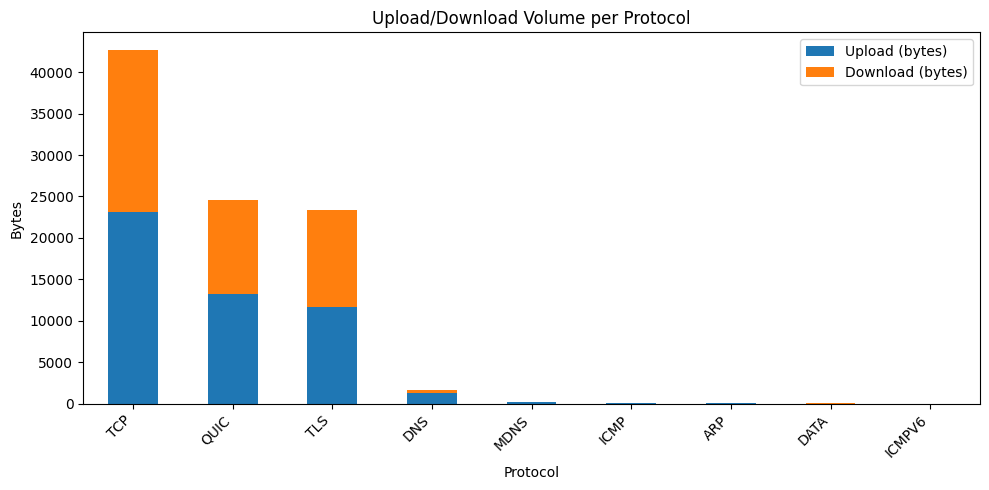

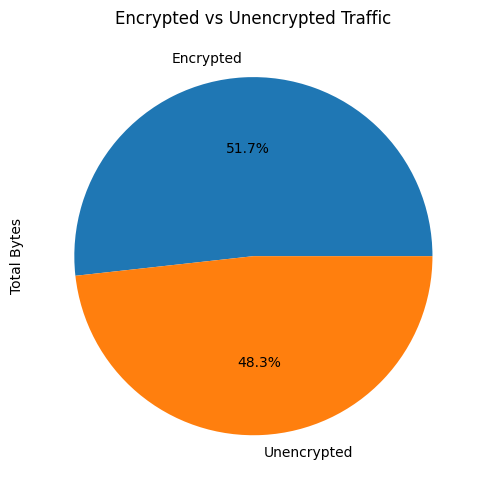

In [14]:
#ipad

from scapy.layers.inet import IP
from scapy.layers.l2 import Ether
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# === INPUTS ===
protocol_packets: dict = packetlist_by_protocol  # provided externally
device_mac_address = '6e:a3:36:08:e0:1c'  # replace with your device's MAC address

# === Classification ===
encrypted_protocols = {
    'HTTPS', 'QUIC', 'SSH', 'TLS', 'FTPS', 'IMAPS'
}

def classify_protocol(proto_name: str) -> str:
    return 'Encrypted' if proto_name.upper() in encrypted_protocols else 'Unencrypted'

# === Analysis ===
summary = []

for protocol, packets in protocol_packets.items():
    upload = 0
    download = 0
    times = []
    total_bytes = 0

    for pkt in packets:
        if not pkt.haslayer(Ether) or not pkt.haslayer(IP):
            continue

        eth = pkt[Ether]
        ip = pkt[IP]

        # Filter by MAC address
        if device_mac_address not in (eth.src.lower(), eth.dst.lower()):
            continue

        length = len(pkt)
        total_bytes += length
        times.append(datetime.fromtimestamp(float(pkt.time)))

        if eth.src.lower() == device_mac_address:
            upload += length
        elif eth.dst.lower() == device_mac_address:
            download += length

    classification = classify_protocol(protocol)

    summary.append({
        'Protocol': protocol,
        'Classification': classification,
        'Packet Count': len(packets),
        'Upload (bytes)': upload,
        'Download (bytes)': download,
        'Total Bytes': total_bytes,
        'First Seen': min(times) if times else None,
        'Last Seen': max(times) if times else None
    })

# === Output Table ===
df = pd.DataFrame(summary)
df = df.sort_values(by='Total Bytes', ascending=False)
print("\n=== Communication Summary ===")
print(df.to_string(index=False))

# === Total Volume Summary ===
total_upload = df['Upload (bytes)'].sum()
total_download = df['Download (bytes)'].sum()
total_all = df['Total Bytes'].sum()

print("\n=== Total Traffic Volume ===")
print(f"  Upload:   {total_upload:,} bytes")
print(f"  Download: {total_download:,} bytes")
print(f"  Total:    {total_all:,} bytes")

# === Plot 1: Upload/Download Volume ===
df.plot(x='Protocol', y=['Upload (bytes)', 'Download (bytes)'],
        kind='bar', stacked=True, figsize=(10, 5))
plt.title("Upload/Download Volume per Protocol")
plt.ylabel("Bytes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("upload_download_volume.png")  # Save the bar chart
plt.show()

# === Plot 2: Encrypted vs Unencrypted Bytes ===
traffic_split = df.groupby('Classification')['Total Bytes'].sum()
traffic_split.plot.pie(autopct='%1.1f%%', figsize=(5, 5),
                       title="Encrypted vs Unencrypted Traffic")
plt.tight_layout()
plt.savefig("encrypted_vs_unencrypted.png")  # Save the pie chart
plt.show()



In [12]:
from scapy.all import UDP, IP, rdpcap, Raw
from collections import Counter
from datetime import datetime

def analyze_nbns_traffic(packets):
    query_count = 0
    response_count = 0
    queried_names = Counter()
    src_ips = Counter()
    dst_ips = Counter()

    for pkt in packets:
        if IP in pkt and UDP in pkt:
            udp = pkt[UDP]
            if udp.dport == 137 or udp.sport == 137:
                ip = pkt[IP]
                src_ips[ip.src] += 1
                dst_ips[ip.dst] += 1

                if Raw in pkt:
                    payload = bytes(pkt[Raw].load)
                    # Check if it's a query or a response (bit 7 of byte 2 = QR flag)
                    if len(payload) > 2:
                        qr_flag = payload[2] & 0b10000000
                        if qr_flag == 0:
                            query_count += 1
                            # Extract queried name (heuristically)
                            name_len = payload[12]
                            if 13 + name_len < len(payload):
                                name_bytes = payload[13:13 + name_len]
                                name = ''.join(chr(b) for b in name_bytes if 32 <= b <= 126)
                                queried_names[name] += 1
                        else:
                            response_count += 1

    # === Output Summary ===
    print("\n=== NBNS Analysis ===")
    print(f"Total NBNS queries: {query_count}")
    print(f"Total NBNS responses: {response_count}")
    print("\nTop Queried Names:")
    for name, count in queried_names.most_common(5):
        print(f"  {name}: {count} times")

    print("\nTop Source IPs:")
    for ip, count in src_ips.most_common(5):
        print(f"  {ip}: {count} packets")

    print("\nTop Destination IPs:")
    for ip, count in dst_ips.most_common(5):
        print(f"  {ip}: {count} packets")

analyze_nbns_traffic(processed_packets)


=== NBNS Analysis ===
Total NBNS queries: 0
Total NBNS responses: 0

Top Queried Names:

Top Source IPs:

Top Destination IPs:


In [13]:
%pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [24]:
from scapy.all import TCP
from collections import Counter
from prettytable import PrettyTable

def get_flag_meaning(flag_str):
    # Map flag string to explanation
    flag_map = {
        'S': 'SYN (Synchronize)',
        'A': 'ACK (Acknowledgment)',
        'F': 'FIN (Finish)',
        'R': 'RST (Reset)',
        'P': 'PSH (Push)',
        'U': 'URG (Urgent)',
        'E': 'ECE (ECN-Echo)',
        'C': 'CWR (Congestion Window Reduced)',
        '': 'No flags'
    }
    # Multiple flags can be set, e.g., 'SA'
    return ', '.join(flag_map.get(c, c) for c in flag_str)

def summarize_tcp_flags_latex(tcp_packets, filename="tcp_flags_table.tex"):
    flag_counts = Counter()
    for pkt in tcp_packets:
        if pkt.haslayer(TCP) and pkt.lastlayer().name == "TCP":
            flags = str(pkt[TCP].flags)
            flag_counts[flags] += 1

    table = PrettyTable()
    table.field_names = ["TCP Flags", "Count", "Meaning"]
    for flag, count in flag_counts.items():
        meaning = get_flag_meaning(flag)
        table.add_row([flag, count, meaning])

    latex_str = table.get_latex_string()
    print(latex_str)
    with open(filename, "w") as f:
        f.write(latex_str)

summarize_tcp_flags_latex(protocol_packets.get('TCP', []))


\begin{tabular}{ccc}
TCP Flags & Count & Meaning \\
SA & 9 & SYN (Synchronize), ACK (Acknowledgment) \\
A & 1182 & ACK (Acknowledgment) \\
R & 12 & RST (Reset) \\
FA & 18 & FIN (Finish), ACK (Acknowledgment) \\
RA & 5 & RST (Reset), ACK (Acknowledgment) \\
SEC & 9 & SYN (Synchronize), ECE (ECN-Echo), CWR (Congestion Window Reduced) \\
SAE & 10 & SYN (Synchronize), ACK (Acknowledgment), ECE (ECN-Echo) \\
\end{tabular}


In [18]:
protocol_packets.keys()  # List all protocols in the capture
print("\nAvailable Protocols in Capture:")
for proto in protocol_packets.keys():
    print(f"  - {proto}")


Available Protocols in Capture:
  - ICMPV6
  - ARP
  - QUIC
  - DNS
  - TCP
  - TLS
  - MDNS
  - ICMP
  - DATA


1622


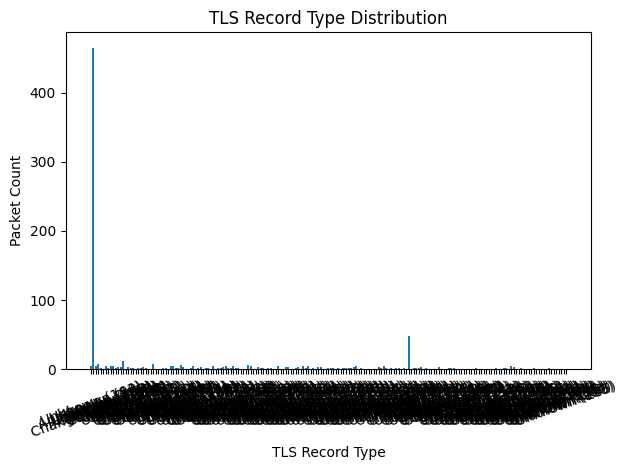

/var/folders/b8/1lh09w5s5z5crdjgpl31j47w0000gn/T/ipykernel_8363/2570086507.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([size_data["Client"], size_data["Server"]], labels=["Client", "Server"])


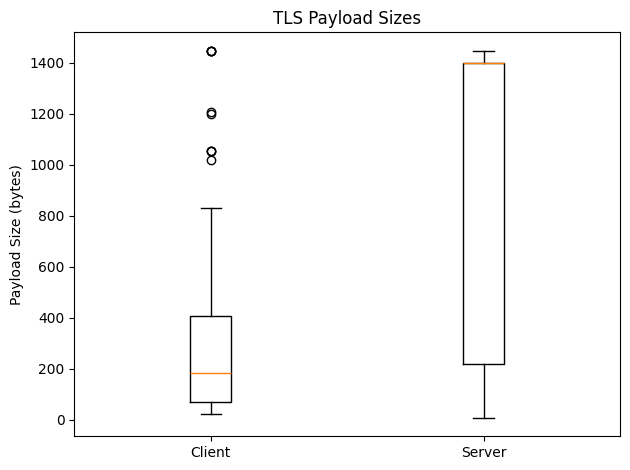

In [22]:
from scapy.all import rdpcap, TCP, IP
import matplotlib.pyplot as plt
import collections

TLS_TYPES = {
    0x14: "Change Cipher Spec",
    0x15: "Alert",
    0x16: "Handshake",
    0x17: "Application Data"
}

def classify_tls_record(payload):
    if len(payload) > 0:
        rec_type = payload[0]
        return TLS_TYPES.get(rec_type, f"Unknown ({rec_type})")
    return "Empty"

def analyze_tls(packets):
    type_counts = collections.Counter()
    sizes = {"Client": [], "Server": []}

    for pkt in packets:
        if pkt.haslayer(TCP):
            if pkt[TCP].dport == 443 or pkt[TCP].sport == 443:
                payload = bytes(pkt[TCP].payload)
                if not payload:
                    continue

                record_type = classify_tls_record(payload)
                type_counts[record_type] += 1

                direction = "Client" if pkt[TCP].dport == 443 else "Server"
                sizes[direction].append(len(payload))

    return type_counts, sizes

# Load and analyze
tls_packets = protocol_packets.get('TLS', [])
print(len(tls_packets))
record_counts, size_data = analyze_tls(protocol_packets.get('TLS', []))

# --- Plot TLS Record Type Distribution ---
plt.figure()
plt.title("TLS Record Type Distribution")
plt.bar(record_counts.keys(), record_counts.values())
plt.xlabel("TLS Record Type")
plt.ylabel("Packet Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# --- Plot Payload Sizes (Client vs Server) ---
plt.figure()
plt.title("TLS Payload Sizes")
plt.boxplot([size_data["Client"], size_data["Server"]], labels=["Client", "Server"])
plt.ylabel("Payload Size (bytes)")
plt.tight_layout()
plt.show()


In [15]:
from scapy.layers.inet import IP
from collections import Counter
import pandas as pd

def analyze_tls_ips(tls_packets):
    """
    Analyze the most common IP addresses from a list of TLS packets.

    Parameters:
        tls_packets (list): A list of Scapy packets containing TLS traffic.

    Returns:
        pd.DataFrame: A DataFrame showing top IPs by frequency and role (src/dst).
    """
    src_ips = Counter()
    dst_ips = Counter()

    for pkt in tls_packets:
        if pkt.haslayer(IP):
            ip_layer = pkt[IP]
            src_ips[ip_layer.src] += 1
            dst_ips[ip_layer.dst] += 1

    # Combine and sort by total appearances
    all_ips = Counter()
    for ip in set(src_ips) | set(dst_ips):
        all_ips[ip] = src_ips.get(ip, 0) + dst_ips.get(ip, 0)

    df = pd.DataFrame([
        {
            'IP Address': ip,
            'Source Count': src_ips.get(ip, 0),
            'Destination Count': dst_ips.get(ip, 0),
            'Total Count': all_ips[ip]
        }
        for ip in all_ips
    ])

    df = df.sort_values(by='Total Count', ascending=False).reset_index(drop=True)

    return df

tls_packets = protocol_packets.get("TLS", [])
df_tls_ips = analyze_tls_ips(tls_packets)
print(df_tls_ips.to_string(index=False))


     IP Address  Source Count  Destination Count  Total Count
   192.168.4.10           578                957         1535
  141.84.69.233           166                147          313
 129.187.254.73           172                 80          252
 142.250.186.86           139                 25          164
142.250.184.206           126                 32          158
 157.240.253.61            52                 78          130
142.250.186.110            63                 48          111
 142.250.74.206            87                 16          103
    192.168.4.4            49                 38           87
  16.170.124.74            20                 46           66
  17.248.209.71            25                 37           62
  17.248.209.64            29                 30           59
  13.107.253.45            16                 11           27
173.194.182.201            16                 10           26
   17.57.146.54            13                 10           23
 17.248.